# Setup

In [ ]:
from __future__ import annotations
from google.cloud import aiplatform
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
import vertexai
vertexai.init(project="axial-device-305114")  # Replace "your-project-id" with your actual project ID
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

In [ ]:
!pip install pymannkendall
!pip install datasets
!pip install tiktoken

from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import pymannkendall as mk
from huggingface_hub import login, hf_hub_download, upload_file
import numpy as np
import json, time, torch, random, zipfile, os, statistics, tiktoken, re, itertools, markdown
from openai import OpenAI
from datasets import load_dataset
from scipy.stats import linregress, norm

# Set your API key as an environment variable
os.environ['OPENAI_API_KEY'] = ''
client = OpenAI()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.1 MB/s eta 0:00:00


# Defining Prompts
Before doing inference, define the prompt that consists of instruction, input, and output.

## Common Prompts

In [ ]:
alpaca_prompt = """

### Instruction:
{}

### Input:
{}

### Response:
{}"""

output_text = ""

criteria = """Ensure the following *criteria* are met:"""

plausibility = """
**Plausibility:** The reasons provided should be plausible. For example, do not hallucinate, and do not make up factual information."""

support = """
**Support:** The reasons must support the given main claim. For example, stay focused on the main claim without deviating into unrelated claims."""

originality = """
**Originality:** Your reasons should be original and unique. For example, do not reiterate the well-known arguments.

"""

length_argument_outline = """
**Length:** The reasons should be around 100 words in total, equivalent to the length of an outline for one body section or subsection."""

length_argument_section = """
**Length:** Your argument should be around 800 words, equivalent to the length of one body section or subsection."""

claim_rsg = """

**Main Claim:** *Propositional modularity\* is incompatible with connectionist models\*\* of cognitive systems.*

"""

claim_clark = """

**Main Claim:** *Functionally discrete\* beliefs playing a causal role\* **can** be compatible with connectionist models\*\* of cognitive systems.*

"""

claim_smolstich = """

**Main Claim:** *Although there are no propositionally modular beliefs, eliminativism regarding belief is not justified.*

"""

claim_chroom = """

**Main Claim:** *Any digital computer does not understand Chinese soley on the basis of implementing the appropriate program for understanding Chinese.*

"""

In [ ]:
text_prop_modul = """\"Though common-sense psychology contains a wealth of lore about beliefs, memories, desires, hopes, fears and the other propositional attitudes, the crucial folk psychological tenets in forging the link between connectionism and eliminativism are the claims that propositional attitudes are *functionally discrete*, *semantically interpretable*, states that play a *causal role* in the production of other propositional attitudes, and ultimately in the production of behavior. Following the suggestion in Stich (1983, pp. 237 ff.), we’ll call this cluster of claims *propositional modularity*.

To illustrate the way in which folk psychology takes propositional attitudes to be *functionally discrete*, *causally active* states, let us sketch a more elaborate example.

In common-sense psychology, behavior is often explained by appeal to certain of the agent’s beliefs and desires. Thus, to explain why Alice went to her office, we might note that she wanted to send some e-mail messages (and, of course, she believed she could do so from her office). However, in some cases an agent will have several sets of beliefs and desires each of which might lead to the same behavior. Thus we may suppose that Alice also wanted to talk to her research assistant, and that she believed he would be at the office. In such cases, common sense psychology assumes that Alice's going to her office might have been caused by either one of the belief/desire pairs, or by both, and that determining which of these options obtains is an empirical matter. So it is entirely possible that on this occasion Alice's desire to send some e-mail played no role in producing her behavior; it was the desire to talk with her research assistant that actually caused her to go to the office. However, had she not wanted to talk with her research assistant, she might have gone to the office anyhow, because the desire to sent some e-mail, which was causally inert in her actual decision making, might then have become actively involved. Note that in this case common sense psychology is prepared to recognize a pair of quite *distinct* *semantically characterized* states, one of which may be *causally active* while the other is not.\""""

text_conn_model = """\"Connectionist models are large networks of simple parallel computing elements, each of which carries a numerical *activation value* which it computes from the values of neighboring elements in the network, using some simple numerical formula. The network elements, or *units*, influence each other’s values through connections that carry a numerical strength or *weight* ...

In a typical ... model, input to the system is provided by imposing activation values on the *input units* of the network; these numerical values represent some encoding, or *representation*, of the input. The activation on the input units propagates along the connections until some set of activation values emerges on the *output units*; these activation values encode the output the system has computed from the input. In between the input and output units there may be other units, often called *hidden units*, that participate in representing neither the input nor the output.

The computation performed by the network in transforming the input pattern of activity to the output pattern depends on the set of connection strengths; these weights are usually regarded as encoding the system's knowledge. In this sense, the connection strengths play the role of the program in a conventional computer. Much of the allure of the Connectionist approach is that many connectionist networks program themselves, that is, they have autonomous procedures for tuning their weights to eventually perform some specific computation. Such *learning procedures* often depend on training in which the network is presented with sample input/output pairs from the function it is supposed to compute. In learning networks with hidden units, the network itself ‘decides’ what computations the hidden units will perform; because these units represent neither inputs nor outputs, they are never ‘told’ what their values should be, even during training.

In many connectionist models the hidden units and the output units are assigned a numerical ‘bias’ which is added into the calculation determining the unit’s activation level. The learning procedures for such networks typically set both the connection strengths and the biases. Thus in these networks the system’s knowledge is usually regarded as encoded in *both* the connection strengths and the biases.\""""

In [ ]:
if False:
  completion = client.chat.completions.create(
      model="gpt-4o-mini",
      seed=9,
      store=True,
      top_p = 0.01,
      messages=[
          {"role": "system", "content": "Write a concise passage based on the given text, focusing on the concepts of *propositional modularity*, *functional discreteness*, *semantic interpretability*, and *causal role*."},
          {"role": "user", "content": text_prop_modul}
      ],
  )
  prop_modul = """

  (\*Information about propositional modularity, functional discreteness, semantic interpretability, and causal role: {} (Ramsey, Stich, and Garon, 1995))

  """.format(completion.choices[0].message.content)
  print(prop_modul)

prop_modul = """

(\*Information about propositional modularity, functional discreteness, semantic interpretability, and causal role: Propositional modularity refers to the concept that propositional attitudes, such as beliefs and desires, are functionally discrete, semantically interpretable, and play a causal role in behavior. In common-sense psychology, these attitudes are seen as distinct states that can independently influence actions. For instance, Alice's decision to go to her office could be driven by her desire to send emails or to talk to her research assistant. Each desire represents a semantically distinct state, and either could be causally active in prompting her behavior. This illustrates how propositional attitudes are modular, with each having the potential to independently affect outcomes based on their causal roles. (Ramsey, Stich, and Garon, 1995))

"""

In [ ]:
if False:
  completion = client.chat.completions.create(
      model="gpt-4o-mini",
      seed=9,
      store=True,
      top_p = 0.01,
      messages=[
          {"role": "system", "content": "Write a concise paragraph centered on connectionist models, based on the provided text."},
          {"role": "user", "content": text_conn_model}
      ],
  )

  conn_model = """

  (\*\*Information about connectionist models: {} (Smolensky, 1995; Ramsey et al., 1995))

  """.format(completion.choices[0].message.content)
  print(conn_model)

conn_model = """

(\*\*Information about connectionist models: Connectionist models are networks composed of simple, parallel computing units that process information by propagating activation values through connections with varying strengths, or weights. These models transform input data into output through a series of interconnected units, including hidden units that facilitate complex computations without explicit instructions. The network's knowledge is encoded in the connection strengths and biases, which are adjusted through learning procedures. These procedures often involve training with input/output pairs, allowing the network to autonomously tune its weights and biases to perform specific computations. This self-programming capability is a key feature of connectionist models, enabling them to adapt and learn from data. (Ramsey et al., 1995; Smolensky, 1995))

"""

## Improving Argument Outlines

In [ ]:
# Prompts for an outline generation with instructions focused on originality and cogency

outline_generation_task = """

**{}** State reasons to support the main claim provided.

"""

outline_form = """

**Reason (1):** [Provide the reason supporting the main claim.]

**Reason (2):** [Provide the reason supporting the main claim.]

**Reason (3):** [Provide the reason supporting the main claim, if applicable.]

[Provide additional reasons if applicable.]

"""

outline_generation_instruction = outline_generation_task.format("Task Prompt:") + criteria + length_argument_outline + plausibility + support + originality

outline_generation_input = "{}" + prop_modul + conn_model + outline_form

print(alpaca_prompt.format(outline_generation_instruction, outline_generation_input.format(claim_rsg), output_text))



### Instruction:


**Task Prompt:** State reasons to support the main claim provided.

Ensure the following *criteria* are met:
**Length:** The reasons should be around 100 words in total, equivalent to the length of an outline for one body section or subsection.
**Plausibility:** The reasons provided should be plausible. For example, do not hallucinate, and do not make up factual information.
**Support:** The reasons must support the given main claim. For example, stay focused on the main claim without deviating into unrelated claims.
**Originality:** Your reasons should be original and unique. For example, do not reiterate the well-known arguments.



### Input:


**Main Claim:** *Propositional modularity\* is incompatible with connectionist models\*\* of cognitive systems.*



(\*Information about propositional modularity, functional discreteness, semantic interpretability, and causal role: Propositional modularity refers to the concept that propositional attitudes, such as belief

In [ ]:
# Prompts of outline originality critic

outline_originality_critic_instruction = """

**{}** For the provided reasons, construct a critique that identify any points that lack originality. Your critique should be around 50 words. Do *not* critique, challenge, or comment on the position or stance of the main claim under any circumstances.

"""

originality_critic_form = """

**Critique** on **Reasons**

Non-Original Points:
- [Specify any identified non-original point, if applicable.]
- [Add another identified non-original point if applicable.]
[List additional non-original points, if applicable.]

"""

outline_originality_critic_input = "{}" + prop_modul + conn_model + "\n\n**Reasons**: \"\"\"{}\"\"\"\n\n" + outline_originality_critic_instruction.format("Task Reminder:") + originality_critic_form

print(alpaca_prompt.format(outline_originality_critic_instruction.format("Task Prompt:"),
                           outline_originality_critic_input.format(claim_rsg, "[Each generated outline will be inserted here.]"),
                           output_text))




### Instruction:


**Task Prompt:** For the provided reasons, construct a critique that identify any points that lack originality. Your critique should be around 50 words. Do *not* critique, challenge, or comment on the position or stance of the main claim under any circumstances.



### Input:


**Main Claim:** *Propositional modularity\* is incompatible with connectionist models\*\* of cognitive systems.*



(\*Information about propositional modularity, functional discreteness, semantic interpretability, and causal role: Propositional modularity refers to the concept that propositional attitudes, such as beliefs and desires, are functionally discrete, semantically interpretable, and play a causal role in behavior. In common-sense psychology, these attitudes are seen as distinct states that can independently influence actions. For instance, Alice's decision to go to her office could be driven by her desire to send emails or to talk to her research assistant. Each desire represents 

In [ ]:
# Prompts of outline originality and cogency critic

outline_cogentoriginality_critic_instruction = """

**{}** For the provided reasons, construct a critique that identify any points that are implausible, fail to support the main claim, or lack originality. Your critique should be around 50 words. Do *not* critique, challenge, or comment on the position or stance of the main claim under any circumstances.

"""


critic_cogentoriginality_form = """

**Critique** on **Reasons**

Implausible Points:
- [Specify any identified implausible point if applicable.]
[List additional implausible points, if applicable.]

Points Not Supporting the Main Claim:
- [Specify any identified point that does not support the main claim if applicable.]
[List additional points not supporting the main claim, if applicable.]

Non-Original Points:
- [Specify any identified non-original point, if applicable.]
[List additional non-original points, if applicable.]

"""

outline_cogentoriginality_critic_input = "{}" + prop_modul + conn_model + "\n\n**Reasons**: \"\"\"{}\"\"\"\n\n" + outline_cogentoriginality_critic_instruction.format("Task Reminder:") + critic_cogentoriginality_form

print(alpaca_prompt.format(outline_cogentoriginality_critic_instruction.format("Task Prompt:"),
                           outline_cogentoriginality_critic_input.format(claim_rsg, "[Each generated outline will be inserted here.]"),
                           output_text))



### Instruction:


**Task Prompt:** For the provided reasons, construct a critique that identify any points that are implausible, fail to support the main claim, or lack originality. Your critique should be around 50 words. Do *not* critique, challenge, or comment on the position or stance of the main claim under any circumstances.



### Input:


**Main Claim:** *Propositional modularity\* is incompatible with connectionist models\*\* of cognitive systems.*



(\*Information about propositional modularity, functional discreteness, semantic interpretability, and causal role: Propositional modularity refers to the concept that propositional attitudes, such as beliefs and desires, are functionally discrete, semantically interpretable, and play a causal role in behavior. In common-sense psychology, these attitudes are seen as distinct states that can independently influence actions. For instance, Alice's decision to go to her office could be driven by her desire to send emails or to tal

In [ ]:

revise_task = """

**{}** Revise the last reasons by removing the points identified in all the critique provided. The revised reasons should *support* the main claim.

"""


revise_originality_instruction = revise_task.format("Task Prompt:") + criteria + length_argument_outline + originality

revise_originality_input = "{}" + prop_modul + conn_model + "\n\n\"\"\"{}\"\"\"\n\n" + revise_task.format("Task Reminder:") + outline_form

print(alpaca_prompt.format(revise_originality_instruction,
                           revise_originality_input.format(claim_rsg, "[Each history of generated outlines and critiques will be inserted here]"),
                           output_text))



### Instruction:


**Task Prompt:** Revise the last reasons by removing the points identified in all the critique provided. The revised reasons should *support* the main claim.

Ensure the following *criteria* are met:
**Length:** The reasons should be around 100 words in total, equivalent to the length of an outline for one body section or subsection.
**Originality:** Your reasons should be original and unique. For example, do not reiterate the well-known arguments.



### Input:


**Main Claim:** *Propositional modularity\* is incompatible with connectionist models\*\* of cognitive systems.*



(\*Information about propositional modularity, functional discreteness, semantic interpretability, and causal role: Propositional modularity refers to the concept that propositional attitudes, such as beliefs and desires, are functionally discrete, semantically interpretable, and play a causal role in behavior. In common-sense psychology, these attitudes are seen as distinct states that can 

In [ ]:
revise_cogentoriginality_instruction = revise_task.format("Task Prompt:") + criteria + length_argument_outline + plausibility + support + originality

revise_cogentoriginality_input = "{}" + prop_modul + conn_model + "\n\n\"\"\"{}\"\"\"\n\n" + revise_task.format("Task Reminder:") + outline_form

print(alpaca_prompt.format(revise_cogentoriginality_instruction,
                           revise_cogentoriginality_input.format(claim_rsg, "[Each history of generated outlines and critiques will be inserted here]"),
                           output_text))



### Instruction:


**Task Prompt:** Revise the last reasons by removing the points identified in all the critique provided. The revised reasons should *support* the main claim.

Ensure the following *criteria* are met:
**Length:** The reasons should be around 100 words in total, equivalent to the length of an outline for one body section or subsection.
**Plausibility:** The reasons provided should be plausible. For example, do not hallucinate, and do not make up factual information.
**Support:** The reasons must support the given main claim. For example, stay focused on the main claim without deviating into unrelated claims.
**Originality:** Your reasons should be original and unique. For example, do not reiterate the well-known arguments.



### Input:


**Main Claim:** *Propositional modularity\* is incompatible with connectionist models\*\* of cognitive systems.*



(\*Information about propositional modularity, functional discreteness, semantic interpretability, and causal role: 

## Improving Argument Texts

In [ ]:
text_revision_instruction = "Revise the whole text provided."


text_revision_input = "\"\"\"{}\"\"\"\n\n\n\n" + "Reminder: " + text_revision_instruction

print(alpaca_prompt.format(text_revision_instruction,
                           text_revision_input.format("[Each argument text will be inserted here.]"),
                           output_text))



### Instruction:
Revise the whole text provided.

### Input:
"""[Each argument text will be inserted here.]"""



Reminder: Revise the whole text provided.

### Response:



In [ ]:
outline_synthesis_task = """Break down the provided text into the main claim and reasons that support the claim.\n\n"""

outline_synthesis_instruction = outline_synthesis_task + criteria + length_argument_outline

outline_synthesis_input = "\"\"\"{}\"\"\"\n\n" + "\n\nReminder: " + outline_synthesis_task + "\n\n**Main Claim:** *[State the main claim concisely.]*" + outline_form

print(alpaca_prompt.format(outline_synthesis_instruction,
                           outline_synthesis_input.format("[Each argument text will be inserted here.]"),
                           output_text))



### Instruction:
Break down the provided text into the main claim and reasons that support the claim.

Ensure the following *criteria* are met:
**Length:** The reasons should be around 100 words in total, equivalent to the length of an outline for one body section or subsection.

### Input:
"""[Each argument text will be inserted here.]"""



Reminder: Break down the provided text into the main claim and reasons that support the claim.



**Main Claim:** *[State the main claim concisely.]*

**Reason (1):** [Provide the reason supporting the main claim.]

**Reason (2):** [Provide the reason supporting the main claim.]

**Reason (3):** [Provide the reason supporting the main claim, if applicable.]

[Provide additional reasons if applicable.]



### Response:



# Improving the Originality and Cogency of Argument Outlines

## Generating Normal Outlines

In [ ]:
gpt_gen = False

In [149]:

def generate_gpt_responses(top_p, generation_instruction, generation_input, process_list, response_list):
  completion = client.chat.completions.create(
      model=gpt_model_title,
      seed=seed,
      n=n,
      top_p=top_p,
      store=True,
      messages=[
          {"role": "system", "content": generation_instruction},
          {"role": "user", "content": generation_input}
      ],
  )
  for i in range(n):
    response = (
        "### Instruction:\n" + generation_instruction +
        "\n\n### Input:\n" + generation_input +
        "\n\n### Response:\n" + completion.choices[i].message.content
    )

    process_list.append(response)

    response_list.append(completion.choices[i].message.content)
    print(f"\n\nResponse {len(response_list)}:\n\n")
    print(completion.choices[i].message.content)
    print(f"({len(completion.choices[i].message.content)} characters)")

  response_critique_history.append(f"\n\n**Reasons 1:** \"\"\"{completion.choices[0].message.content}\"\"\"\n\n")

In [ ]:
gpt_model_title = "o1"
response_critique_history = []
seeds = [9, 60, 315, 8714, 3171, 1516, 848, 2039]
n=8

In [ ]:
if gpt_gen:
    a_process_listlist_normal_outline = []
    process_listlist_normal_outline = []
    for seed in [seeds[7], seeds[6]]:
        for claim in [claim_rsg, claim_clark]:
            gpt_process_normal_outline = []
            gpt_response_normal_outline = []

            generate_gpt_responses(1,
                outline_generation_instruction,
                outline_generation_input.format(claim),
                gpt_process_normal_outline,
                gpt_response_normal_outline
            )
            if seed==seeds[7]:
              process_listlist_normal_outline.append(gpt_process_normal_outline)
            else:
              a_process_listlist_normal_outline.append(gpt_process_normal_outline)

In [ ]:
# For saving generation processes

def save_and_upload(process_list):
    # Save the data to a local file
    with open(f"{filename}.jsonl", "w") as f:
        for item in process_list:
            f.write(json.dumps(item) + '\n')

    # Upload the file to the Hugging Face repository
    upload_file(
        path_or_fileobj=f"{filename}.jsonl",
        path_in_repo=f"{filename}.jsonl",
        repo_id=repo_name,
        repo_type="dataset",
        token=access_token,
    )

# Save the processes to a Markdown file.
def save_process_markdown(process_listlist, filename):
    markdown_filename = f"{filename}.md"
    try:
        with open(markdown_filename, "w") as md_file:
            if process_listlist and isinstance(process_listlist[0], list):
                # Handle nested lists
                for process_list_index, process_list in enumerate(process_listlist):
                    md_file.write(f"\n\n# List {process_list_index + 1}\n\n")
                    for process_index, process in enumerate(process_list):
                        md_file.write(f"## Process {process_index + 1}\n\n")
                        md_file.write(f"{process.strip()}\n\n")
            else:
                # Handle a single list of processes
                for process_index, process in enumerate(process_listlist):
                    md_file.write(f"## Process {process_index + 1}\n\n")
                    md_file.write(f"{process.strip()}\n\n")
    except Exception as e:
        print(f"An error occurred while saving to {markdown_filename}: {e}")

# Input: process_listlist (a list of lists of process strings)
def generate_response_listlist(process_listlist, del_critique):
    response_listlist = []
    for process_index, process_list in enumerate(process_listlist):
        # Extract responses from each process list
        response_list = [
            process.split("### Response:")[-1].strip()
            for process in process_list
        ]
        if del_critique:
            # Remove critique responses (every second item)
            response_list = response_list[0::2]
        # Select claim based on index
        claim = claim_rsg if process_index < len(process_listlist)//2 else claim_clark

        # Prepend claim to each response
        response_listlist.append([claim + response for response in response_list])

    return response_listlist

def generate_response_list(process_list):
  # Make a list for responses
  response_list = []
  for process in process_list:
      response = process.split("### Response:")[-1].strip()
      response_list.append(response)
  return response_list

def download_and_process_file(del_critique):
    # Download the file
    filepath = hf_hub_download(repo_id=repo_name, filename=f"{filename}.jsonl", repo_type="dataset")

    # Load the JSONL file as a list
    process_list = []
    with open(filepath, 'r') as f:
        for line in f:
            process_list.append(json.loads(line))

    # Save the list as Markdown if required
    save_process_markdown(process_list, filename)
    if isinstance(process_list[0], list):
        response_list = generate_response_listlist(process_list, del_critique)
    else:
        response_list = generate_response_list(process_list)

    return process_list, response_list

access_token = ""

In [ ]:
gpt_model_title = "o1"
n=11
seed = seeds[7]

repo_name = "Chickward/processes"
filename = f"{n}_process_listlist_normal_outline_seed{seed}_{gpt_model_title}"
if gpt_gen:
  save_and_upload(process_listlist_normal_outline)

process_listlist_normal_outline, response_listlist_normal_outline = download_and_process_file(del_critique = False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)istlist_normal_outline_seed2039_o1.jsonl:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

In [ ]:
n=11
seed = seeds[6]
filename = f"a_{n}_process_listlist_normal_outline_seed{seed}_{gpt_model_title}"
if gpt_gen:
  save_and_upload(a_process_listlist_normal_outline)

a_process_listlist_normal_outline, a_response_listlist_normal_outline = download_and_process_file(del_critique = False)

(…)listlist_normal_outline_seed848_o1.jsonl:   0%|          | 0.00/80.8k [00:00<?, ?B/s]

## Generating Original Outlines

In [ ]:
def generate_improved_gpt_outlines(claim, critic_instruction, critic_input,
                                    revision_instruction, revision_input,
                                    process_list, outlines, simple_enhance):
    for i in range(num_iteration):

        completion = client.chat.completions.create(
            model=gpt_model_title,
            seed=seed,
            store=True,
            reasoning_effort = "high",

            messages=[
                {"role": "developer", "content": critic_instruction},
                {"role": "user", "content": critic_input.format(claim, outlines[len(outlines)-1])}
            ],
        )
        response = (
            "### Instruction:\n" + critic_instruction +
            "\n\n### Input:\n" + critic_input.format(claim, outlines[len(outlines)-1]) +
            "\n\n### Response:\n" + completion.choices[0].message.content
        )
        process_list.append(response)
        response_critique_history.append(f"\n\n**Critique {i+1}** on **Reasons {i+1}:** \"\"\"{completion.choices[0].message.content}\"\"\"\n\n")
        print(f"\n\nCritique {i+1}:\n\n")
        print(completion.choices[0].message.content)

        completion = client.chat.completions.create(
            model=gpt_model_title,
            seed=seed,
            store=True,
            reasoning_effort = "high",
            messages=[
                {"role": "developer", "content": revision_instruction.format("Task Prompt:")},
                {"role": "user", "content": revision_input.format(claim, "".join(item for item in response_critique_history) if simple_enhance == False else response_critique_history[2*i] + response_critique_history[2*i+1])}
            ],
        )

        response = (
            "### Instruction:\n" + revision_instruction.format("Task Prompt:") +
            "\n\n### Input:\n" + revision_input.format(claim, "".join(item for item in response_critique_history) if simple_enhance == False else response_critique_history[2*i] + response_critique_history[2*i+1])  +
            "\n\n### Response:\n" + completion.choices[0].message.content
        )

        process_list.append(response)
        outlines.append(completion.choices[0].message.content)
        response_critique_history.append(f"\n\n**Reasons {i+2}** given **Critique {i+1}:**\n\"\"\"{completion.choices[0].message.content}\"\"\"\n\n")
        print(f"\n\nReasons {i+2}:\n\n")
        print(completion.choices[0].message.content)

In [ ]:

num_iteration = 10
n = 1
gpt_model_title = "o1"
if gpt_gen:
    process_listlist_original_outline = []
    simple_process_listlist_original_outline = []
    # For each selected seed, generate and improve outlines for both claims
    for simple_enhance in [False, True]:
        for claim in [claim_rsg, claim_clark]:
            for seed in seeds[1:5]:
                gpt_process_original_outline = []
                gpt_response_original_outline = []
                response_critique_history = []

                generate_gpt_responses(1,
                    outline_generation_instruction,
                    outline_generation_input.format(claim),
                    gpt_process_original_outline,
                    gpt_response_original_outline,

                )

                generate_improved_gpt_outlines(
                    claim,
                    outline_originality_critic_instruction.format("Task Prompt:"),
                    outline_originality_critic_input,
                    revise_originality_instruction,
                    revise_originality_input,
                    gpt_process_original_outline,
                    gpt_response_original_outline,
                    simple_enhance
                )
                if simple_enhance == False:
                    process_listlist_original_outline.append(gpt_process_original_outline)
                else:
                    simple_process_listlist_original_outline.append(gpt_process_original_outline)


In [ ]:

repo_name = "Chickward/processes"
filename = f"{num_iteration*2 +1}_process_listlist_original_outline_{gpt_model_title}"
if gpt_gen:
    save_and_upload(process_listlist_original_outline)
process_listlist_original_outline, response_listlist_original_outline = download_and_process_file(True)

(…)ocess_listlist_original_outline_o1.jsonl:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

In [ ]:
filename = f"simple_{num_iteration*2 +1}_process_listlist_original_outline_{gpt_model_title}"
if gpt_gen:
    save_and_upload(simple_process_listlist_original_outline)
simple_process_listlist_original_outline, simple_response_listlist_original_outline = download_and_process_file(True)

(…)ocess_listlist_original_outline_o1.jsonl:   0%|          | 0.00/751k [00:00<?, ?B/s]

## Generating Original and Cogent Outlines

In [ ]:
n = 1
if gpt_gen:
    process_listlist_cogentoriginal_outline = []
    simple_process_listlist_cogentoriginal_outline = []
    # For each selected seed, generate and improve outlines for both claims
    for simple_enhance in [False, True]:
        for claim in [claim_rsg, claim_clark]:
            for seed in seeds[1:5]:
                gpt_process_cogentoriginal_outline = []
                gpt_response_cogentoriginal_outline = []
                response_critique_history = []

                generate_gpt_responses(1,
                    outline_generation_instruction,
                    outline_generation_input.format(claim),
                    gpt_process_cogentoriginal_outline,
                    gpt_response_cogentoriginal_outline,

                )

                generate_improved_gpt_outlines(
                    claim,
                    outline_cogentoriginality_critic_instruction.format("Task Prompt:"),
                    outline_cogentoriginality_critic_input,
                    revise_cogentoriginality_instruction,
                    revise_cogentoriginality_input,
                    gpt_process_cogentoriginal_outline,
                    gpt_response_cogentoriginal_outline,
                    simple_enhance
                )
                if simple_enhance == False:
                    process_listlist_cogentoriginal_outline.append(gpt_process_cogentoriginal_outline)
                else:
                    simple_process_listlist_cogentoriginal_outline.append(gpt_process_cogentoriginal_outline)

In [ ]:
repo_name = "Chickward/processes"
filename = f"{num_iteration*2 + 1}_process_listlist_cogentoriginal_outline_{gpt_model_title}"
if gpt_gen:
    save_and_upload(process_listlist_cogentoriginal_outline)
process_listlist_cogentoriginal_outline, response_listlist_cogentoriginal_outline = download_and_process_file(True)

(…)listlist_cogentoriginal_outline_o1.jsonl:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
filename = f"simple_{num_iteration*2 + 1}_process_listlist_cogentoriginal_outline_{gpt_model_title}"
if gpt_gen:
    save_and_upload(simple_process_listlist_cogentoriginal_outline)
simple_process_listlist_cogentoriginal_outline, simple_response_listlist_cogentoriginal_outline = download_and_process_file(True)

(…)listlist_cogentoriginal_outline_o1.jsonl:   0%|          | 0.00/803k [00:00<?, ?B/s]

In [ ]:
word_counts = [
    len(response[i].split()) for i in range(11)
    for response in response_listlist_original_outline
]

median_word_count = statistics.median(word_counts)
mean_word_count = statistics.mean(word_counts)

print(f"The median number of words is: {median_word_count}")
print(f"The average number of words is: {mean_word_count}")



The median number of words is: 116.0
The average number of words is: 114.7840909090909


gpt-4o

normal: 178.5, 176.41

original: 156, 156.75

cogentoriginal: 149.5, 149.23

original[10]: 159.6, 155.5

cogentoriginal[10]: 158.5, 156.5

o1-preview

normal: 141.5, 151.41

original: 134, 135.49

cogentoriginal: 134, 136.53

original[10]: 144.5, 140.125

cogentoriginal[10]: 137.5, 137.125

o1

normal: 118, 115.82

original: 116, 114.78

cogentoriginal: 114, 114.81

original[10]: 116, 114.25

cogentoriginal[10]: 117.5, 113.875

## Generating Irrelevant Outlines

In [ ]:
gpt_gen = False

In [ ]:
n=8
process_listlist_smolstich_outline = []
if gpt_gen:
  for seed in [seeds[5], seeds[6]]:
    process_smolstich_outline = []
    response_smolstich_outline = []

    generate_gpt_responses(1,
        outline_generation_instruction,
        claim_smolstich + prop_modul + outline_form,
        process_smolstich_outline,
        response_smolstich_outline
    )

    process_listlist_smolstich_outline.append(process_smolstich_outline)

In [ ]:
filename = f"{n}_process_listlist_smolstich_outline_{gpt_model_title}"

if gpt_gen:
  save_and_upload(process_listlist_smolstich_outline)

process_listlist_smolstich_outline, response_listlist_smolstich_outline = download_and_process_file(del_critique = False)

(…)cess_listlist_smolstich_outline_o1.jsonl:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

In [ ]:
process_listlist_chroom_outline = []
if gpt_gen:
  for seed in [seeds[5], seeds[6]]:
    process_chroom_outline = []
    response_chroom_outline = []

    generate_gpt_responses(1,
        outline_generation_instruction,
        claim_chroom + outline_form,
        process_chroom_outline,
        response_chroom_outline
    )

    process_listlist_chroom_outline.append(process_chroom_outline)

In [ ]:
filename = f"{n}_process_listlist_chroom_outline_{gpt_model_title}"

if gpt_gen:
  save_and_upload(process_listlist_chroom_outline)

process_listlist_chroom_outline, response_listlist_chroom_outline = download_and_process_file(del_critique = False)

(…)process_listlist_chroom_outline_o1.jsonl:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

# Synthesizing Outlines from Existing Argument Texts
Generate argument outlines based on texts in literatures, section by section.

## Exploring Data

In [ ]:
# Load a dataset from huggingface and map the dataset by the function above.
existing_argument_texts = load_dataset("ChickWard/ConnEli", split = "train")
# View 3 random examples in the dataset.

list_existing_argument_texts = []
for i in range(len(existing_argument_texts)):
    list_existing_argument_texts.append(existing_argument_texts[i]["output"])

print(len(list_existing_argument_texts))

for i in range(1):
    random_index = random.randint(0, len(list_existing_argument_texts) - 1)
    print(list_existing_argument_texts[random_index])


(…)0the%20threat%20of%20eliminativism.jsonl:   0%|          | 0.00/45.8k [00:00<?, ?B/s]

(…)mpiricistbehaviorist%20linguistics.jsonl:   0%|          | 0.00/30.4k [00:00<?, ?B/s]

cleaned_CDPE_1.jsonl:   0%|          | 0.00/529k [00:00<?, ?B/s]

cleaned_CDPE_2.jsonl:   0%|          | 0.00/129k [00:00<?, ?B/s]

(…)hy%20Meets%20the%20Extended%20Mind.jsonl:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

(…)d_Is%20connectionism%20commonsense.jsonl:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

(…)y%20and%20cognitive%20architecture.jsonl:   0%|          | 0.00/42.6k [00:00<?, ?B/s]

(…)leaned_Networks%20with%20Attitudes.jsonl:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

(…)mmitments%20of%20folk%20psychology.jsonl:   0%|          | 0.00/64.1k [00:00<?, ?B/s]

cleaned_TMSO.jsonl:   0%|          | 0.00/84.6k [00:00<?, ?B/s]

(…)eaned_Connectionism%20isnt%20magic.jsonl:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

(…)nder%20to%20Forster%20and%20Saidel.jsonl:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

cleaned_PCT.jsonl:   0%|          | 0.00/721k [00:00<?, ?B/s]

(…)%20Ramsey%2C%20Stich%20and%20Garon.jsonl:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

(…)%20semantic%20view%20of%20theories.jsonl:   0%|          | 0.00/47.7k [00:00<?, ?B/s]

(…)C%20and%20connectionist%20networks.jsonl:   0%|          | 0.00/18.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/285 [00:00<?, ? examples/s]

285
\section*{7 Sub-symbolic Definition of Cognitive Systems and Some Foundational Issues}
In order for the sub-conceptual level to be rightly viewed as a level for practicing cognitive science, it is necessary that the principles formulated at this level truly be principles of cognition. Since sub-symbolic principles are neither conceptual-level nor neural-level principles, it is not immediately apparent what kind of cognitive principles they might be. The structure of sub-symbolic models is that of a dynamical system; in what sense do these models embody principles of cognition rather than principles of physics?

What distinguishes those dynamical systems that are cognitive from those that are not? At this point the types of dynamical systems being studied in Connectionist cognitive science lack anything that could justly be called an intentional psychology. In this section I wish to show that it is none the less possible to distinguish the sort of dynamical systems that have so far 

In [ ]:
# Step 1: Get the number of words in each string
word_counts = [len(text.split()) for text in list_existing_argument_texts]

# Step 2: Compute the median of the word counts
median_word_count = statistics.median(word_counts)
mean_word_count = statistics.mean(word_counts)

# Step 3: Print the median number of words
print(f"The median number of words is: {median_word_count}")
print(f"The average number of words is: {mean_word_count}")

The median number of words is: 791
The average number of words is: 1002.680701754386


In [ ]:
# Step 1: Define thresholds
low_word_threshold = 200
high_word_threshold = 3200

# Step 2: Identify indices of dictionaries to remove based on word count thresholds
indices_to_remove = [
    index
    for index, entry in enumerate(list_existing_argument_texts)
    if len(entry.split()) < low_word_threshold
    or len(entry.split()) > high_word_threshold
]

# Print the indices of dictionaries to be removed
print("Indices of dictionaries to remove:", indices_to_remove)

Indices of dictionaries to remove: [19, 22, 32, 36, 51, 59, 66, 70, 73, 82, 95, 99, 105, 110, 111, 114, 149, 151, 169, 182, 185, 189, 191, 192, 198, 199, 207, 211, 221, 230, 232, 239, 248, 251, 252, 255, 261, 270, 271, 276]


In [ ]:
for i in [95, 99, 105]:
  print(list_existing_argument_texts[i])

\section*{1 The Projectable Features of Connectionist Psychology}
\begin{quotation}
The moral here is that though there are indefinitely many connectionist networks that represent the information that dogs have fur just as well as Network A does, these networks have no projectable features in common that are describable in the language of Connectionist theory. From the point of view of the connectionist model builder, the class of networks that might model a cognitive agent who believes that dogs have fur is not a genuine kind at all, but simply a chaotically disjunctive set. Commonsense psychology treats the class of people who believe that dogs have fur as a psychologically natural kind; Connectionist psychology does not. (chapter 8, p. 329)
\end{quotation}

\section*{3 Deriving Connectionist Belief in RSGnet ${ }_{0}$}
I now develop the technical core of my argument: that when weight and learning analysis are employed to explain the behavior of nets like RSGnet, two Connectionist fo

In [ ]:
# Step 3: Remove the identified dictionaries
list_existing_argument_texts = [
    entry for index, entry in enumerate(list_existing_argument_texts)
    if index not in indices_to_remove
]

# Print the remaining number of dictionaries
print("Remaining dictionaries count:", len(list_existing_argument_texts))

Remaining dictionaries count: 245


## Revising Existing Argument Texts

In [ ]:
gpt_gen = False

In [ ]:
num_samples = len(list_existing_argument_texts)

if num_samples < len(list_existing_argument_texts):
    indices = random.sample(range(len(list_existing_argument_texts)), num_samples)
else:
    indices = range(num_samples)

In [ ]:
seed=seeds[0]
gpt_model_title = "gpt-4o"
if gpt_gen:
  process_revised_existing_texts=[]
  response_revised_existing_texts=[]
  n=1
  for i in indices:
    generate_gpt_responses(0.01, text_revision_instruction,
                           text_revision_input.format(list_existing_argument_texts[i]),
                           process_revised_existing_texts, response_revised_existing_texts, 4096)

In [ ]:
repo_name = "Chickward/processes"
filename = f"{num_samples}_process_revised_existing_texts_seed{seed}_{gpt_model_title}"

if gpt_gen:
    save_and_upload(process_revised_existing_texts)
process_revised_existing_texts, response_revised_existing_texts = download_and_process_file(False)

response_revised_existing_texts = [text.replace("**Revised Text:**", "", 1).strip() for text in response_revised_existing_texts]

response_revised_existing_texts

(…)evised_existing_texts_seed9_gpt-4o.jsonl:   0%|          | 0.00/3.05M [00:00<?, ?B/s]

['# Asking What\'s Inside the Head: Neurophilosophy Meets the Extended Mind\n\nIn their historical overview of cognitive science, Bechtel et al. (1998) describe the field as having expanded its focus beginning in the mid-1980s. Previously, the field had spent 25 years concentrating on internalist, high-level GOFAI ("good old-fashioned artificial intelligence" [Haugeland 1985]), but it was finally moving "outwards into the environment and downwards into the brain" (Bechtel et al. 1998, p. 75). A significant force behind this downward movement was Patricia Churchland\'s "Neurophilosophy" (1986). This book initiated a movement that truly came of age in 1999 when Kathleen Akins won a million-dollar fellowship to begin the McDonnell Project in Philosophy and the Neurosciences. The McDonnell Project placed neurophilosophy at the forefront of philosophy of mind and cognitive science, resulting in numerous articles, conferences, special journal issues, and books. In two major new books, neurop

In [ ]:
for i in range(1):
    random_index = random.randint(0, len(response_revised_existing_texts) - 1)
    print(response_revised_existing_texts[random_index])

# Connectionism and Teleology

In this section, I will explore some remaining issues related to connectionism and teleology, offering preliminary remarks on each.

Homuncular Functionalism posits that psychological and biological entities are organisms in a robust sense: they are teleologically integrated systems of organs, each defined by its specific functions. These organs are composed of smaller organs, creating a hierarchical structure. But how does this concept apply to connectionism?

A connectionist network can indeed function as an organ, meaning an organ could be structured like a connectionist network without any inherent conflict. A slightly more intriguing question is whether the components of a connectionist network can themselves be considered organs in a teleological sense. Do they serve the network as units and connections? In biological systems, there seems to be no reason why they couldn't. Connectionist networks are highly integrated systems, and their presence in b

## Synthesizing Outlines

In [ ]:
gpt_gen = False

In [ ]:
gpt_model_title = "gpt-4o"
seed=seeds[0]
if gpt_gen:
    gpt_process_synthesis_outline=[]
    gpt_response_synthesis_outline=[]
    n=1
    for text in response_revised_existing_texts:
        generate_gpt_responses(0.01, outline_synthesis_instruction,
                              outline_synthesis_input.format(text),
                              gpt_process_synthesis_outline, gpt_response_synthesis_outline, 256)

In [ ]:
repo_name = "Chickward/processes"
filename = f"{len(list_existing_argument_texts)}_process_synthesis_outline_seed{seed}_{gpt_model_title}"

if gpt_gen:
    save_and_upload(gpt_process_synthesis_outline)
gpt_process_synthesis_outline, gpt_response_synthesis_outline = download_and_process_file(False)

(…)ess_synthesis_outline_seed9_gpt-4o.jsonl:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [ ]:
for i in range(1):
    random_index = random.randint(0, len(gpt_response_synthesis_outline) - 1)
    print(gpt_response_synthesis_outline[random_index])

**Main Claim:** Connectionist networks can be understood as teleologically integrated systems, similar to biological organs, with potential functions for their components, though the nature of these functions may be complex and not strictly representational.

**Reason (1):** Connectionist networks can function as organs, suggesting that their components might also be considered organs in a teleological sense, serving the network as units and connections, similar to biological systems.

**Reason (2):** In localist and global representation systems, units can have representational functions, even if fragmented, indicating a functional role within the network.

**Reason (3):** Despite some arguments against internal representations, connectionist networks often use representational language, and interpretations of unit functions can be constructed based on the network's trained state, suggesting a derivative sense of function.

**Reason (4):** The concept of organhood and function in conn

# Evaluating Semantic Textual Similarity

## Finding Relevant Arguments

In [ ]:
# Define the patterns to search for
patterns = [
    r"propositional modularity",
    r"propositionally modular",
    r"functional discreteness",
    r"functionally discrete",
    r"discrete causal",
    r"discrete and causal",
    r"discreteness and causal",
    r"discretely causal",
    r"discretely active",
    r"causal discrete",
    r"causal and discrete",
    r"causality and discrete",
    r"causally discrete"
]

# Initialize a set to store indices
matched_indices = set()

# Iterate over the patterns and find their indices
for pattern in patterns:
    for index, outline in enumerate(response_revised_existing_texts):
        if match := re.search(pattern, outline, re.IGNORECASE):
            matched_indices.add(index)
            print(f"Found '{pattern}' at index {index}")

Found 'propositional modularity' at index 1
Found 'propositional modularity' at index 80
Found 'propositional modularity' at index 81
Found 'propositional modularity' at index 85
Found 'propositional modularity' at index 86
Found 'propositional modularity' at index 91
Found 'propositional modularity' at index 94
Found 'propositional modularity' at index 96
Found 'propositional modularity' at index 97
Found 'propositional modularity' at index 98
Found 'propositional modularity' at index 99
Found 'propositional modularity' at index 102
Found 'propositional modularity' at index 103
Found 'propositional modularity' at index 108
Found 'propositional modularity' at index 109
Found 'propositional modularity' at index 110
Found 'propositional modularity' at index 112
Found 'propositional modularity' at index 113
Found 'propositional modularity' at index 114
Found 'propositional modularity' at index 115
Found 'propositional modularity' at index 120
Found 'propositional modularity' at index 137


In [ ]:
# Convert the set to a sorted list
relevant_text_indices = sorted(matched_indices)
print("Sorted matched indices:", relevant_text_indices)
print(len(relevant_text_indices))

Sorted matched indices: [1, 80, 81, 83, 84, 85, 86, 91, 93, 94, 96, 97, 98, 99, 100, 102, 103, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115, 120, 121, 122, 137, 138, 140, 141, 143, 144, 145, 146, 148, 150, 175, 195, 196, 197, 198, 213, 214, 225, 226, 243, 244]
51


In [ ]:
for i in relevant_text_indices:
    print([i])
    print(list_existing_argument_texts[i])

[1]
\section*{Beliefs, Functionally Discrete States, and Connectionist Networks: A Comment on Ramsey, Stich, and Garon}
At the moment it is still very unclear whether connectionist models of cognitive function will turn out to be consonant with the commonsense theory of propositional attitudes many claim to discern in our folk psychology. William Ramsey, Stephen Stich, and Joseph Garon (in Greenwood [1991], pp. 93-119) have argued that it is at least problematic whether models inspired by a particular family of connectionist hypotheses can be compatible with the propositional modularity that characterizes the central folk psychological state of belief. If they are right about this, the success of such models (a matter for future research) would constitute empirical support for eliminativism. I shall argue that they have not shown these models to pose any particular threat to the 'Panglossian prospect' (Stich [1983], Ch. 11) of a tolerably smooth, ontologically conservative integration 

In [ ]:
most_relevant_indices = [196, 83, 91, 94]
for i in most_relevant_indices:
    print(list_existing_argument_texts[i])

\section*{4. A FAMILY OF CONNECTIONIST HYPOTHESES}
Our theme, in the previous section, was that common sense psychology is committed to propositional modularity, and that many models of memory proposed in the cognitive psychology literature are comfortably compatible with this assumption. In the present section we want to describe a class of connectionist models which, we will argue, are not readily compatible with propositional modularity. The connectionist models we have in mind share three properties:\\
i. their encoding of information in the connection weights and in the biases on units is widely distributed, rather than being localist;ii. individual hidden units in the network have no comfortable symbolic interpretation; they are subsymbolic, to use a term suggested by Paul Smolensky; iii. the models are intended as cognitive models, not merely as implementations of cognitive models.

A bit later in this section we will elaborate further on each of these three features, and in the

In [ ]:
check_inclusion = all(elem in relevant_text_indices for elem in most_relevant_indices)
print(check_inclusion)

True


In [ ]:
gpt_model_title = "o1"
n=1
seed=seeds[0]
repo_name = "Chickward/processes"
filename = f"{len(relevant_text_indices)}_process_relevant_outline_seed{seed}_{gpt_model_title}"
if gpt_gen:
    process_relevant_outline = []
    response_relevant_outline = []
    for i in relevant_text_indices:
        generate_gpt_responses(1, outline_synthesis_instruction,
                              outline_synthesis_input.format(list_existing_argument_texts[i]),
                              process_relevant_outline, response_relevant_outline)
    save_and_upload(process_relevant_outline)
process_relevant_outline, response_relevant_outline = download_and_process_file(False)
gpt_relevant_existing_outlines = response_relevant_outline
print(len(gpt_relevant_existing_outlines))

(…)_process_relevant_outline_seed9_o1.jsonl:   0%|          | 0.00/483k [00:00<?, ?B/s]

51


## Embedding

In [ ]:
def embed_text(texts) -> list[list[float]]:

    # The dimensionality of the output embeddings.
    dimensionality = 768
    # The task type for embedding. Check the available tasks in the model's documentation.
    task = "SEMANTIC_SIMILARITY"

    model = TextEmbeddingModel.from_pretrained("text-embedding-005")
    inputs = [TextEmbeddingInput(text, task) for text in texts]
    kwargs = dict(output_dimensionality=dimensionality) if dimensionality else {}
    embeddings = model.get_embeddings(inputs, **kwargs)

    return [embedding.values for embedding in embeddings]

def generate_large_embeddings(outlines, outlines_embeddings, batch_size, sleep_time):
    for i in range(0, len(outlines), batch_size):
        batch = outlines[i : i + batch_size]
        # Call embed_text with the batch of outlines
        outlines_embeddings.extend(embed_text(batch))
        print(f"Outlines {i}:{i+batch_size} are embedded.")
        time.sleep(sleep_time)

In [ ]:
def generate_listlist_embeddings(response_listlist_outline, batch_size, sleep_time):

    listlist_outline_embeddings = []
    for list_outline in response_listlist_outline:
        list_outline_embeddings = []
        generate_large_embeddings(list_outline, list_outline_embeddings, batch_size, sleep_time)
        listlist_outline_embeddings.append(list_outline_embeddings)
    return listlist_outline_embeddings

response_listlist_normal_outline_embeddings = generate_listlist_embeddings(response_listlist_normal_outline, 12, 10)
a_response_listlist_normal_outline_embeddings = generate_listlist_embeddings(a_response_listlist_normal_outline, 12, 10)
response_listlist_smolstich_outline_embeddings = generate_listlist_embeddings(response_listlist_smolstich_outline, 12, 10)
response_listlist_chroom_outline_embeddings = generate_listlist_embeddings(response_listlist_chroom_outline, 12, 10)

Outlines 0:12 are embedded.
Outlines 0:12 are embedded.
Outlines 0:12 are embedded.
Outlines 0:12 are embedded.
Outlines 0:12 are embedded.
Outlines 0:12 are embedded.
Outlines 0:12 are embedded.
Outlines 0:12 are embedded.


In [ ]:
gpt_model_title = "o1"
repo_name = "Chickward/embeddings"
filename = f"{len(response_listlist_original_outline)}_response_listlist_original_outline_embeddings_{gpt_model_title}"
if gpt_gen:
    response_listlist_original_outline_embeddings = generate_listlist_embeddings(response_listlist_original_outline, 12, 10)
    save_and_upload(response_listlist_original_outline_embeddings)

In [ ]:
filepath = hf_hub_download(repo_id=repo_name, filename=f"{filename}.jsonl", repo_type="dataset")

response_listlist_original_outline_embeddings = []

# Read the JSONL file line by line
with open(filepath, 'r') as f:
    for line in f:
        # Parse each line as a JSON object
        response_listlist_original_outline_embeddings.append(json.loads(line))
len(response_listlist_original_outline_embeddings)

(…)ist_original_outline_embeddings_o1.jsonl:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

8

In [ ]:
filename = f"simple_{len(simple_response_listlist_original_outline)}_response_listlist_original_outline_embeddings_{gpt_model_title}"
if gpt_gen:
    simple_response_listlist_original_outline_embeddings = generate_listlist_embeddings(simple_response_listlist_original_outline, 12, 10)
    save_and_upload(simple_response_listlist_original_outline_embeddings)

In [ ]:
filepath = hf_hub_download(repo_id=repo_name, filename=f"{filename}.jsonl", repo_type="dataset")

simple_response_listlist_original_outline_embeddings = []

# Read the JSONL file line by line
with open(filepath, 'r') as f:
    for line in f:
        # Parse each line as a JSON object
        simple_response_listlist_original_outline_embeddings.append(json.loads(line))
len(simple_response_listlist_original_outline_embeddings)

(…)ist_original_outline_embeddings_o1.jsonl:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

8

In [ ]:
filename = f"{len(response_listlist_cogentoriginal_outline)}_response_listlist_cogentoriginal_outline_embeddings_{gpt_model_title}"

if gpt_gen:
    response_listlist_cogentoriginal_outline_embeddings = generate_listlist_embeddings(response_listlist_cogentoriginal_outline, 12, 10)
    save_and_upload(response_listlist_cogentoriginal_outline_embeddings)

In [ ]:
filepath = hf_hub_download(repo_id=repo_name, filename=f"{filename}.jsonl", repo_type="dataset")

response_listlist_cogentoriginal_outline_embeddings = []

with open(filepath, 'r') as f:
    for line in f:
        response_listlist_cogentoriginal_outline_embeddings.append(json.loads(line))
len(response_listlist_cogentoriginal_outline_embeddings)

(…)gentoriginal_outline_embeddings_o1.jsonl:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

8

In [ ]:
filename = f"simple_{len(simple_response_listlist_cogentoriginal_outline)}_response_listlist_cogentoriginal_outline_embeddings_{gpt_model_title}"
if gpt_gen:
    simple_response_listlist_cogentoriginal_outline_embeddings = generate_listlist_embeddings(simple_response_listlist_cogentoriginal_outline, 12, 10)
    save_and_upload(simple_response_listlist_cogentoriginal_outline_embeddings)

In [ ]:
filepath = hf_hub_download(repo_id=repo_name, filename=f"{filename}.jsonl", repo_type="dataset")

simple_response_listlist_cogentoriginal_outline_embeddings = []

# Read the JSONL file line by line
with open(filepath, 'r') as f:
    for line in f:
        # Parse each line as a JSON object
        simple_response_listlist_cogentoriginal_outline_embeddings.append(json.loads(line))
len(simple_response_listlist_cogentoriginal_outline_embeddings)

(…)gentoriginal_outline_embeddings_o1.jsonl:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

8

In [ ]:
gpt_gen = False
gpt_model_title = "gpt-4o"

In [ ]:
seed=seeds[0]
filename = f"{len(gpt_response_synthesis_outline)}_existing_outlines_embeddings_seed{seed}_{gpt_model_title}"
if gpt_gen == True:
    gpt_existing_outlines_embeddings = []
    generate_large_embeddings(gpt_response_synthesis_outline, gpt_existing_outlines_embeddings, 12, 10)
    save_and_upload(gpt_existing_outlines_embeddings)

In [ ]:
# Download the file
filepath = hf_hub_download(repo_id=repo_name, filename=f"{filename}.jsonl", repo_type="dataset")

gpt_existing_outlines_embeddings = []

# Read the JSONL file line by line
with open(filepath, 'r') as f:
    for line in f:
        # Parse each line as a JSON object
        gpt_existing_outlines_embeddings.append(json.loads(line))
len(gpt_existing_outlines_embeddings)

(…)g_outlines_embeddings_seed9_gpt-4o.jsonl:   0%|          | 0.00/4.16M [00:00<?, ?B/s]

245

In [ ]:
gpt_model_title = "o1"
filename = f"{len(gpt_relevant_existing_outlines)}_existing_outlines_embeddings_{gpt_model_title}"

In [ ]:
if gpt_gen:
  gpt_relevant_existing_outlines_embeddings = []
  generate_large_embeddings(gpt_relevant_existing_outlines, gpt_relevant_existing_outlines_embeddings, 12, 10)
  save_and_upload(gpt_relevant_existing_outlines_embeddings)

In [ ]:
# Download the file
filepath = hf_hub_download(repo_id=repo_name, filename=f"{filename}.jsonl", repo_type="dataset")

gpt_relevant_existing_outlines_embeddings = []

# Read the JSONL file line by line
with open(filepath, 'r') as f:
    for line in f:
        # Parse each line as a JSON object
        gpt_relevant_existing_outlines_embeddings.append(json.loads(line))
len(gpt_relevant_existing_outlines_embeddings)

51_existing_outlines_embeddings_o1.jsonl:   0%|          | 0.00/866k [00:00<?, ?B/s]

51

## Calculating Similarities

In [ ]:
def calculate_cosine_similarity(embedding1, embedding2):
    """Calculate cosine similarity between two vectors."""
    embedding1 = np.array(embedding1)
    embedding2 = np.array(embedding2)
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    return dot_product / (norm1 * norm2)

# Calculate similarity for all combinations

def calculate_average_similarity(embeddings1, embeddings2):
    num_embeddings1 = len(embeddings1)
    num_embeddings2 = len(embeddings2)
    return [
        sum(
            calculate_cosine_similarity(embeddings1[i], embeddings2[j])
            for j in range(num_embeddings2)
        ) / num_embeddings2
        for i in range(num_embeddings1)
    ]

def compute_similarities_x_reference(listlist_embeddings, reference_embeddings):

    # Determine the reference embedding for each embedding in the list
    list_similarities = [
        calculate_average_similarity(
            list_embeddings,
            reference_embeddings[0] if isinstance(reference_embeddings[0][0], list) and i < len(listlist_embeddings) // 2 else reference_embeddings[1]
            if isinstance(reference_embeddings[0][0], list) else reference_embeddings
        )
        for i, list_embeddings in enumerate(listlist_embeddings)
    ]
    print(list_similarities)
    # Compute and return the average similarities
    average_similarities = [
        sum(values) / len(values) for values in zip(*list_similarities)
    ]
    print(average_similarities)  # Print the average similarities
    return average_similarities

In [ ]:
# Calculate and print similarities for original and cogentoriginal
print("x_normal")
similarities_normal_normal = compute_similarities_x_reference(
    a_response_listlist_normal_outline_embeddings,
    response_listlist_normal_outline_embeddings
)

similarities_original_normal = compute_similarities_x_reference(
    response_listlist_original_outline_embeddings,
    response_listlist_normal_outline_embeddings
)

similarities_cogentoriginal_normal = compute_similarities_x_reference(
    response_listlist_cogentoriginal_outline_embeddings,
    response_listlist_normal_outline_embeddings
)

simple_similarities_original_normal = compute_similarities_x_reference(
    simple_response_listlist_original_outline_embeddings,
    response_listlist_normal_outline_embeddings
)

simple_similarities_cogentoriginal_normal = compute_similarities_x_reference(
    simple_response_listlist_cogentoriginal_outline_embeddings,
    response_listlist_normal_outline_embeddings
)

similarities_smolstich_normal = compute_similarities_x_reference(
    response_listlist_smolstich_outline_embeddings,
    response_listlist_normal_outline_embeddings
)

print("x_relevant")
similarities_normal_relevant = compute_similarities_x_reference(
    a_response_listlist_normal_outline_embeddings,
    gpt_relevant_existing_outlines_embeddings
)

similarities_original_relevant = compute_similarities_x_reference(
    response_listlist_original_outline_embeddings,
    gpt_relevant_existing_outlines_embeddings
)

similarities_cogentoriginal_relevant = compute_similarities_x_reference(
    response_listlist_cogentoriginal_outline_embeddings,
    gpt_relevant_existing_outlines_embeddings
)

simple_similarities_original_relevant = compute_similarities_x_reference(
    simple_response_listlist_original_outline_embeddings,
    gpt_relevant_existing_outlines_embeddings
)

simple_similarities_cogentoriginal_relevant = compute_similarities_x_reference(
    simple_response_listlist_cogentoriginal_outline_embeddings,
    gpt_relevant_existing_outlines_embeddings
)

similarities_chroom_relevant = compute_similarities_x_reference(
    response_listlist_chroom_outline_embeddings,
    gpt_relevant_existing_outlines_embeddings
)

x_normal
[[0.9715714395945517, 0.9670391644778676, 0.9732021250206913, 0.9716419009930625, 0.9688797642127377, 0.9637221240137681, 0.973477700672957, 0.9746539222210132, 0.974758142820482, 0.9632416968168506, 0.9699029023108853], [0.971645873689457, 0.9727487658195106, 0.9669021354432686, 0.9656041724777272, 0.9695221188247932, 0.9722397054028356, 0.9721373692031051, 0.9698229458610456, 0.9646740844530516, 0.9696769931712244, 0.9642013895410024]]
[0.9716086566420044, 0.9698939651486891, 0.97005213023198, 0.9686230367353948, 0.9692009415187655, 0.9679809147083018, 0.9728075349380311, 0.9722384340410294, 0.9697161136367668, 0.9664593449940375, 0.9670521459259438]
[[0.9675899198838434, 0.9525892453547015, 0.9632081754787017, 0.948692139337085, 0.9467644018649117, 0.9463741990948921, 0.9594463618365296, 0.9435321314525905, 0.953630771909922, 0.9427639950630955, 0.9569671774245532], [0.9647747035525183, 0.950919799034457, 0.9563201528161592, 0.9574563220531782, 0.9541538833425183, 0.9644520

In [ ]:
average_similarity = sum(similarities_normal_normal) / len(similarities_normal_normal)
similarities_normal_normal = [average_similarity] * 11
print(similarities_normal_normal)

average_similarity = sum(similarities_normal_relevant) / len(similarities_normal_relevant)
similarities_normal_relevant = [average_similarity] * 11
print(similarities_normal_relevant)

average_similarity = sum(similarities_smolstich_normal) / len(similarities_smolstich_normal)
similarities_smolstich_normal = [average_similarity] * 11
print(similarities_smolstich_normal)
# gpt-4o: 0.8848935866441368
# o1-preview: 0.9013245378582201
# o1: 0.8954343408335459

average_similarity = sum(similarities_chroom_relevant) / len(similarities_chroom_relevant)
similarities_chroom_relevant = [average_similarity] * 11
print(similarities_chroom_relevant)
# gpt-4o: 0.7600520495808462
# o1-preview: 0.7508951094174455
# o1: 0.7613761445309098

[0.9696030198655404, 0.9696030198655404, 0.9696030198655404, 0.9696030198655404, 0.9696030198655404, 0.9696030198655404, 0.9696030198655404, 0.9696030198655404, 0.9696030198655404, 0.9696030198655404, 0.9696030198655404]
[0.8028219654696318, 0.8028219654696318, 0.8028219654696318, 0.8028219654696318, 0.8028219654696318, 0.8028219654696318, 0.8028219654696318, 0.8028219654696318, 0.8028219654696318, 0.8028219654696318, 0.8028219654696318]
[0.8954343408335459, 0.8954343408335459, 0.8954343408335459, 0.8954343408335459, 0.8954343408335459, 0.8954343408335459, 0.8954343408335459, 0.8954343408335459, 0.8954343408335459, 0.8954343408335459, 0.8954343408335459]
[0.7613761445309098, 0.7613761445309098, 0.7613761445309098, 0.7613761445309098, 0.7613761445309098, 0.7613761445309098, 0.7613761445309098, 0.7613761445309098, 0.7613761445309098, 0.7613761445309098, 0.7613761445309098]


## Plotting and Testing Trends

[0.9703180438034835, 0.9560675883585119, 0.9625324544752406, 0.9524108013749701, 0.9604204967369361, 0.9568201357004201, 0.955183921165443, 0.9585226875906002, 0.9574854221142737, 0.9571345774807061, 0.9579850381328048]
Mann_Kendall_Test(trend='no trend', h=False, p=0.640428787412791, z=-0.46709936649691375, Tau=-0.12727272727272726, s=-7.0, var_s=165.0, slope=-0.000405909767355217, intercept=0.9595149709510498)
[0.9684133027957301, 0.9534339017008389, 0.9582216177591828, 0.9507167917028695, 0.9471636466011017, 0.9426381203269965, 0.9451997564762398, 0.9355560747549988, 0.9476699043885294, 0.9431132484199164, 0.9416280586152335]
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0050693095567015956, z=-2.8025961989814827, Tau=-0.6727272727272727, s=-37.0, var_s=165.0, slope=-0.0020900850332457033, intercept=0.9576140717673303)
[0.9717573497114635, 0.9646743216468181, 0.9639556417238115, 0.9634259544485625, 0.9656909606247782, 0.9645555329272498, 0.9645225729760055, 0.9584804005401871, 0

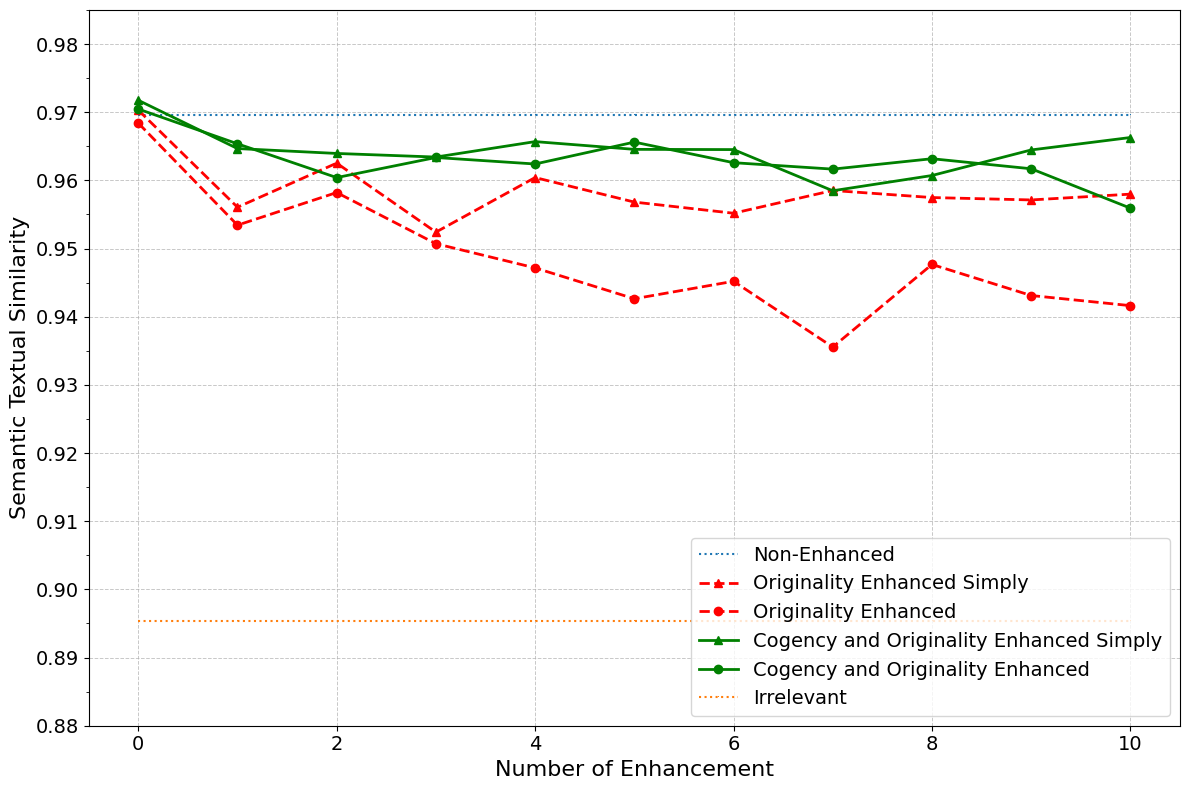

\begin{tabular}{llrrr}
\toprule
Method & Trend & p-value & z-score & Slope \\
\midrule
Originality Enhanced Simply & no trend & 0.6404 & -0.4671 & -0.0004 \\
Originality Enhanced & decreasing & 0.0051 & -2.8026 & -0.0021 \\
Cogency and Originality Enhanced Simply & no trend & 0.3502 & -0.9342 & -0.0002 \\
Cogency and Originality Enhanced & no trend & 0.0617 & -1.8684 & -0.0008 \\
\bottomrule
\end{tabular}



,Method,Trend,p-value,z-score,Slope
0,Originality Enhanced Simply,no trend,0.640429,-0.467099,-0.000406
1,Originality Enhanced,decreasing,0.005069,-2.802596,-0.002090
2,Cogency and Originality Enhanced Simply,no trend,0.350201,-0.934199,-0.000244
3,Cogency and Originality Enhanced,no trend,0.061707,-1.868397,-0.000812


In [ ]:
import math
from matplotlib.ticker import MaxNLocator

similarities_x_normal = [simple_similarities_original_normal, similarities_original_normal, simple_similarities_cogentoriginal_normal, similarities_cogentoriginal_normal]

for similarities in similarities_x_normal:
  print(similarities)
  print(mk.original_test(similarities))

plt.figure(figsize=(12, 8))  # Create a larger figure for clarity

# Plot each similarity curve
plt.plot(
    similarities_normal_normal,
    marker=',', linestyle=':', label='Non-Enhanced', linewidth=1.5
)
plt.plot(
    simple_similarities_original_normal,
    marker='^', linestyle='--', label='Originality Enhanced Simply', color='red',linewidth=2
)
plt.plot(
    similarities_original_normal,
    marker='o', linestyle='--', label='Originality Enhanced', color='red', linewidth=2
)
plt.plot(
    simple_similarities_cogentoriginal_normal,
    marker='^', linestyle='-', label='Cogency and Originality Enhanced Simply', color='green', linewidth=2
)
plt.plot(
    similarities_cogentoriginal_normal,
    marker='o', linestyle='-', label='Cogency and Originality Enhanced', color='green', linewidth=2
)
plt.plot(similarities_smolstich_normal, marker=',', linestyle=':', label='Irrelevant', linewidth=1.5)
# plt.annotate(f"Given the other claim in connectionist eliminativism: {math.ceil(similarities_smolstich_normal[0] * 100) / 100}", xy=(5, 0.95),fontsize=14,ha='center')

plt.ylim(0.88, 0.985)

plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=12))  # Increase major ticks
plt.gca().yaxis.set_minor_locator(MaxNLocator(nbins=24))  # Increase minor ticks


plt.tick_params(axis='both', which='major', labelsize=14)

# Add axis labels and title
plt.xlabel('Number of Enhancement', fontsize=16)
plt.ylabel('Semantic Textual Similarity', fontsize=16)
# Similarity to Non-Enahnced Outlines (gpt-4o-mini)

# Improve legend
plt.legend(fontsize=14, loc='lower right', frameon=True, title_fontsize=10)

# Add grid for readability
plt.grid(visible=True, linestyle='--', linewidth=0.7, alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# Mann-Kendall Test Results
results = {
    "Method": [
        "Originality Enhanced Simply",
        "Originality Enhanced",
        "Cogency and Originality Enhanced Simply",
        "Cogency and Originality Enhanced"
    ],
    "Trend": [
        mk.original_test(similarities).trend for similarities in similarities_x_normal
    ],
    "p-value": [
        mk.original_test(similarities).p for similarities in similarities_x_normal
    ],
    "z-score": [
        mk.original_test(similarities).z for similarities in similarities_x_normal
    ],
    "Slope": [
        mk.original_test(similarities).slope for similarities in similarities_x_normal
    ]
}

# Convert to DataFrame
df = pd.DataFrame(results)

# Generate LaTeX Table
latex_code = df.to_latex(index=False, float_format="%.4f")
print(latex_code)

# Display Table with Caption
df_styled = df.style.set_caption(
    "Mann-Kendall Test on STS to Non-Enhanced Outlines"
)

# Optionally display the styled table directly in notebooks
df_styled

[0.8019733459833085, 0.7962780211789289, 0.8011534021754287, 0.795338241899789, 0.7961201697797667, 0.7965311247469151, 0.7960411698922272, 0.7976132438714146, 0.7984429092752178, 0.8000916624131271, 0.796780223361358]
Mann_Kendall_Test(trend='no trend', h=False, p=0.8762696636277618, z=0.1556997888323046, Tau=0.05454545454545454, s=3.0, var_s=165.0, slope=5.580024249212606e-05, intercept=0.7965012221488974)
[0.8022366450443852, 0.7927852706565163, 0.79625011608969, 0.7932467423786391, 0.7928567678008638, 0.7879396924620651, 0.7910527169218365, 0.7841302185032986, 0.7901848641159174, 0.78540564546308, 0.7874562993730975]
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0050693095567015956, z=-2.8025961989814827, Tau=-0.6727272727272727, s=-37.0, var_s=165.0, slope=-0.0012993497919633612, intercept=0.7975494658816533)
[0.801447606297242, 0.7972744438592599, 0.8008726434257665, 0.8006902801352305, 0.8011126946119367, 0.7987262499638068, 0.8016678775836158, 0.7947784243583755, 0.79949084

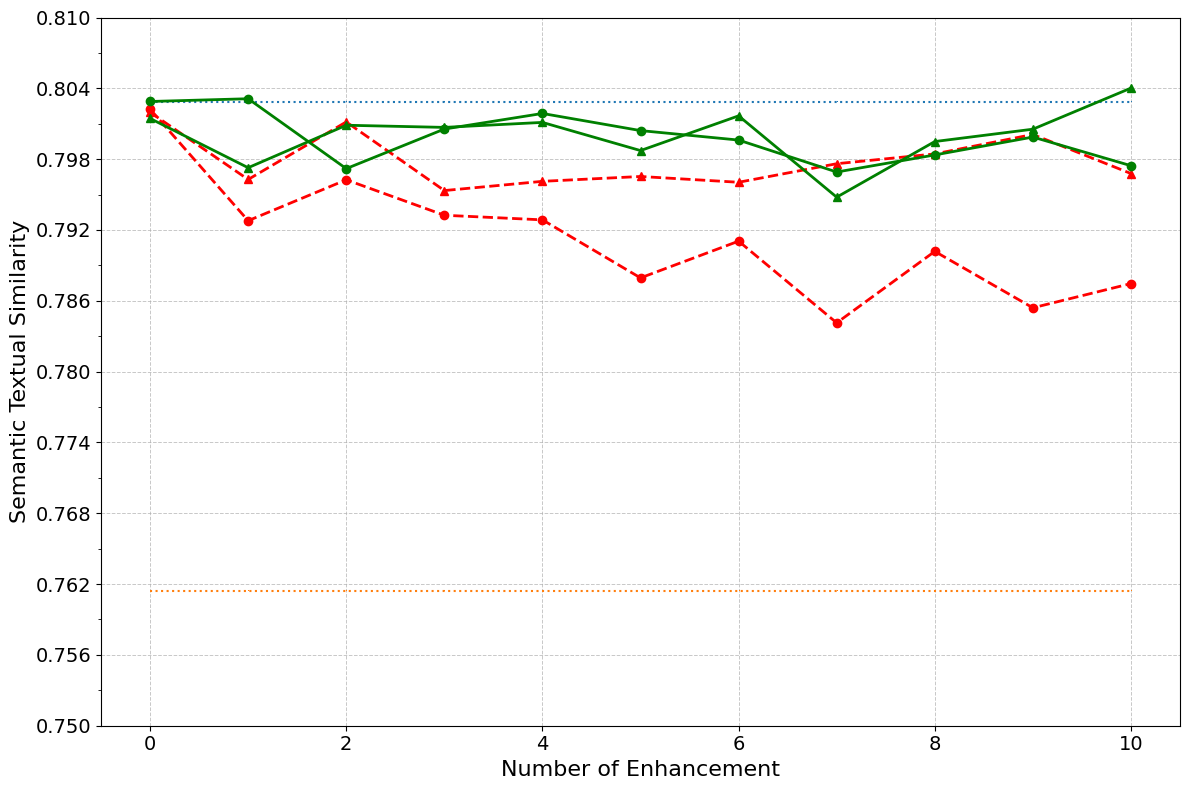

\begin{tabular}{llrrr}
\toprule
Method & Trend & p-value & z-score & Slope \\
\midrule
Originality Enhanced Simply & no trend & 0.8763 & 0.1557 & 0.0001 \\
Originality Enhanced & decreasing & 0.0051 & -2.8026 & -0.0013 \\
Cogency and Originality Enhanced Simply & no trend & 0.8763 & 0.1557 & 0.0001 \\
Cogency and Originality Enhanced & decreasing & 0.0430 & -2.0241 & -0.0005 \\
\bottomrule
\end{tabular}



,Method,Trend,p-value,z-score,Slope
0,Originality Enhanced Simply,no trend,0.876270,0.155700,0.000056
1,Originality Enhanced,decreasing,0.005069,-2.802596,-0.001299
2,Cogency and Originality Enhanced Simply,no trend,0.876270,0.155700,0.000120
3,Cogency and Originality Enhanced,decreasing,0.042960,-2.024097,-0.000493


In [ ]:
similarities_x_relevant = [simple_similarities_original_relevant, similarities_original_relevant, simple_similarities_cogentoriginal_relevant, similarities_cogentoriginal_relevant]

for similarities in similarities_x_relevant:
  print(similarities)
  print(mk.original_test(similarities))


plt.figure(figsize=(12, 8))  # Create a larger figure for clarity

# Plot each similarity curve
plt.plot(
    similarities_normal_relevant,
    marker=',', linestyle=':', label='Non-Enhanced', linewidth=1.5
)
plt.plot(
    simple_similarities_original_relevant,
    marker='^', linestyle='--', label='Originality Enhanced Simply', color='red', linewidth=2
)
plt.plot(
    similarities_original_relevant,
    marker='o', linestyle='--', label='Originality Enhanced', color='red', linewidth=2
)
plt.plot(
    simple_similarities_cogentoriginal_relevant,
    marker='^', linestyle='-', label='Cogency and Originality Enhanced Simply', color='green', linewidth=2
)

plt.plot(
    similarities_cogentoriginal_relevant,
    marker='o', linestyle='-', label='Cogency and Originality Enhanced', color='green', linewidth=2
)

plt.plot(similarities_chroom_relevant, marker=',', linestyle=':', label='Irrelevant', linewidth=1.5)

plt.ylim(0.75, 0.81)

plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=12))  # Increase major ticks
plt.gca().yaxis.set_minor_locator(MaxNLocator(nbins=24))  # Increase minor ticks


# plt.annotate(f"Irrelevant: {math.ceil(similarities_chroom_relevant[0] * 100) / 100}", xy=(1,0.78),fontsize=14,ha='center')

plt.tick_params(axis='both', which='major', labelsize=14)

# Add axis labels and title
plt.xlabel('Number of Enhancement', fontsize=16)
plt.ylabel('Semantic Textual Similarity', fontsize=16)

# Add grid for readability
plt.grid(visible=True, linestyle='--', linewidth=0.7, alpha=0.7)


# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# Mann-Kendall Test Results
results = {
    "Method": [
        "Originality Enhanced Simply",
        "Originality Enhanced",
        "Cogency and Originality Enhanced Simply",
        "Cogency and Originality Enhanced"
    ],
    "Trend": [
        mk.original_test(similarities).trend for similarities in similarities_x_relevant
    ],
    "p-value": [
        mk.original_test(similarities).p for similarities in similarities_x_relevant
    ],
    "z-score": [
        mk.original_test(similarities).z for similarities in similarities_x_relevant
    ],
    "Slope": [
        mk.original_test(similarities).slope for similarities in similarities_x_relevant
    ]
}

# Convert to DataFrame
df = pd.DataFrame(results)

# Generate LaTeX Table
latex_code = df.to_latex(index=False, float_format="%.4f")
print(latex_code)

# Display Table with Caption
df_styled = df.style.set_caption(
    "Mann-Kendall Test on Similarity to Outlines of the Relevant Existing Arguments"
)

# Optionally display the styled table directly in notebooks
df_styled

# Preparing and Analyzing Survey

## Collecting Argument Outlines for Survey

In [89]:
if False:
    outline_rsg = []
    gpt_model_title = "gpt-4o"
    for seed in [seeds[0], seeds[5]]:
        completion = client.chat.completions.create(
            model=gpt_model_title,
            store=True,
            messages=[
                {"role": "system", "content": outline_synthesis_instruction},
                {"role": "user", "content": outline_synthesis_input.format(list_existing_argument_texts[196])}
            ], # response_revised_existing_texts[196]
        )
        outline_rsg.append(completion.choices[0].message.content)

In [90]:
# @title
# gpt-4o: outline_rsg = ["**Main Claim:** *A significant class of connectionist models\*\* is incompatible with the propositional modularity\* of folk psychology.*\n\n**Reason (1):** These connectionist models encode information in a distributed manner across the network's connection weights and biases, rather than localizing representations of specific propositions or states. This distributed encoding makes it impossible to isolate and semantically evaluate individual propositions within the network, conflicting with the propositional modularity assumption of localized representations.\n\n**Reason (2):** The individual hidden units in these models are subsymbolic and lack clear symbolic interpretation. They do not represent specific environmental features or propositions, which means the models cannot accommodate the symbolic representations required by propositional modularity.\n\n**Reason (3):** These connectionist models are intended as cognitive models at the psychological level, not just as implementations of other models. They directly compete with traditional cognitive theories that assume propositional modularity, challenging its validity by offering alternative explanations of cognitive processes.", '**Main Claim:** *A significant class of connectionist models\*\* is incompatible with the propositional modularity\* of folk psychology.*\n\n**Reason (1):** Information in connectionist models is encoded in a distributed manner across connection weights and biases, rather than being localized to specific units. This lack of localized propositional representation makes it difficult to evaluate specific features or states, unlike in traditional models.\n\n**Reason (2):** Connectionist models employ subsymbolic representations, where no single unit symbolizes a specific feature. This contrasts with traditional models that use clear symbolic representations, posing challenges for aligning these models with propositional modularity.\n\n**Reason (3):** Connectionist models aim to be cognitive models, competing at the psychological explanatory level with traditional cognitive models, questioning the validity of propositional modularity within folk psychology. Their alignment with neural architectures suggests an alternative cognitive process story, distinct from symbolic models.']

# o1-preview:
# outline_rsg = ['**Main Claim:** *Certain connectionist cognitive models\*\*—those with widely distributed encoding, subsymbolic units, and intended as cognitive models—are incompatible with the propositional modularity\* assumed in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases, making it impossible to localize specific propositional representations within distinct parts of the system.\n\n**Reason (2):** The individual hidden units lack straightforward symbolic interpretation; they are subsymbolic, so propositions are represented holistically rather than through discrete symbolic units.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level, they compete with traditional models, directly challenging the propositional modularity of folk psychology by representing cognition in a fundamentally different way.', "**Main Claim:** *There exists a significant class of connectionist models,\*\* characterized by three specific properties, that are incompatible with the propositional modularity\* inherent in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases rather than localizing propositions to distinct parts of the network. This makes it impossible to isolate representations of particular propositions or states of affairs within the system, conflicting with the propositional modularity assumption.\n\n**Reason (2):** Individual hidden units in these networks are subsymbolic; they lack a straightforward symbolic interpretation and do not represent specific features or properties. The collective encoding of knowledge contrasts with the symbolic representation required by propositional modularity.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level (not merely implementations), they directly compete with traditional cognitive models. Their fundamental differences challenge the compatibility with folk psychology's propositional modularity."]

# o1
outline_rsg = ['**Main Claim:**  \n*A significant class of connectionist models\*\* is incompatible with the propositional modularity\* central to folk psychology.*\n\nReason (1):  \nBecause the encoding of propositions is widely distributed in weights, biases, and states, it becomes difficult or impossible to localize the representation of individual propositions. This distribution undermines the assumption that each proposition occupies a discrete module.\n\nReason (2):  \nSuch models often employ subsymbolic strategies, where hidden units lack direct semantic interpretation. Instead, the network as a whole encodes propositions, and no small set of units transparently corresponds to any single environmental feature.\n\nReason (3):  \nConnectionist models operate at the psychological level, competing with rather than merely implementing classical symbolic models, challenging propositional modularity.', '**Main Claim:**  \n*There exists a significant class of connectionist models\*\* that are incompatible with the propositional modularity\* assumed by folk psychology.*\n\nReason (1):  \nThese models encode information in a distributed manner across connection weights, biases, and hidden units, making it difficult to isolate and identify distinct propositions at any individual node or link.\n\nReason (2):  \nHidden units in these networks typically lack straightforward symbolic interpretations, resulting in a subsymbolic style of representation that does not align with the classical view of discrete symbolic constructs.\n\nReason (3):  \nBecause they function as models at the psychological (rather than merely neural) level, they compete with traditional propositional accounts and challenge the assumption that cognition relies on localized, symbol-based modules.']

In [91]:
if False:
    outline_clark = []
    for seed in [seeds[0], seeds[5]]:
        completion = client.chat.completions.create(
            model=gpt_model_title,
            store=True,
            messages=[
                {"role": "system", "content": outline_synthesis_instruction},
                {"role": "user", "content": outline_synthesis_input.format(list_existing_argument_texts[83])}
            ], # response_revised_existing_texts[83]
        )
        outline_clark.append(completion.choices[0].message.content)

In [92]:
# @title
# gpt-4o: outline_clark = ['**Main Claim:** *Contradicting eliminativist arguments, distributed sub-symbolic neural network models\*\* can account for individual beliefs being discretely active in causing behavior\* and other beliefs.*\n\n**Reason (1):** Cluster analysis enables the identification of higher-level patterns of hidden unit activations that correspond to specific beliefs. This allows us to untangle superpositional storage and attribute outputs to particular beliefs based on these activation clusters.\n\n**Reason (2):** Legitimate causal explanations can be provided by higher-level groupings of activation patterns, even if the underlying units and weights vary. This is analogous to different computers running the same software, where varied hardware can instantiate the same computational kind, supporting shared behaviors and error patterns.\n\n**Reason (3):** Activation patterns in hidden units can serve as discrete, causally potent belief states. By acknowledging that long-standing dispositions lead to specific activation clusters, we can maintain that beliefs have causal discretion in influencing actions, aligning with the requirements of folk psychology.', "**Main Claim:** *Distributed sub-symbolic models\*\* can accommodate individual beliefs as discrete causal\* agents in behavior and belief formation, countering eliminativism's argument.*\n\n**Reason (1):** Higher-level descriptions like cluster analysis can help identify beliefs as causally active states by associating hidden unit activation patterns with semantic labels, allowing for a nuanced understanding of belief states beyond simple unit-and-weight reductionism.\n\n**Reason (2):** Argument from natural kinds demonstrates that various connectionist networks can be grouped into psychological kinds despite low-level differences, indicating the legitimacy of attributing common belief states to diverse networks.\n\n**Reason (3):** The notion of recurrency in networks facilitates the role of beliefs in mediating between perception, action, and belief, thus enabling complex causal relationships where belief states can interact serially within the network."]

# o1-preview:
outline_clark = ["**Main Claim:** *Distributed, sub-symbolic connectionist models\*\* can account for the causal efficacy of individual beliefs by employing higher-level analyses like cluster analysis, thereby refuting eliminativist arguments that such models cannot support discrete, causally active\* beliefs.*\n\n**Reason (1):** Cluster analysis can untangle superpositional storage by grouping hidden unit activation patterns into meaningful clusters labeled with semantic content. This allows us to identify when a particular belief is active, as the network's activation falls into a specific cluster corresponding to that belief.\n\n**Reason (2):** Higher-level descriptions, despite underlying physical variations, can have causal efficacy. Just as different physical systems can instantiate the same computational or economic kinds, networks can be grouped into psychological kinds based on patterns of activation, supporting the causal role of beliefs.\n\n**Reason (3):** In recurrent networks, beliefs can cause other beliefs by cycling outputs back as inputs, resulting in a serial process where activation patterns corresponding to one belief lead to activation patterns of another. This accounts for the causal interaction between beliefs, aligning with folk psychology's expectations of discrete, causally active belief states.", '**Main Claim:** *Distributed sub-symbolic neural networks\*\* can accommodate individual beliefs as discretely active causes\* of behavior, refuting the eliminativist argument that such networks cannot support attributions of specific beliefs causing actions.*\n\n**Reason (1):** Cluster analysis of hidden unit activations allows labeling clusters with semantic entities, enabling the attribution of specific beliefs causing outputs despite distributed superpositional storage.\n\n**Reason (2):** Higher-level descriptions group different networks into psychological kinds, providing legitimate causal explanations and preserving belief efficacy, similar to higher-level groupings in other sciences like chemistry.\n\n**Reason (3):** Recurrent networks model belief-to-belief causation through serial activation patterns, addressing concerns about transient activation states and supporting discrete causal roles for individual beliefs over time.']

# o1
# outline_clark = ['**Main Claim:**  \n*The possibility of cluster analysis in distributed sub-symbolic networks\*\* shows that individual beliefs can still function as discrete, causally active states\*, countering the eliminativist conclusion that superpositional storage necessarily invalidates beliefs.*\n\nReason (1):  \nCluster analysis can isolate higher-level patterns in hidden unit activations that correspond to specific semantic contents, thus dismantling the direct link between distributed storage and eliminativism.\n\nReason (2):  \nSeparate clusters of activations, tied to different long-standing dispositions, preserve the notion of distinct beliefs within one network, showing that sub-symbolic architectures can sustain multiple beliefs with discernible causal roles.\n\nReason (3):  \nRecurrent processing enables the output from one belief to serve as input for another, allowing multi-step reasoning and lemma-beliefs. This validates discrete, successive activations in connectionist belief attributions and supports complex inferences without sacrificing the separation of belief states.', '**Main Claim:**  \n*Distributed, sub-symbolic connectionist models\*\* can still accommodate discrete beliefs with genuine causal efficacy,\* thereby undermining eliminativist arguments that seek to abolish folk-psychological notions of belief.*\n\nReason (1):  \nCluster analysis can reveal stable groupings of hidden unit activations that correspond to meaningful semantic categories, countering the superpositional storage objection by allowing certain patterns to be labeled as specific beliefs.\n\nReason (2):  \nHigher-level groupings are common in science (e.g., chemistry, economics), so networks that look dissimilar at the weight level can still belong to the same psychological kind, preserving explanatory usefulness.\n\nReason (3):  \nEven though activations are transient and multiple beliefs might yield the same action, distinct clusters show that different inputs trigger separate dispositions, preserving belief individuation.\n\nReason (4):  \nRecurrent networks handle sequential inferences by feeding prior outputs back as inputs, allowing one activated belief to cause another belief (lemma-belief) before ultimately causing behavior.']

In [93]:
# 1) Put each type’s items in a list of tuples (content, label)
normal = [
    (a_response_listlist_normal_outline[0][2], "normal1"),
    (a_response_listlist_normal_outline[0][3], "normal2"),
]
original = [
    (response_listlist_original_outline[0][5], "original1"),
    (response_listlist_original_outline[1][10], "original2"),
]
cogentoriginal = [
    (response_listlist_cogentoriginal_outline[2][5], "cogentoriginal1"),
    (response_listlist_cogentoriginal_outline[3][10], "cogentoriginal2"),
]
rsg = [
    (outline_rsg[0], "rsg1"),
    (outline_rsg[1], "rsg2"),
]

# 2) Arrange types in a list to preserve order
types = [
    ("normal", normal),
    ("original", original),
    ("cogentoriginal", cogentoriginal),
    ("rsg", rsg),
]

rsg_comparison_pairs = []
# 3) Get all combinations of two distinct types (in order)
for (type_a, items_a), (type_b, items_b) in itertools.combinations(types, 2):
    # 4) For each pair of items from these two types...
    for item_a, item_b in itertools.product(items_a, items_b):
        # 5) Randomize their positions in the final pair
        pair = [item_a, item_b]
        random.shuffle(pair)
        rsg_comparison_pairs.append(tuple(pair))

# all_pairs now has 24 items, each is a 2-tuple like:
# ( (content, label), (content, label) ), but in random order within each pair.

print(len(rsg_comparison_pairs))  # should be 24

24


In [94]:
# @title
rsg_comparison_pairs = [(('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** In connectionist models, cognitive content arises from the global activation patterns across the entire network, meaning that representations are inherently non-localizable and cannot be pinned to specific units or substructures. This holistic nature of representation conflicts with propositional modularity, which requires that discrete propositional attitudes be associated with distinct, functionally independent modules. Since connectionist models do not support the assignment of specific propositional content to isolated parts of the system, they are incompatible with the modular approach that depends on such localization.\n\n**Reason (2):** Connectionist models undermine the traditional separation between memory storage and information processing found in propositional modularity. In these networks, the same distributed connections simultaneously store information and perform computations, blurring the lines between where knowledge resides and how it is manipulated. Propositional modularity, on the other hand, relies on distinct modules that separately handle storage and processing of propositional attitudes. This fundamental difference in how cognitive functions are organized indicates that connectionist models cannot be reconciled with the modular framework.',
   'original1'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models rely on distributed representations where information is encoded across patterns of activation throughout the network. This means there are no functionally discrete units that correspond to specific propositional attitudes. In contrast, propositional modularity assumes that beliefs and desires are distinct modules that independently influence behavior. The lack of discrete, localized representations in connectionist models makes them incompatible with the idea that propositional attitudes are functionally discrete entities.\n\n**Reason (2):** Propositional modularity holds that propositional attitudes are semantically interpretable—they have clear, distinct meanings that can be understood and analyzed. Connectionist models, however, process information through numerous simple units whose individual activations do not have explicit semantic content. The meanings emerge only from the overall pattern of activations, which lacks direct interpretability. This absence of semantically interpretable components in connectionist models conflicts with the requirement of semantic interpretability in propositional modularity.\n\n**Reason (3):** In the framework of propositional modularity, each propositional attitude plays a specific causal role in generating behavior. For example, a particular desire can be identified as the cause of a specific action. Connectionist models, on the other hand, produce outputs based on the collective influence of many units and connections. The causal relationships are distributed and cannot be attributed to discrete modules corresponding to individual beliefs or desires. This distributed causality is incompatible with the notion that propositional attitudes have distinct causal roles in behavior.',
   'normal1')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity assumes cognitive modules are stable entities with fixed functions that operate independently within the mind. In contrast, connectionist models exhibit highly integrated networks where functions emerge from the interactions of numerous interconnected units. This interconnectedness means that alterations in one part of the network can unpredictably influence multiple functions, lacking the stability and independence of discrete modules. The inherent sensitivity and entanglement in connectionist architectures make them incompatible with the notion of stable, functionally isolated modules required by propositional modularity.\n\n**Reason (2):** Propositional modularity posits that cognitive modules have specific, evolutionarily fixed roles. Connectionist models, however, feature adaptable networks where functional roles are not predetermined but emerge through learning and experience. This plasticity allows the network to reorganize and reassign functional responsibilities dynamically. Such reconfigurable functional architecture conflicts with the fixed roles assumed in propositional modularity, indicating an incompatibility between the frameworks in terms of how cognitive functions are assigned and maintained.',
   'original2'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models rely on distributed representations where information is encoded across patterns of activation throughout the network. This means there are no functionally discrete units that correspond to specific propositional attitudes. In contrast, propositional modularity assumes that beliefs and desires are distinct modules that independently influence behavior. The lack of discrete, localized representations in connectionist models makes them incompatible with the idea that propositional attitudes are functionally discrete entities.\n\n**Reason (2):** Propositional modularity holds that propositional attitudes are semantically interpretable—they have clear, distinct meanings that can be understood and analyzed. Connectionist models, however, process information through numerous simple units whose individual activations do not have explicit semantic content. The meanings emerge only from the overall pattern of activations, which lacks direct interpretability. This absence of semantically interpretable components in connectionist models conflicts with the requirement of semantic interpretability in propositional modularity.\n\n**Reason (3):** In the framework of propositional modularity, each propositional attitude plays a specific causal role in generating behavior. For example, a particular desire can be identified as the cause of a specific action. Connectionist models, on the other hand, produce outputs based on the collective influence of many units and connections. The causal relationships are distributed and cannot be attributed to discrete modules corresponding to individual beliefs or desires. This distributed causality is incompatible with the notion that propositional attitudes have distinct causal roles in behavior.',
   'normal1')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** In connectionist models, cognitive content arises from the global activation patterns across the entire network, meaning that representations are inherently non-localizable and cannot be pinned to specific units or substructures. This holistic nature of representation conflicts with propositional modularity, which requires that discrete propositional attitudes be associated with distinct, functionally independent modules. Since connectionist models do not support the assignment of specific propositional content to isolated parts of the system, they are incompatible with the modular approach that depends on such localization.\n\n**Reason (2):** Connectionist models undermine the traditional separation between memory storage and information processing found in propositional modularity. In these networks, the same distributed connections simultaneously store information and perform computations, blurring the lines between where knowledge resides and how it is manipulated. Propositional modularity, on the other hand, relies on distinct modules that separately handle storage and processing of propositional attitudes. This fundamental difference in how cognitive functions are organized indicates that connectionist models cannot be reconciled with the modular framework.',
   'original1'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models lack the functional discreteness required by propositional modularity. In these models, representations are distributed across numerous units and connections, making it difficult to identify distinct modules corresponding to specific beliefs or desires. This contrasts with the modular nature of propositional attitudes, which are seen as separate, functionally independent states.\n\n**Reason (2):** The internal states of connectionist models are not semantically interpretable in a straightforward manner. Meaning emerges from complex patterns of activation, which cannot be easily mapped onto specific propositional content. Propositional modularity, however, relies on attitudes having clear semantic content that influences behavior.\n\n**Reason (3):** Connectionist models do not assign causal roles to individual units or representations; instead, behavior results from the collective dynamics of the network. Propositional modularity requires that distinct attitudes have specific causal impacts on actions, which is incompatible with the distributed and holistic processing of connectionist systems.',
   'normal2')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models lack the functional discreteness required by propositional modularity. In these models, representations are distributed across numerous units and connections, making it difficult to identify distinct modules corresponding to specific beliefs or desires. This contrasts with the modular nature of propositional attitudes, which are seen as separate, functionally independent states.\n\n**Reason (2):** The internal states of connectionist models are not semantically interpretable in a straightforward manner. Meaning emerges from complex patterns of activation, which cannot be easily mapped onto specific propositional content. Propositional modularity, however, relies on attitudes having clear semantic content that influences behavior.\n\n**Reason (3):** Connectionist models do not assign causal roles to individual units or representations; instead, behavior results from the collective dynamics of the network. Propositional modularity requires that distinct attitudes have specific causal impacts on actions, which is incompatible with the distributed and holistic processing of connectionist systems.',
   'normal2'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity assumes cognitive modules are stable entities with fixed functions that operate independently within the mind. In contrast, connectionist models exhibit highly integrated networks where functions emerge from the interactions of numerous interconnected units. This interconnectedness means that alterations in one part of the network can unpredictably influence multiple functions, lacking the stability and independence of discrete modules. The inherent sensitivity and entanglement in connectionist architectures make them incompatible with the notion of stable, functionally isolated modules required by propositional modularity.\n\n**Reason (2):** Propositional modularity posits that cognitive modules have specific, evolutionarily fixed roles. Connectionist models, however, feature adaptable networks where functional roles are not predetermined but emerge through learning and experience. This plasticity allows the network to reorganize and reassign functional responsibilities dynamically. Such reconfigurable functional architecture conflicts with the fixed roles assumed in propositional modularity, indicating an incompatibility between the frameworks in terms of how cognitive functions are assigned and maintained.',
   'original2')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models exhibit emergent cognitive abilities arising from the dynamic interactions of numerous simple units. These emergent properties cannot be decomposed into discrete, functionally independent propositional attitudes as required by propositional modularity. The inability to map emergent, distributed processes onto distinct modules of propositional attitudes indicates an incompatibility between the two frameworks.\n\n**Reason (2):** Connectionist networks naturally process information in probabilistic and statistical ways, capturing patterns and regularities from experience. Propositional modularity, with its reliance on fixed, deterministic propositional attitudes, cannot easily accommodate this probabilistic processing. The fundamental difference in how uncertainty and variability are handled suggests that propositional modularity is incompatible with the inherently adaptive and statistical nature of connectionist models.',
   'cogentoriginal1'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models rely on distributed representations where information is encoded across patterns of activation throughout the network. This means there are no functionally discrete units that correspond to specific propositional attitudes. In contrast, propositional modularity assumes that beliefs and desires are distinct modules that independently influence behavior. The lack of discrete, localized representations in connectionist models makes them incompatible with the idea that propositional attitudes are functionally discrete entities.\n\n**Reason (2):** Propositional modularity holds that propositional attitudes are semantically interpretable—they have clear, distinct meanings that can be understood and analyzed. Connectionist models, however, process information through numerous simple units whose individual activations do not have explicit semantic content. The meanings emerge only from the overall pattern of activations, which lacks direct interpretability. This absence of semantically interpretable components in connectionist models conflicts with the requirement of semantic interpretability in propositional modularity.\n\n**Reason (3):** In the framework of propositional modularity, each propositional attitude plays a specific causal role in generating behavior. For example, a particular desire can be identified as the cause of a specific action. Connectionist models, on the other hand, produce outputs based on the collective influence of many units and connections. The causal relationships are distributed and cannot be attributed to discrete modules corresponding to individual beliefs or desires. This distributed causality is incompatible with the notion that propositional attitudes have distinct causal roles in behavior.',
   'normal1')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models rely on distributed representations where information is encoded across patterns of activation throughout the network. This means there are no functionally discrete units that correspond to specific propositional attitudes. In contrast, propositional modularity assumes that beliefs and desires are distinct modules that independently influence behavior. The lack of discrete, localized representations in connectionist models makes them incompatible with the idea that propositional attitudes are functionally discrete entities.\n\n**Reason (2):** Propositional modularity holds that propositional attitudes are semantically interpretable—they have clear, distinct meanings that can be understood and analyzed. Connectionist models, however, process information through numerous simple units whose individual activations do not have explicit semantic content. The meanings emerge only from the overall pattern of activations, which lacks direct interpretability. This absence of semantically interpretable components in connectionist models conflicts with the requirement of semantic interpretability in propositional modularity.\n\n**Reason (3):** In the framework of propositional modularity, each propositional attitude plays a specific causal role in generating behavior. For example, a particular desire can be identified as the cause of a specific action. Connectionist models, on the other hand, produce outputs based on the collective influence of many units and connections. The causal relationships are distributed and cannot be attributed to discrete modules corresponding to individual beliefs or desires. This distributed causality is incompatible with the notion that propositional attitudes have distinct causal roles in behavior.',
   'normal1'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity presupposes that cognitive systems can represent propositional attitudes with unbounded and precise content, including abstract concepts and complex propositions. Connectionist models, constrained by finite network capacities and distributed numerical representations, struggle to encode highly abstract or infinitely precise propositional content. This limitation in representational capacity suggests an incompatibility between connectionist models and the requirements of propositional modularity.\n\n**Reason (2):** Propositional modularity accounts for the opacity of propositional attitudes, where substituting co-referential terms within an attitude can alter its truth value. Connectionist models, which rely on distributed representations without explicit symbolic references, cannot naturally represent the fine-grained distinctions required for propositional attitude opacity. This inability to handle the subtle semantic differences inherent in propositional attitudes indicates an incompatibility between connectionist models and propositional modularity.',
   'cogentoriginal2')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models lack the functional discreteness required by propositional modularity. In these models, representations are distributed across numerous units and connections, making it difficult to identify distinct modules corresponding to specific beliefs or desires. This contrasts with the modular nature of propositional attitudes, which are seen as separate, functionally independent states.\n\n**Reason (2):** The internal states of connectionist models are not semantically interpretable in a straightforward manner. Meaning emerges from complex patterns of activation, which cannot be easily mapped onto specific propositional content. Propositional modularity, however, relies on attitudes having clear semantic content that influences behavior.\n\n**Reason (3):** Connectionist models do not assign causal roles to individual units or representations; instead, behavior results from the collective dynamics of the network. Propositional modularity requires that distinct attitudes have specific causal impacts on actions, which is incompatible with the distributed and holistic processing of connectionist systems.',
   'normal2'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models exhibit emergent cognitive abilities arising from the dynamic interactions of numerous simple units. These emergent properties cannot be decomposed into discrete, functionally independent propositional attitudes as required by propositional modularity. The inability to map emergent, distributed processes onto distinct modules of propositional attitudes indicates an incompatibility between the two frameworks.\n\n**Reason (2):** Connectionist networks naturally process information in probabilistic and statistical ways, capturing patterns and regularities from experience. Propositional modularity, with its reliance on fixed, deterministic propositional attitudes, cannot easily accommodate this probabilistic processing. The fundamental difference in how uncertainty and variability are handled suggests that propositional modularity is incompatible with the inherently adaptive and statistical nature of connectionist models.',
   'cogentoriginal1')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models lack the functional discreteness required by propositional modularity. In these models, representations are distributed across numerous units and connections, making it difficult to identify distinct modules corresponding to specific beliefs or desires. This contrasts with the modular nature of propositional attitudes, which are seen as separate, functionally independent states.\n\n**Reason (2):** The internal states of connectionist models are not semantically interpretable in a straightforward manner. Meaning emerges from complex patterns of activation, which cannot be easily mapped onto specific propositional content. Propositional modularity, however, relies on attitudes having clear semantic content that influences behavior.\n\n**Reason (3):** Connectionist models do not assign causal roles to individual units or representations; instead, behavior results from the collective dynamics of the network. Propositional modularity requires that distinct attitudes have specific causal impacts on actions, which is incompatible with the distributed and holistic processing of connectionist systems.',
   'normal2'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity presupposes that cognitive systems can represent propositional attitudes with unbounded and precise content, including abstract concepts and complex propositions. Connectionist models, constrained by finite network capacities and distributed numerical representations, struggle to encode highly abstract or infinitely precise propositional content. This limitation in representational capacity suggests an incompatibility between connectionist models and the requirements of propositional modularity.\n\n**Reason (2):** Propositional modularity accounts for the opacity of propositional attitudes, where substituting co-referential terms within an attitude can alter its truth value. Connectionist models, which rely on distributed representations without explicit symbolic references, cannot naturally represent the fine-grained distinctions required for propositional attitude opacity. This inability to handle the subtle semantic differences inherent in propositional attitudes indicates an incompatibility between connectionist models and propositional modularity.',
   'cogentoriginal2')),
 (('**Main Claim:** *Certain connectionist cognitive models\\*\\*—those with widely distributed encoding, subsymbolic units, and intended as cognitive models—are incompatible with the propositional modularity\\* assumed in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases, making it impossible to localize specific propositional representations within distinct parts of the system.\n\n**Reason (2):** The individual hidden units lack straightforward symbolic interpretation; they are subsymbolic, so propositions are represented holistically rather than through discrete symbolic units.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level, they compete with traditional models, directly challenging the propositional modularity of folk psychology by representing cognition in a fundamentally different way.',
   'rsg1'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models rely on distributed representations where information is encoded across patterns of activation throughout the network. This means there are no functionally discrete units that correspond to specific propositional attitudes. In contrast, propositional modularity assumes that beliefs and desires are distinct modules that independently influence behavior. The lack of discrete, localized representations in connectionist models makes them incompatible with the idea that propositional attitudes are functionally discrete entities.\n\n**Reason (2):** Propositional modularity holds that propositional attitudes are semantically interpretable—they have clear, distinct meanings that can be understood and analyzed. Connectionist models, however, process information through numerous simple units whose individual activations do not have explicit semantic content. The meanings emerge only from the overall pattern of activations, which lacks direct interpretability. This absence of semantically interpretable components in connectionist models conflicts with the requirement of semantic interpretability in propositional modularity.\n\n**Reason (3):** In the framework of propositional modularity, each propositional attitude plays a specific causal role in generating behavior. For example, a particular desire can be identified as the cause of a specific action. Connectionist models, on the other hand, produce outputs based on the collective influence of many units and connections. The causal relationships are distributed and cannot be attributed to discrete modules corresponding to individual beliefs or desires. This distributed causality is incompatible with the notion that propositional attitudes have distinct causal roles in behavior.',
   'normal1')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models rely on distributed representations where information is encoded across patterns of activation throughout the network. This means there are no functionally discrete units that correspond to specific propositional attitudes. In contrast, propositional modularity assumes that beliefs and desires are distinct modules that independently influence behavior. The lack of discrete, localized representations in connectionist models makes them incompatible with the idea that propositional attitudes are functionally discrete entities.\n\n**Reason (2):** Propositional modularity holds that propositional attitudes are semantically interpretable—they have clear, distinct meanings that can be understood and analyzed. Connectionist models, however, process information through numerous simple units whose individual activations do not have explicit semantic content. The meanings emerge only from the overall pattern of activations, which lacks direct interpretability. This absence of semantically interpretable components in connectionist models conflicts with the requirement of semantic interpretability in propositional modularity.\n\n**Reason (3):** In the framework of propositional modularity, each propositional attitude plays a specific causal role in generating behavior. For example, a particular desire can be identified as the cause of a specific action. Connectionist models, on the other hand, produce outputs based on the collective influence of many units and connections. The causal relationships are distributed and cannot be attributed to discrete modules corresponding to individual beliefs or desires. This distributed causality is incompatible with the notion that propositional attitudes have distinct causal roles in behavior.',
   'normal1'),
  ("**Main Claim:** *There exists a significant class of connectionist models,\\*\\* characterized by three specific properties, that are incompatible with the propositional modularity\\* inherent in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases rather than localizing propositions to distinct parts of the network. This makes it impossible to isolate representations of particular propositions or states of affairs within the system, conflicting with the propositional modularity assumption.\n\n**Reason (2):** Individual hidden units in these networks are subsymbolic; they lack a straightforward symbolic interpretation and do not represent specific features or properties. The collective encoding of knowledge contrasts with the symbolic representation required by propositional modularity.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level (not merely implementations), they directly compete with traditional cognitive models. Their fundamental differences challenge the compatibility with folk psychology's propositional modularity.",
   'rsg2')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models lack the functional discreteness required by propositional modularity. In these models, representations are distributed across numerous units and connections, making it difficult to identify distinct modules corresponding to specific beliefs or desires. This contrasts with the modular nature of propositional attitudes, which are seen as separate, functionally independent states.\n\n**Reason (2):** The internal states of connectionist models are not semantically interpretable in a straightforward manner. Meaning emerges from complex patterns of activation, which cannot be easily mapped onto specific propositional content. Propositional modularity, however, relies on attitudes having clear semantic content that influences behavior.\n\n**Reason (3):** Connectionist models do not assign causal roles to individual units or representations; instead, behavior results from the collective dynamics of the network. Propositional modularity requires that distinct attitudes have specific causal impacts on actions, which is incompatible with the distributed and holistic processing of connectionist systems.',
   'normal2'),
  ('**Main Claim:** *Certain connectionist cognitive models\\*\\*—those with widely distributed encoding, subsymbolic units, and intended as cognitive models—are incompatible with the propositional modularity\\* assumed in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases, making it impossible to localize specific propositional representations within distinct parts of the system.\n\n**Reason (2):** The individual hidden units lack straightforward symbolic interpretation; they are subsymbolic, so propositions are represented holistically rather than through discrete symbolic units.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level, they compete with traditional models, directly challenging the propositional modularity of folk psychology by representing cognition in a fundamentally different way.',
   'rsg1')),
 (("**Main Claim:** *There exists a significant class of connectionist models,\\*\\* characterized by three specific properties, that are incompatible with the propositional modularity\\* inherent in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases rather than localizing propositions to distinct parts of the network. This makes it impossible to isolate representations of particular propositions or states of affairs within the system, conflicting with the propositional modularity assumption.\n\n**Reason (2):** Individual hidden units in these networks are subsymbolic; they lack a straightforward symbolic interpretation and do not represent specific features or properties. The collective encoding of knowledge contrasts with the symbolic representation required by propositional modularity.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level (not merely implementations), they directly compete with traditional cognitive models. Their fundamental differences challenge the compatibility with folk psychology's propositional modularity.",
   'rsg2'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models lack the functional discreteness required by propositional modularity. In these models, representations are distributed across numerous units and connections, making it difficult to identify distinct modules corresponding to specific beliefs or desires. This contrasts with the modular nature of propositional attitudes, which are seen as separate, functionally independent states.\n\n**Reason (2):** The internal states of connectionist models are not semantically interpretable in a straightforward manner. Meaning emerges from complex patterns of activation, which cannot be easily mapped onto specific propositional content. Propositional modularity, however, relies on attitudes having clear semantic content that influences behavior.\n\n**Reason (3):** Connectionist models do not assign causal roles to individual units or representations; instead, behavior results from the collective dynamics of the network. Propositional modularity requires that distinct attitudes have specific causal impacts on actions, which is incompatible with the distributed and holistic processing of connectionist systems.',
   'normal2')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models exhibit emergent cognitive abilities arising from the dynamic interactions of numerous simple units. These emergent properties cannot be decomposed into discrete, functionally independent propositional attitudes as required by propositional modularity. The inability to map emergent, distributed processes onto distinct modules of propositional attitudes indicates an incompatibility between the two frameworks.\n\n**Reason (2):** Connectionist networks naturally process information in probabilistic and statistical ways, capturing patterns and regularities from experience. Propositional modularity, with its reliance on fixed, deterministic propositional attitudes, cannot easily accommodate this probabilistic processing. The fundamental difference in how uncertainty and variability are handled suggests that propositional modularity is incompatible with the inherently adaptive and statistical nature of connectionist models.',
   'cogentoriginal1'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** In connectionist models, cognitive content arises from the global activation patterns across the entire network, meaning that representations are inherently non-localizable and cannot be pinned to specific units or substructures. This holistic nature of representation conflicts with propositional modularity, which requires that discrete propositional attitudes be associated with distinct, functionally independent modules. Since connectionist models do not support the assignment of specific propositional content to isolated parts of the system, they are incompatible with the modular approach that depends on such localization.\n\n**Reason (2):** Connectionist models undermine the traditional separation between memory storage and information processing found in propositional modularity. In these networks, the same distributed connections simultaneously store information and perform computations, blurring the lines between where knowledge resides and how it is manipulated. Propositional modularity, on the other hand, relies on distinct modules that separately handle storage and processing of propositional attitudes. This fundamental difference in how cognitive functions are organized indicates that connectionist models cannot be reconciled with the modular framework.',
   'original1')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** In connectionist models, cognitive content arises from the global activation patterns across the entire network, meaning that representations are inherently non-localizable and cannot be pinned to specific units or substructures. This holistic nature of representation conflicts with propositional modularity, which requires that discrete propositional attitudes be associated with distinct, functionally independent modules. Since connectionist models do not support the assignment of specific propositional content to isolated parts of the system, they are incompatible with the modular approach that depends on such localization.\n\n**Reason (2):** Connectionist models undermine the traditional separation between memory storage and information processing found in propositional modularity. In these networks, the same distributed connections simultaneously store information and perform computations, blurring the lines between where knowledge resides and how it is manipulated. Propositional modularity, on the other hand, relies on distinct modules that separately handle storage and processing of propositional attitudes. This fundamental difference in how cognitive functions are organized indicates that connectionist models cannot be reconciled with the modular framework.',
   'original1'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity presupposes that cognitive systems can represent propositional attitudes with unbounded and precise content, including abstract concepts and complex propositions. Connectionist models, constrained by finite network capacities and distributed numerical representations, struggle to encode highly abstract or infinitely precise propositional content. This limitation in representational capacity suggests an incompatibility between connectionist models and the requirements of propositional modularity.\n\n**Reason (2):** Propositional modularity accounts for the opacity of propositional attitudes, where substituting co-referential terms within an attitude can alter its truth value. Connectionist models, which rely on distributed representations without explicit symbolic references, cannot naturally represent the fine-grained distinctions required for propositional attitude opacity. This inability to handle the subtle semantic differences inherent in propositional attitudes indicates an incompatibility between connectionist models and propositional modularity.',
   'cogentoriginal2')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity assumes cognitive modules are stable entities with fixed functions that operate independently within the mind. In contrast, connectionist models exhibit highly integrated networks where functions emerge from the interactions of numerous interconnected units. This interconnectedness means that alterations in one part of the network can unpredictably influence multiple functions, lacking the stability and independence of discrete modules. The inherent sensitivity and entanglement in connectionist architectures make them incompatible with the notion of stable, functionally isolated modules required by propositional modularity.\n\n**Reason (2):** Propositional modularity posits that cognitive modules have specific, evolutionarily fixed roles. Connectionist models, however, feature adaptable networks where functional roles are not predetermined but emerge through learning and experience. This plasticity allows the network to reorganize and reassign functional responsibilities dynamically. Such reconfigurable functional architecture conflicts with the fixed roles assumed in propositional modularity, indicating an incompatibility between the frameworks in terms of how cognitive functions are assigned and maintained.',
   'original2'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models exhibit emergent cognitive abilities arising from the dynamic interactions of numerous simple units. These emergent properties cannot be decomposed into discrete, functionally independent propositional attitudes as required by propositional modularity. The inability to map emergent, distributed processes onto distinct modules of propositional attitudes indicates an incompatibility between the two frameworks.\n\n**Reason (2):** Connectionist networks naturally process information in probabilistic and statistical ways, capturing patterns and regularities from experience. Propositional modularity, with its reliance on fixed, deterministic propositional attitudes, cannot easily accommodate this probabilistic processing. The fundamental difference in how uncertainty and variability are handled suggests that propositional modularity is incompatible with the inherently adaptive and statistical nature of connectionist models.',
   'cogentoriginal1')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity assumes cognitive modules are stable entities with fixed functions that operate independently within the mind. In contrast, connectionist models exhibit highly integrated networks where functions emerge from the interactions of numerous interconnected units. This interconnectedness means that alterations in one part of the network can unpredictably influence multiple functions, lacking the stability and independence of discrete modules. The inherent sensitivity and entanglement in connectionist architectures make them incompatible with the notion of stable, functionally isolated modules required by propositional modularity.\n\n**Reason (2):** Propositional modularity posits that cognitive modules have specific, evolutionarily fixed roles. Connectionist models, however, feature adaptable networks where functional roles are not predetermined but emerge through learning and experience. This plasticity allows the network to reorganize and reassign functional responsibilities dynamically. Such reconfigurable functional architecture conflicts with the fixed roles assumed in propositional modularity, indicating an incompatibility between the frameworks in terms of how cognitive functions are assigned and maintained.',
   'original2'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity presupposes that cognitive systems can represent propositional attitudes with unbounded and precise content, including abstract concepts and complex propositions. Connectionist models, constrained by finite network capacities and distributed numerical representations, struggle to encode highly abstract or infinitely precise propositional content. This limitation in representational capacity suggests an incompatibility between connectionist models and the requirements of propositional modularity.\n\n**Reason (2):** Propositional modularity accounts for the opacity of propositional attitudes, where substituting co-referential terms within an attitude can alter its truth value. Connectionist models, which rely on distributed representations without explicit symbolic references, cannot naturally represent the fine-grained distinctions required for propositional attitude opacity. This inability to handle the subtle semantic differences inherent in propositional attitudes indicates an incompatibility between connectionist models and propositional modularity.',
   'cogentoriginal2')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** In connectionist models, cognitive content arises from the global activation patterns across the entire network, meaning that representations are inherently non-localizable and cannot be pinned to specific units or substructures. This holistic nature of representation conflicts with propositional modularity, which requires that discrete propositional attitudes be associated with distinct, functionally independent modules. Since connectionist models do not support the assignment of specific propositional content to isolated parts of the system, they are incompatible with the modular approach that depends on such localization.\n\n**Reason (2):** Connectionist models undermine the traditional separation between memory storage and information processing found in propositional modularity. In these networks, the same distributed connections simultaneously store information and perform computations, blurring the lines between where knowledge resides and how it is manipulated. Propositional modularity, on the other hand, relies on distinct modules that separately handle storage and processing of propositional attitudes. This fundamental difference in how cognitive functions are organized indicates that connectionist models cannot be reconciled with the modular framework.',
   'original1'),
  ('**Main Claim:** *Certain connectionist cognitive models\\*\\*—those with widely distributed encoding, subsymbolic units, and intended as cognitive models—are incompatible with the propositional modularity\\* assumed in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases, making it impossible to localize specific propositional representations within distinct parts of the system.\n\n**Reason (2):** The individual hidden units lack straightforward symbolic interpretation; they are subsymbolic, so propositions are represented holistically rather than through discrete symbolic units.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level, they compete with traditional models, directly challenging the propositional modularity of folk psychology by representing cognition in a fundamentally different way.',
   'rsg1')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** In connectionist models, cognitive content arises from the global activation patterns across the entire network, meaning that representations are inherently non-localizable and cannot be pinned to specific units or substructures. This holistic nature of representation conflicts with propositional modularity, which requires that discrete propositional attitudes be associated with distinct, functionally independent modules. Since connectionist models do not support the assignment of specific propositional content to isolated parts of the system, they are incompatible with the modular approach that depends on such localization.\n\n**Reason (2):** Connectionist models undermine the traditional separation between memory storage and information processing found in propositional modularity. In these networks, the same distributed connections simultaneously store information and perform computations, blurring the lines between where knowledge resides and how it is manipulated. Propositional modularity, on the other hand, relies on distinct modules that separately handle storage and processing of propositional attitudes. This fundamental difference in how cognitive functions are organized indicates that connectionist models cannot be reconciled with the modular framework.',
   'original1'),
  ("**Main Claim:** *There exists a significant class of connectionist models,\\*\\* characterized by three specific properties, that are incompatible with the propositional modularity\\* inherent in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases rather than localizing propositions to distinct parts of the network. This makes it impossible to isolate representations of particular propositions or states of affairs within the system, conflicting with the propositional modularity assumption.\n\n**Reason (2):** Individual hidden units in these networks are subsymbolic; they lack a straightforward symbolic interpretation and do not represent specific features or properties. The collective encoding of knowledge contrasts with the symbolic representation required by propositional modularity.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level (not merely implementations), they directly compete with traditional cognitive models. Their fundamental differences challenge the compatibility with folk psychology's propositional modularity.",
   'rsg2')),
 (('**Main Claim:** *Certain connectionist cognitive models\\*\\*—those with widely distributed encoding, subsymbolic units, and intended as cognitive models—are incompatible with the propositional modularity\\* assumed in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases, making it impossible to localize specific propositional representations within distinct parts of the system.\n\n**Reason (2):** The individual hidden units lack straightforward symbolic interpretation; they are subsymbolic, so propositions are represented holistically rather than through discrete symbolic units.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level, they compete with traditional models, directly challenging the propositional modularity of folk psychology by representing cognition in a fundamentally different way.',
   'rsg1'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity assumes cognitive modules are stable entities with fixed functions that operate independently within the mind. In contrast, connectionist models exhibit highly integrated networks where functions emerge from the interactions of numerous interconnected units. This interconnectedness means that alterations in one part of the network can unpredictably influence multiple functions, lacking the stability and independence of discrete modules. The inherent sensitivity and entanglement in connectionist architectures make them incompatible with the notion of stable, functionally isolated modules required by propositional modularity.\n\n**Reason (2):** Propositional modularity posits that cognitive modules have specific, evolutionarily fixed roles. Connectionist models, however, feature adaptable networks where functional roles are not predetermined but emerge through learning and experience. This plasticity allows the network to reorganize and reassign functional responsibilities dynamically. Such reconfigurable functional architecture conflicts with the fixed roles assumed in propositional modularity, indicating an incompatibility between the frameworks in terms of how cognitive functions are assigned and maintained.',
   'original2')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity assumes cognitive modules are stable entities with fixed functions that operate independently within the mind. In contrast, connectionist models exhibit highly integrated networks where functions emerge from the interactions of numerous interconnected units. This interconnectedness means that alterations in one part of the network can unpredictably influence multiple functions, lacking the stability and independence of discrete modules. The inherent sensitivity and entanglement in connectionist architectures make them incompatible with the notion of stable, functionally isolated modules required by propositional modularity.\n\n**Reason (2):** Propositional modularity posits that cognitive modules have specific, evolutionarily fixed roles. Connectionist models, however, feature adaptable networks where functional roles are not predetermined but emerge through learning and experience. This plasticity allows the network to reorganize and reassign functional responsibilities dynamically. Such reconfigurable functional architecture conflicts with the fixed roles assumed in propositional modularity, indicating an incompatibility between the frameworks in terms of how cognitive functions are assigned and maintained.',
   'original2'),
  ("**Main Claim:** *There exists a significant class of connectionist models,\\*\\* characterized by three specific properties, that are incompatible with the propositional modularity\\* inherent in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases rather than localizing propositions to distinct parts of the network. This makes it impossible to isolate representations of particular propositions or states of affairs within the system, conflicting with the propositional modularity assumption.\n\n**Reason (2):** Individual hidden units in these networks are subsymbolic; they lack a straightforward symbolic interpretation and do not represent specific features or properties. The collective encoding of knowledge contrasts with the symbolic representation required by propositional modularity.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level (not merely implementations), they directly compete with traditional cognitive models. Their fundamental differences challenge the compatibility with folk psychology's propositional modularity.",
   'rsg2')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models exhibit emergent cognitive abilities arising from the dynamic interactions of numerous simple units. These emergent properties cannot be decomposed into discrete, functionally independent propositional attitudes as required by propositional modularity. The inability to map emergent, distributed processes onto distinct modules of propositional attitudes indicates an incompatibility between the two frameworks.\n\n**Reason (2):** Connectionist networks naturally process information in probabilistic and statistical ways, capturing patterns and regularities from experience. Propositional modularity, with its reliance on fixed, deterministic propositional attitudes, cannot easily accommodate this probabilistic processing. The fundamental difference in how uncertainty and variability are handled suggests that propositional modularity is incompatible with the inherently adaptive and statistical nature of connectionist models.',
   'cogentoriginal1'),
  ('**Main Claim:** *Certain connectionist cognitive models\\*\\*—those with widely distributed encoding, subsymbolic units, and intended as cognitive models—are incompatible with the propositional modularity\\* assumed in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases, making it impossible to localize specific propositional representations within distinct parts of the system.\n\n**Reason (2):** The individual hidden units lack straightforward symbolic interpretation; they are subsymbolic, so propositions are represented holistically rather than through discrete symbolic units.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level, they compete with traditional models, directly challenging the propositional modularity of folk psychology by representing cognition in a fundamentally different way.',
   'rsg1')),
 (("**Main Claim:** *There exists a significant class of connectionist models,\\*\\* characterized by three specific properties, that are incompatible with the propositional modularity\\* inherent in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases rather than localizing propositions to distinct parts of the network. This makes it impossible to isolate representations of particular propositions or states of affairs within the system, conflicting with the propositional modularity assumption.\n\n**Reason (2):** Individual hidden units in these networks are subsymbolic; they lack a straightforward symbolic interpretation and do not represent specific features or properties. The collective encoding of knowledge contrasts with the symbolic representation required by propositional modularity.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level (not merely implementations), they directly compete with traditional cognitive models. Their fundamental differences challenge the compatibility with folk psychology's propositional modularity.",
   'rsg2'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models exhibit emergent cognitive abilities arising from the dynamic interactions of numerous simple units. These emergent properties cannot be decomposed into discrete, functionally independent propositional attitudes as required by propositional modularity. The inability to map emergent, distributed processes onto distinct modules of propositional attitudes indicates an incompatibility between the two frameworks.\n\n**Reason (2):** Connectionist networks naturally process information in probabilistic and statistical ways, capturing patterns and regularities from experience. Propositional modularity, with its reliance on fixed, deterministic propositional attitudes, cannot easily accommodate this probabilistic processing. The fundamental difference in how uncertainty and variability are handled suggests that propositional modularity is incompatible with the inherently adaptive and statistical nature of connectionist models.',
   'cogentoriginal1')),
 (('**Main Claim:** *Certain connectionist cognitive models\\*\\*—those with widely distributed encoding, subsymbolic units, and intended as cognitive models—are incompatible with the propositional modularity\\* assumed in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases, making it impossible to localize specific propositional representations within distinct parts of the system.\n\n**Reason (2):** The individual hidden units lack straightforward symbolic interpretation; they are subsymbolic, so propositions are represented holistically rather than through discrete symbolic units.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level, they compete with traditional models, directly challenging the propositional modularity of folk psychology by representing cognition in a fundamentally different way.',
   'rsg1'),
  ('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity presupposes that cognitive systems can represent propositional attitudes with unbounded and precise content, including abstract concepts and complex propositions. Connectionist models, constrained by finite network capacities and distributed numerical representations, struggle to encode highly abstract or infinitely precise propositional content. This limitation in representational capacity suggests an incompatibility between connectionist models and the requirements of propositional modularity.\n\n**Reason (2):** Propositional modularity accounts for the opacity of propositional attitudes, where substituting co-referential terms within an attitude can alter its truth value. Connectionist models, which rely on distributed representations without explicit symbolic references, cannot naturally represent the fine-grained distinctions required for propositional attitude opacity. This inability to handle the subtle semantic differences inherent in propositional attitudes indicates an incompatibility between connectionist models and propositional modularity.',
   'cogentoriginal2')),
 (('\n\n**Main Claim:** *Propositional modularity\\* is incompatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Propositional modularity presupposes that cognitive systems can represent propositional attitudes with unbounded and precise content, including abstract concepts and complex propositions. Connectionist models, constrained by finite network capacities and distributed numerical representations, struggle to encode highly abstract or infinitely precise propositional content. This limitation in representational capacity suggests an incompatibility between connectionist models and the requirements of propositional modularity.\n\n**Reason (2):** Propositional modularity accounts for the opacity of propositional attitudes, where substituting co-referential terms within an attitude can alter its truth value. Connectionist models, which rely on distributed representations without explicit symbolic references, cannot naturally represent the fine-grained distinctions required for propositional attitude opacity. This inability to handle the subtle semantic differences inherent in propositional attitudes indicates an incompatibility between connectionist models and propositional modularity.',
   'cogentoriginal2'),
  ("**Main Claim:** *There exists a significant class of connectionist models,\\*\\* characterized by three specific properties, that are incompatible with the propositional modularity\\* inherent in folk psychology.*\n\n**Reason (1):** These models encode information in a widely distributed manner across connection weights and biases rather than localizing propositions to distinct parts of the network. This makes it impossible to isolate representations of particular propositions or states of affairs within the system, conflicting with the propositional modularity assumption.\n\n**Reason (2):** Individual hidden units in these networks are subsymbolic; they lack a straightforward symbolic interpretation and do not represent specific features or properties. The collective encoding of knowledge contrasts with the symbolic representation required by propositional modularity.\n\n**Reason (3):** Since these models are intended as cognitive models at the psychological level (not merely implementations), they directly compete with traditional cognitive models. Their fundamental differences challenge the compatibility with folk psychology's propositional modularity.",
   'rsg2'))]

In [95]:

def split_main_claim_and_reasons(text):
    text = text.strip()
    match = re.search(r"\*?\*?Reason\s*(\(1\))?:\*?\*?", text)
    if match:
        split_index = match.start()
        main_claim_part = text[:split_index].strip()
        reasons_part = text[split_index:].strip()
    else:
        main_claim_part = text
        reasons_part = ""
    return main_claim_part, reasons_part

def markdown_to_html(md_text):
    html = markdown.markdown(md_text, extensions=["extra"])
    return html

def generate_html_tables(comparison_pairs):
    all_tables = []

    for idx, pair in enumerate(comparison_pairs):
        (textA, labelA), (textB, labelB) = pair
        A_main, A_reasons = split_main_claim_and_reasons(textA)
        B_main, B_reasons = split_main_claim_and_reasons(textB)

        A_main_html = markdown_to_html(A_main)
        A_reasons_html = markdown_to_html(A_reasons)
        B_main_html = markdown_to_html(B_main)
        B_reasons_html = markdown_to_html(B_reasons)

        table_html = f"""
<!-- Comparison Pair {idx + 1}: {labelA[0] + labelA[-1]} vs {labelB[0] + labelB[-1]} -->
<table border="1" cellpadding="1" cellspacing="1" style="width:800px;">
  <tbody>
    <tr>
      <td style="text-align: left;"><span style="font-size:16px;">
      {A_main_html}</span></td>
      <td style="text-align: left;"><span style="font-size:16px;">
      {B_main_html}</span></td>
    </tr>
    <tr>
      <td style="text-align: left;"><span style="font-size:16px;">
      {A_reasons_html}</span></td>
      <td style="text-align: left;"><span style="font-size:16px;">
      {B_reasons_html}</span></td>
    </tr>
  </tbody>
</table>
"""
        all_tables.append(table_html)

    return "\n\n".join(all_tables)

if __name__ == "__main__":

    final_html = generate_html_tables(rsg_comparison_pairs)

    print(final_html)

    # with open("output.html", "w", encoding="utf-8") as f:
    #     f.write(final_html)


<!-- Comparison Pair 1: o1 vs n1 -->
<table border="1" cellpadding="1" cellspacing="1" style="width:800px;">
  <tbody>
    <tr>
      <td style="text-align: left;"><span style="font-size:16px;">
      <p><strong>Main Claim:</strong> <em>Propositional modularity* is incompatible with connectionist models** of cognitive systems.</em></p></span></td>
      <td style="text-align: left;"><span style="font-size:16px;">
      <p><strong>Main Claim:</strong> <em>Propositional modularity* is incompatible with connectionist models** of cognitive systems.</em></p></span></td>
    </tr>
    <tr>
      <td style="text-align: left;"><span style="font-size:16px;">
      <p><strong>Reason (1):</strong> In connectionist models, cognitive content arises from the global activation patterns across the entire network, meaning that representations are inherently non-localizable and cannot be pinned to specific units or substructures. This holistic nature of representation conflicts with propositional modul

In [96]:
normal = [
    (a_response_listlist_normal_outline[1][2], "normal1"),
    (a_response_listlist_normal_outline[1][3], "normal2"),
]
original = [
    (response_listlist_original_outline[4][5], "original1"),
    (response_listlist_original_outline[5][10], "original2"),
]
cogentoriginal = [
    (response_listlist_cogentoriginal_outline[6][5], "cogentoriginal1"),
    (response_listlist_cogentoriginal_outline[7][10], "cogentoriginal2"),
]
clark = [
    (outline_clark[0], "kclark1"),
    (outline_clark[1], "kclark2"),
]

# 2) Arrange types in a list to preserve order
types = [
    ("normal", normal),
    ("original", original),
    ("cogentoriginal", cogentoriginal),
    ("kclark", clark),
]

clark_comparison_pairs = []
# 3) Get all combinations of two distinct types (in order)
for (type_a, items_a), (type_b, items_b) in itertools.combinations(types, 2):
    # 4) For each pair of items from these two types...
    for item_a, item_b in itertools.product(items_a, items_b):
        # 5) Randomize their positions in the final pair
        pair = [item_a, item_b]
        random.shuffle(pair)
        clark_comparison_pairs.append(tuple(pair))


print(len(clark_comparison_pairs))  # should be 24

24


In [97]:
# @title
clark_comparison_pairs = [(("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Incorporating hyperdimensional computing into connectionist models enables the formation of high-dimensional vectors where specific patterns represent functionally discrete beliefs. These patterns can causally influence the network's processing, demonstrating that discrete beliefs with causal roles can emerge within the distributed architecture of connectionist systems.\n\n**Reason (2):** Utilizing topological data analysis in connectionist models allows the extraction of persistent features that act as functionally discrete beliefs. These topological invariants influence the network's behavior causally, showing that such beliefs are compatible with and can naturally arise in connectionist architectures.",
   'original1'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can develop distinct activation patterns that correspond to specific beliefs, functioning as discrete units within the network. These patterns can causally influence the system's outputs, aligning with the idea of beliefs playing a causal role.\n\n**Reason (2):** The learning processes in connectionist systems can lead to the formation of specialized subnetworks that represent particular propositional attitudes. These subnetworks act functionally discrete and can independently affect behavior, making them compatible with the concept of modular beliefs.\n\n**Reason (3):** Despite their distributed nature, connectionist models can encode semantically interpretable information through their weighted connections. This allows for specific beliefs to be identified within the network, granting them a causal role consistent with propositional modularity.",
   'normal1')),
 (('\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason:** By integrating innovative architectures like hypernetworks into connectionist models, functionally discrete beliefs can be represented and play causal roles. Hypernetworks generate the parameters of a primary network based on contextual inputs, effectively encoding discrete belief states that influence processing. These belief-specific configurations determine how the primary network responds to inputs, allowing discrete beliefs to causally impact cognition within a connectionist framework. This approach demonstrates that connectionist models can accommodate functionally discrete beliefs through dynamic parameter generation, supporting their compatibility with beliefs that play causal roles in cognitive systems.',
   'original2'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can develop distinct activation patterns that correspond to specific beliefs, functioning as discrete units within the network. These patterns can causally influence the system's outputs, aligning with the idea of beliefs playing a causal role.\n\n**Reason (2):** The learning processes in connectionist systems can lead to the formation of specialized subnetworks that represent particular propositional attitudes. These subnetworks act functionally discrete and can independently affect behavior, making them compatible with the concept of modular beliefs.\n\n**Reason (3):** Despite their distributed nature, connectionist models can encode semantically interpretable information through their weighted connections. This allows for specific beliefs to be identified within the network, granting them a causal role consistent with propositional modularity.",
   'normal1')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Incorporating hyperdimensional computing into connectionist models enables the formation of high-dimensional vectors where specific patterns represent functionally discrete beliefs. These patterns can causally influence the network's processing, demonstrating that discrete beliefs with causal roles can emerge within the distributed architecture of connectionist systems.\n\n**Reason (2):** Utilizing topological data analysis in connectionist models allows the extraction of persistent features that act as functionally discrete beliefs. These topological invariants influence the network's behavior causally, showing that such beliefs are compatible with and can naturally arise in connectionist architectures.",
   'original1'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can produce emergent activation patterns that correspond to specific beliefs, functioning discretely within the network. These patterns can causally influence the system’s output, mirroring how discrete beliefs guide behavior in propositional modularity. Thus, even in a distributed architecture, functionally discrete beliefs can arise and play a causal role.\n\n**Reason (2):** Through learning, connectionist networks can develop specialized pathways where certain weights and connections become associated with specific beliefs. These specialized structures allow individual beliefs to independently affect the system's responses, demonstrating functional discreteness and causal efficacy within a connectionist framework.",
   'normal2')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can produce emergent activation patterns that correspond to specific beliefs, functioning discretely within the network. These patterns can causally influence the system’s output, mirroring how discrete beliefs guide behavior in propositional modularity. Thus, even in a distributed architecture, functionally discrete beliefs can arise and play a causal role.\n\n**Reason (2):** Through learning, connectionist networks can develop specialized pathways where certain weights and connections become associated with specific beliefs. These specialized structures allow individual beliefs to independently affect the system's responses, demonstrating functional discreteness and causal efficacy within a connectionist framework.",
   'normal2'),
  ('\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason:** By integrating innovative architectures like hypernetworks into connectionist models, functionally discrete beliefs can be represented and play causal roles. Hypernetworks generate the parameters of a primary network based on contextual inputs, effectively encoding discrete belief states that influence processing. These belief-specific configurations determine how the primary network responds to inputs, allowing discrete beliefs to causally impact cognition within a connectionist framework. This approach demonstrates that connectionist models can accommodate functionally discrete beliefs through dynamic parameter generation, supporting their compatibility with beliefs that play causal roles in cognitive systems.',
   'original2')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):**\n\nConnectionist models can exhibit emergent functional modularity, where patterns of distributed activations collectively form functionally discrete states akin to beliefs. These emergent states can causally influence the network's outputs by activating specific pathways that determine behavioral responses. This demonstrates that functionally discrete beliefs can arise within the dynamics of connectionist systems, aligning with the main claim of compatibility.\n\n**Reason (2):**\n\nAdvancements in neural network interpretability have enabled the identification of semantically meaningful activation patterns within connectionist models. Techniques like concept activation mapping allow us to isolate specific representations that correspond to discrete beliefs. These representations can causally affect the network's processing and outputs, showing that functionally discrete beliefs with causal roles can be accommodated within connectionist architectures.",
   'cogentoriginal1'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can develop distinct activation patterns that correspond to specific beliefs, functioning as discrete units within the network. These patterns can causally influence the system's outputs, aligning with the idea of beliefs playing a causal role.\n\n**Reason (2):** The learning processes in connectionist systems can lead to the formation of specialized subnetworks that represent particular propositional attitudes. These subnetworks act functionally discrete and can independently affect behavior, making them compatible with the concept of modular beliefs.\n\n**Reason (3):** Despite their distributed nature, connectionist models can encode semantically interpretable information through their weighted connections. This allows for specific beliefs to be identified within the network, granting them a causal role consistent with propositional modularity.",
   'normal1')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can develop distinct activation patterns that correspond to specific beliefs, functioning as discrete units within the network. These patterns can causally influence the system's outputs, aligning with the idea of beliefs playing a causal role.\n\n**Reason (2):** The learning processes in connectionist systems can lead to the formation of specialized subnetworks that represent particular propositional attitudes. These subnetworks act functionally discrete and can independently affect behavior, making them compatible with the concept of modular beliefs.\n\n**Reason (3):** Despite their distributed nature, connectionist models can encode semantically interpretable information through their weighted connections. This allows for specific beliefs to be identified within the network, granting them a causal role consistent with propositional modularity.",
   'normal1'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can employ mechanisms like conceptors, which are neural control systems that activate specific patterns corresponding to particular beliefs. Conceptors enable the network to isolate and manipulate functionally discrete internal states that causally influence processing and behavior. By integrating conceptors, connectionist models can represent discrete belief-like states within a distributed framework, demonstrating compatibility between functionally discrete beliefs playing causal roles and connectionist architectures.\n\n**Reason (2):** Probabilistic connectionist models represent beliefs as probability distributions over internal states, allowing the network to update and utilize these beliefs based on new inputs. These probabilistic representations functionally act as discrete beliefs by causally affecting the network's processing and outputs in specific ways. This shows that connectionist models can embody functionally discrete beliefs that play causal roles, supporting the main claim of compatibility with cognitive systems.",
   'cogentoriginal2')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can produce emergent activation patterns that correspond to specific beliefs, functioning discretely within the network. These patterns can causally influence the system’s output, mirroring how discrete beliefs guide behavior in propositional modularity. Thus, even in a distributed architecture, functionally discrete beliefs can arise and play a causal role.\n\n**Reason (2):** Through learning, connectionist networks can develop specialized pathways where certain weights and connections become associated with specific beliefs. These specialized structures allow individual beliefs to independently affect the system's responses, demonstrating functional discreteness and causal efficacy within a connectionist framework.",
   'normal2'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):**\n\nConnectionist models can exhibit emergent functional modularity, where patterns of distributed activations collectively form functionally discrete states akin to beliefs. These emergent states can causally influence the network's outputs by activating specific pathways that determine behavioral responses. This demonstrates that functionally discrete beliefs can arise within the dynamics of connectionist systems, aligning with the main claim of compatibility.\n\n**Reason (2):**\n\nAdvancements in neural network interpretability have enabled the identification of semantically meaningful activation patterns within connectionist models. Techniques like concept activation mapping allow us to isolate specific representations that correspond to discrete beliefs. These representations can causally affect the network's processing and outputs, showing that functionally discrete beliefs with causal roles can be accommodated within connectionist architectures.",
   'cogentoriginal1')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can employ mechanisms like conceptors, which are neural control systems that activate specific patterns corresponding to particular beliefs. Conceptors enable the network to isolate and manipulate functionally discrete internal states that causally influence processing and behavior. By integrating conceptors, connectionist models can represent discrete belief-like states within a distributed framework, demonstrating compatibility between functionally discrete beliefs playing causal roles and connectionist architectures.\n\n**Reason (2):** Probabilistic connectionist models represent beliefs as probability distributions over internal states, allowing the network to update and utilize these beliefs based on new inputs. These probabilistic representations functionally act as discrete beliefs by causally affecting the network's processing and outputs in specific ways. This shows that connectionist models can embody functionally discrete beliefs that play causal roles, supporting the main claim of compatibility with cognitive systems.",
   'cogentoriginal2'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can produce emergent activation patterns that correspond to specific beliefs, functioning discretely within the network. These patterns can causally influence the system’s output, mirroring how discrete beliefs guide behavior in propositional modularity. Thus, even in a distributed architecture, functionally discrete beliefs can arise and play a causal role.\n\n**Reason (2):** Through learning, connectionist networks can develop specialized pathways where certain weights and connections become associated with specific beliefs. These specialized structures allow individual beliefs to independently affect the system's responses, demonstrating functional discreteness and causal efficacy within a connectionist framework.",
   'normal2')),
 (("**Main Claim:** *Distributed, sub-symbolic connectionist models\\*\\* can account for the causal efficacy of individual beliefs by employing higher-level analyses like cluster analysis, thereby refuting eliminativist arguments that such models cannot support discrete, causally active\\* beliefs.*\n\n**Reason (1):** Cluster analysis can untangle superpositional storage by grouping hidden unit activation patterns into meaningful clusters labeled with semantic content. This allows us to identify when a particular belief is active, as the network's activation falls into a specific cluster corresponding to that belief.\n\n**Reason (2):** Higher-level descriptions, despite underlying physical variations, can have causal efficacy. Just as different physical systems can instantiate the same computational or economic kinds, networks can be grouped into psychological kinds based on patterns of activation, supporting the causal role of beliefs.\n\n**Reason (3):** In recurrent networks, beliefs can cause other beliefs by cycling outputs back as inputs, resulting in a serial process where activation patterns corresponding to one belief lead to activation patterns of another. This accounts for the causal interaction between beliefs, aligning with folk psychology's expectations of discrete, causally active belief states.",
   'kclark1'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can develop distinct activation patterns that correspond to specific beliefs, functioning as discrete units within the network. These patterns can causally influence the system's outputs, aligning with the idea of beliefs playing a causal role.\n\n**Reason (2):** The learning processes in connectionist systems can lead to the formation of specialized subnetworks that represent particular propositional attitudes. These subnetworks act functionally discrete and can independently affect behavior, making them compatible with the concept of modular beliefs.\n\n**Reason (3):** Despite their distributed nature, connectionist models can encode semantically interpretable information through their weighted connections. This allows for specific beliefs to be identified within the network, granting them a causal role consistent with propositional modularity.",
   'normal1')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can develop distinct activation patterns that correspond to specific beliefs, functioning as discrete units within the network. These patterns can causally influence the system's outputs, aligning with the idea of beliefs playing a causal role.\n\n**Reason (2):** The learning processes in connectionist systems can lead to the formation of specialized subnetworks that represent particular propositional attitudes. These subnetworks act functionally discrete and can independently affect behavior, making them compatible with the concept of modular beliefs.\n\n**Reason (3):** Despite their distributed nature, connectionist models can encode semantically interpretable information through their weighted connections. This allows for specific beliefs to be identified within the network, granting them a causal role consistent with propositional modularity.",
   'normal1'),
  ('**Main Claim:** *Distributed sub-symbolic neural networks\\*\\* can accommodate individual beliefs as discretely active causes\\* of behavior, refuting the eliminativist argument that such networks cannot support attributions of specific beliefs causing actions.*\n\n**Reason (1):** Cluster analysis of hidden unit activations allows labeling clusters with semantic entities, enabling the attribution of specific beliefs causing outputs despite distributed superpositional storage.\n\n**Reason (2):** Higher-level descriptions group different networks into psychological kinds, providing legitimate causal explanations and preserving belief efficacy, similar to higher-level groupings in other sciences like chemistry.\n\n**Reason (3):** Recurrent networks model belief-to-belief causation through serial activation patterns, addressing concerns about transient activation states and supporting discrete causal roles for individual beliefs over time.',
   'kclark2')),
 (("**Main Claim:** *Distributed, sub-symbolic connectionist models\\*\\* can account for the causal efficacy of individual beliefs by employing higher-level analyses like cluster analysis, thereby refuting eliminativist arguments that such models cannot support discrete, causally active\\* beliefs.*\n\n**Reason (1):** Cluster analysis can untangle superpositional storage by grouping hidden unit activation patterns into meaningful clusters labeled with semantic content. This allows us to identify when a particular belief is active, as the network's activation falls into a specific cluster corresponding to that belief.\n\n**Reason (2):** Higher-level descriptions, despite underlying physical variations, can have causal efficacy. Just as different physical systems can instantiate the same computational or economic kinds, networks can be grouped into psychological kinds based on patterns of activation, supporting the causal role of beliefs.\n\n**Reason (3):** In recurrent networks, beliefs can cause other beliefs by cycling outputs back as inputs, resulting in a serial process where activation patterns corresponding to one belief lead to activation patterns of another. This accounts for the causal interaction between beliefs, aligning with folk psychology's expectations of discrete, causally active belief states.",
   'kclark1'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can produce emergent activation patterns that correspond to specific beliefs, functioning discretely within the network. These patterns can causally influence the system’s output, mirroring how discrete beliefs guide behavior in propositional modularity. Thus, even in a distributed architecture, functionally discrete beliefs can arise and play a causal role.\n\n**Reason (2):** Through learning, connectionist networks can develop specialized pathways where certain weights and connections become associated with specific beliefs. These specialized structures allow individual beliefs to independently affect the system's responses, demonstrating functional discreteness and causal efficacy within a connectionist framework.",
   'normal2')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can produce emergent activation patterns that correspond to specific beliefs, functioning discretely within the network. These patterns can causally influence the system’s output, mirroring how discrete beliefs guide behavior in propositional modularity. Thus, even in a distributed architecture, functionally discrete beliefs can arise and play a causal role.\n\n**Reason (2):** Through learning, connectionist networks can develop specialized pathways where certain weights and connections become associated with specific beliefs. These specialized structures allow individual beliefs to independently affect the system's responses, demonstrating functional discreteness and causal efficacy within a connectionist framework.",
   'normal2'),
  ('**Main Claim:** *Distributed sub-symbolic neural networks\\*\\* can accommodate individual beliefs as discretely active causes\\* of behavior, refuting the eliminativist argument that such networks cannot support attributions of specific beliefs causing actions.*\n\n**Reason (1):** Cluster analysis of hidden unit activations allows labeling clusters with semantic entities, enabling the attribution of specific beliefs causing outputs despite distributed superpositional storage.\n\n**Reason (2):** Higher-level descriptions group different networks into psychological kinds, providing legitimate causal explanations and preserving belief efficacy, similar to higher-level groupings in other sciences like chemistry.\n\n**Reason (3):** Recurrent networks model belief-to-belief causation through serial activation patterns, addressing concerns about transient activation states and supporting discrete causal roles for individual beliefs over time.',
   'kclark2')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):**\n\nConnectionist models can exhibit emergent functional modularity, where patterns of distributed activations collectively form functionally discrete states akin to beliefs. These emergent states can causally influence the network's outputs by activating specific pathways that determine behavioral responses. This demonstrates that functionally discrete beliefs can arise within the dynamics of connectionist systems, aligning with the main claim of compatibility.\n\n**Reason (2):**\n\nAdvancements in neural network interpretability have enabled the identification of semantically meaningful activation patterns within connectionist models. Techniques like concept activation mapping allow us to isolate specific representations that correspond to discrete beliefs. These representations can causally affect the network's processing and outputs, showing that functionally discrete beliefs with causal roles can be accommodated within connectionist architectures.",
   'cogentoriginal1'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Incorporating hyperdimensional computing into connectionist models enables the formation of high-dimensional vectors where specific patterns represent functionally discrete beliefs. These patterns can causally influence the network's processing, demonstrating that discrete beliefs with causal roles can emerge within the distributed architecture of connectionist systems.\n\n**Reason (2):** Utilizing topological data analysis in connectionist models allows the extraction of persistent features that act as functionally discrete beliefs. These topological invariants influence the network's behavior causally, showing that such beliefs are compatible with and can naturally arise in connectionist architectures.",
   'original1')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Incorporating hyperdimensional computing into connectionist models enables the formation of high-dimensional vectors where specific patterns represent functionally discrete beliefs. These patterns can causally influence the network's processing, demonstrating that discrete beliefs with causal roles can emerge within the distributed architecture of connectionist systems.\n\n**Reason (2):** Utilizing topological data analysis in connectionist models allows the extraction of persistent features that act as functionally discrete beliefs. These topological invariants influence the network's behavior causally, showing that such beliefs are compatible with and can naturally arise in connectionist architectures.",
   'original1'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can employ mechanisms like conceptors, which are neural control systems that activate specific patterns corresponding to particular beliefs. Conceptors enable the network to isolate and manipulate functionally discrete internal states that causally influence processing and behavior. By integrating conceptors, connectionist models can represent discrete belief-like states within a distributed framework, demonstrating compatibility between functionally discrete beliefs playing causal roles and connectionist architectures.\n\n**Reason (2):** Probabilistic connectionist models represent beliefs as probability distributions over internal states, allowing the network to update and utilize these beliefs based on new inputs. These probabilistic representations functionally act as discrete beliefs by causally affecting the network's processing and outputs in specific ways. This shows that connectionist models can embody functionally discrete beliefs that play causal roles, supporting the main claim of compatibility with cognitive systems.",
   'cogentoriginal2')),
 (('\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason:** By integrating innovative architectures like hypernetworks into connectionist models, functionally discrete beliefs can be represented and play causal roles. Hypernetworks generate the parameters of a primary network based on contextual inputs, effectively encoding discrete belief states that influence processing. These belief-specific configurations determine how the primary network responds to inputs, allowing discrete beliefs to causally impact cognition within a connectionist framework. This approach demonstrates that connectionist models can accommodate functionally discrete beliefs through dynamic parameter generation, supporting their compatibility with beliefs that play causal roles in cognitive systems.',
   'original2'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):**\n\nConnectionist models can exhibit emergent functional modularity, where patterns of distributed activations collectively form functionally discrete states akin to beliefs. These emergent states can causally influence the network's outputs by activating specific pathways that determine behavioral responses. This demonstrates that functionally discrete beliefs can arise within the dynamics of connectionist systems, aligning with the main claim of compatibility.\n\n**Reason (2):**\n\nAdvancements in neural network interpretability have enabled the identification of semantically meaningful activation patterns within connectionist models. Techniques like concept activation mapping allow us to isolate specific representations that correspond to discrete beliefs. These representations can causally affect the network's processing and outputs, showing that functionally discrete beliefs with causal roles can be accommodated within connectionist architectures.",
   'cogentoriginal1')),
 (('\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason:** By integrating innovative architectures like hypernetworks into connectionist models, functionally discrete beliefs can be represented and play causal roles. Hypernetworks generate the parameters of a primary network based on contextual inputs, effectively encoding discrete belief states that influence processing. These belief-specific configurations determine how the primary network responds to inputs, allowing discrete beliefs to causally impact cognition within a connectionist framework. This approach demonstrates that connectionist models can accommodate functionally discrete beliefs through dynamic parameter generation, supporting their compatibility with beliefs that play causal roles in cognitive systems.',
   'original2'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can employ mechanisms like conceptors, which are neural control systems that activate specific patterns corresponding to particular beliefs. Conceptors enable the network to isolate and manipulate functionally discrete internal states that causally influence processing and behavior. By integrating conceptors, connectionist models can represent discrete belief-like states within a distributed framework, demonstrating compatibility between functionally discrete beliefs playing causal roles and connectionist architectures.\n\n**Reason (2):** Probabilistic connectionist models represent beliefs as probability distributions over internal states, allowing the network to update and utilize these beliefs based on new inputs. These probabilistic representations functionally act as discrete beliefs by causally affecting the network's processing and outputs in specific ways. This shows that connectionist models can embody functionally discrete beliefs that play causal roles, supporting the main claim of compatibility with cognitive systems.",
   'cogentoriginal2')),
 (("**Main Claim:** *Distributed, sub-symbolic connectionist models\\*\\* can account for the causal efficacy of individual beliefs by employing higher-level analyses like cluster analysis, thereby refuting eliminativist arguments that such models cannot support discrete, causally active\\* beliefs.*\n\n**Reason (1):** Cluster analysis can untangle superpositional storage by grouping hidden unit activation patterns into meaningful clusters labeled with semantic content. This allows us to identify when a particular belief is active, as the network's activation falls into a specific cluster corresponding to that belief.\n\n**Reason (2):** Higher-level descriptions, despite underlying physical variations, can have causal efficacy. Just as different physical systems can instantiate the same computational or economic kinds, networks can be grouped into psychological kinds based on patterns of activation, supporting the causal role of beliefs.\n\n**Reason (3):** In recurrent networks, beliefs can cause other beliefs by cycling outputs back as inputs, resulting in a serial process where activation patterns corresponding to one belief lead to activation patterns of another. This accounts for the causal interaction between beliefs, aligning with folk psychology's expectations of discrete, causally active belief states.",
   'kclark1'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Incorporating hyperdimensional computing into connectionist models enables the formation of high-dimensional vectors where specific patterns represent functionally discrete beliefs. These patterns can causally influence the network's processing, demonstrating that discrete beliefs with causal roles can emerge within the distributed architecture of connectionist systems.\n\n**Reason (2):** Utilizing topological data analysis in connectionist models allows the extraction of persistent features that act as functionally discrete beliefs. These topological invariants influence the network's behavior causally, showing that such beliefs are compatible with and can naturally arise in connectionist architectures.",
   'original1')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Incorporating hyperdimensional computing into connectionist models enables the formation of high-dimensional vectors where specific patterns represent functionally discrete beliefs. These patterns can causally influence the network's processing, demonstrating that discrete beliefs with causal roles can emerge within the distributed architecture of connectionist systems.\n\n**Reason (2):** Utilizing topological data analysis in connectionist models allows the extraction of persistent features that act as functionally discrete beliefs. These topological invariants influence the network's behavior causally, showing that such beliefs are compatible with and can naturally arise in connectionist architectures.",
   'original1'),
  ('**Main Claim:** *Distributed sub-symbolic neural networks\\*\\* can accommodate individual beliefs as discretely active causes\\* of behavior, refuting the eliminativist argument that such networks cannot support attributions of specific beliefs causing actions.*\n\n**Reason (1):** Cluster analysis of hidden unit activations allows labeling clusters with semantic entities, enabling the attribution of specific beliefs causing outputs despite distributed superpositional storage.\n\n**Reason (2):** Higher-level descriptions group different networks into psychological kinds, providing legitimate causal explanations and preserving belief efficacy, similar to higher-level groupings in other sciences like chemistry.\n\n**Reason (3):** Recurrent networks model belief-to-belief causation through serial activation patterns, addressing concerns about transient activation states and supporting discrete causal roles for individual beliefs over time.',
   'kclark2')),
 (("**Main Claim:** *Distributed, sub-symbolic connectionist models\\*\\* can account for the causal efficacy of individual beliefs by employing higher-level analyses like cluster analysis, thereby refuting eliminativist arguments that such models cannot support discrete, causally active\\* beliefs.*\n\n**Reason (1):** Cluster analysis can untangle superpositional storage by grouping hidden unit activation patterns into meaningful clusters labeled with semantic content. This allows us to identify when a particular belief is active, as the network's activation falls into a specific cluster corresponding to that belief.\n\n**Reason (2):** Higher-level descriptions, despite underlying physical variations, can have causal efficacy. Just as different physical systems can instantiate the same computational or economic kinds, networks can be grouped into psychological kinds based on patterns of activation, supporting the causal role of beliefs.\n\n**Reason (3):** In recurrent networks, beliefs can cause other beliefs by cycling outputs back as inputs, resulting in a serial process where activation patterns corresponding to one belief lead to activation patterns of another. This accounts for the causal interaction between beliefs, aligning with folk psychology's expectations of discrete, causally active belief states.",
   'kclark1'),
  ('\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason:** By integrating innovative architectures like hypernetworks into connectionist models, functionally discrete beliefs can be represented and play causal roles. Hypernetworks generate the parameters of a primary network based on contextual inputs, effectively encoding discrete belief states that influence processing. These belief-specific configurations determine how the primary network responds to inputs, allowing discrete beliefs to causally impact cognition within a connectionist framework. This approach demonstrates that connectionist models can accommodate functionally discrete beliefs through dynamic parameter generation, supporting their compatibility with beliefs that play causal roles in cognitive systems.',
   'original2')),
 (('\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason:** By integrating innovative architectures like hypernetworks into connectionist models, functionally discrete beliefs can be represented and play causal roles. Hypernetworks generate the parameters of a primary network based on contextual inputs, effectively encoding discrete belief states that influence processing. These belief-specific configurations determine how the primary network responds to inputs, allowing discrete beliefs to causally impact cognition within a connectionist framework. This approach demonstrates that connectionist models can accommodate functionally discrete beliefs through dynamic parameter generation, supporting their compatibility with beliefs that play causal roles in cognitive systems.',
   'original2'),
  ('**Main Claim:** *Distributed sub-symbolic neural networks\\*\\* can accommodate individual beliefs as discretely active causes\\* of behavior, refuting the eliminativist argument that such networks cannot support attributions of specific beliefs causing actions.*\n\n**Reason (1):** Cluster analysis of hidden unit activations allows labeling clusters with semantic entities, enabling the attribution of specific beliefs causing outputs despite distributed superpositional storage.\n\n**Reason (2):** Higher-level descriptions group different networks into psychological kinds, providing legitimate causal explanations and preserving belief efficacy, similar to higher-level groupings in other sciences like chemistry.\n\n**Reason (3):** Recurrent networks model belief-to-belief causation through serial activation patterns, addressing concerns about transient activation states and supporting discrete causal roles for individual beliefs over time.',
   'kclark2')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):**\n\nConnectionist models can exhibit emergent functional modularity, where patterns of distributed activations collectively form functionally discrete states akin to beliefs. These emergent states can causally influence the network's outputs by activating specific pathways that determine behavioral responses. This demonstrates that functionally discrete beliefs can arise within the dynamics of connectionist systems, aligning with the main claim of compatibility.\n\n**Reason (2):**\n\nAdvancements in neural network interpretability have enabled the identification of semantically meaningful activation patterns within connectionist models. Techniques like concept activation mapping allow us to isolate specific representations that correspond to discrete beliefs. These representations can causally affect the network's processing and outputs, showing that functionally discrete beliefs with causal roles can be accommodated within connectionist architectures.",
   'cogentoriginal1'),
  ("**Main Claim:** *Distributed, sub-symbolic connectionist models\\*\\* can account for the causal efficacy of individual beliefs by employing higher-level analyses like cluster analysis, thereby refuting eliminativist arguments that such models cannot support discrete, causally active\\* beliefs.*\n\n**Reason (1):** Cluster analysis can untangle superpositional storage by grouping hidden unit activation patterns into meaningful clusters labeled with semantic content. This allows us to identify when a particular belief is active, as the network's activation falls into a specific cluster corresponding to that belief.\n\n**Reason (2):** Higher-level descriptions, despite underlying physical variations, can have causal efficacy. Just as different physical systems can instantiate the same computational or economic kinds, networks can be grouped into psychological kinds based on patterns of activation, supporting the causal role of beliefs.\n\n**Reason (3):** In recurrent networks, beliefs can cause other beliefs by cycling outputs back as inputs, resulting in a serial process where activation patterns corresponding to one belief lead to activation patterns of another. This accounts for the causal interaction between beliefs, aligning with folk psychology's expectations of discrete, causally active belief states.",
   'kclark1')),
 (("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):**\n\nConnectionist models can exhibit emergent functional modularity, where patterns of distributed activations collectively form functionally discrete states akin to beliefs. These emergent states can causally influence the network's outputs by activating specific pathways that determine behavioral responses. This demonstrates that functionally discrete beliefs can arise within the dynamics of connectionist systems, aligning with the main claim of compatibility.\n\n**Reason (2):**\n\nAdvancements in neural network interpretability have enabled the identification of semantically meaningful activation patterns within connectionist models. Techniques like concept activation mapping allow us to isolate specific representations that correspond to discrete beliefs. These representations can causally affect the network's processing and outputs, showing that functionally discrete beliefs with causal roles can be accommodated within connectionist architectures.",
   'cogentoriginal1'),
  ('**Main Claim:** *Distributed sub-symbolic neural networks\\*\\* can accommodate individual beliefs as discretely active causes\\* of behavior, refuting the eliminativist argument that such networks cannot support attributions of specific beliefs causing actions.*\n\n**Reason (1):** Cluster analysis of hidden unit activations allows labeling clusters with semantic entities, enabling the attribution of specific beliefs causing outputs despite distributed superpositional storage.\n\n**Reason (2):** Higher-level descriptions group different networks into psychological kinds, providing legitimate causal explanations and preserving belief efficacy, similar to higher-level groupings in other sciences like chemistry.\n\n**Reason (3):** Recurrent networks model belief-to-belief causation through serial activation patterns, addressing concerns about transient activation states and supporting discrete causal roles for individual beliefs over time.',
   'kclark2')),
 (("**Main Claim:** *Distributed, sub-symbolic connectionist models\\*\\* can account for the causal efficacy of individual beliefs by employing higher-level analyses like cluster analysis, thereby refuting eliminativist arguments that such models cannot support discrete, causally active\\* beliefs.*\n\n**Reason (1):** Cluster analysis can untangle superpositional storage by grouping hidden unit activation patterns into meaningful clusters labeled with semantic content. This allows us to identify when a particular belief is active, as the network's activation falls into a specific cluster corresponding to that belief.\n\n**Reason (2):** Higher-level descriptions, despite underlying physical variations, can have causal efficacy. Just as different physical systems can instantiate the same computational or economic kinds, networks can be grouped into psychological kinds based on patterns of activation, supporting the causal role of beliefs.\n\n**Reason (3):** In recurrent networks, beliefs can cause other beliefs by cycling outputs back as inputs, resulting in a serial process where activation patterns corresponding to one belief lead to activation patterns of another. This accounts for the causal interaction between beliefs, aligning with folk psychology's expectations of discrete, causally active belief states.",
   'kclark1'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can employ mechanisms like conceptors, which are neural control systems that activate specific patterns corresponding to particular beliefs. Conceptors enable the network to isolate and manipulate functionally discrete internal states that causally influence processing and behavior. By integrating conceptors, connectionist models can represent discrete belief-like states within a distributed framework, demonstrating compatibility between functionally discrete beliefs playing causal roles and connectionist architectures.\n\n**Reason (2):** Probabilistic connectionist models represent beliefs as probability distributions over internal states, allowing the network to update and utilize these beliefs based on new inputs. These probabilistic representations functionally act as discrete beliefs by causally affecting the network's processing and outputs in specific ways. This shows that connectionist models can embody functionally discrete beliefs that play causal roles, supporting the main claim of compatibility with cognitive systems.",
   'cogentoriginal2')),
 (('**Main Claim:** *Distributed sub-symbolic neural networks\\*\\* can accommodate individual beliefs as discretely active causes\\* of behavior, refuting the eliminativist argument that such networks cannot support attributions of specific beliefs causing actions.*\n\n**Reason (1):** Cluster analysis of hidden unit activations allows labeling clusters with semantic entities, enabling the attribution of specific beliefs causing outputs despite distributed superpositional storage.\n\n**Reason (2):** Higher-level descriptions group different networks into psychological kinds, providing legitimate causal explanations and preserving belief efficacy, similar to higher-level groupings in other sciences like chemistry.\n\n**Reason (3):** Recurrent networks model belief-to-belief causation through serial activation patterns, addressing concerns about transient activation states and supporting discrete causal roles for individual beliefs over time.',
   'kclark2'),
  ("\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\n**Reason (1):** Connectionist models can employ mechanisms like conceptors, which are neural control systems that activate specific patterns corresponding to particular beliefs. Conceptors enable the network to isolate and manipulate functionally discrete internal states that causally influence processing and behavior. By integrating conceptors, connectionist models can represent discrete belief-like states within a distributed framework, demonstrating compatibility between functionally discrete beliefs playing causal roles and connectionist architectures.\n\n**Reason (2):** Probabilistic connectionist models represent beliefs as probability distributions over internal states, allowing the network to update and utilize these beliefs based on new inputs. These probabilistic representations functionally act as discrete beliefs by causally affecting the network's processing and outputs in specific ways. This shows that connectionist models can embody functionally discrete beliefs that play causal roles, supporting the main claim of compatibility with cognitive systems.",
   'cogentoriginal2'))]

In [98]:
if __name__ == "__main__":

    final_html = generate_html_tables(clark_comparison_pairs)

    print(final_html)

    # with open("output.html", "w", encoding="utf-8") as f:
    #     f.write(final_html


<!-- Comparison Pair 1: o1 vs n1 -->
<table border="1" cellpadding="1" cellspacing="1" style="width:800px;">
  <tbody>
    <tr>
      <td style="text-align: left;"><span style="font-size:16px;">
      <p><strong>Main Claim:</strong> <em>Functionally discrete* beliefs playing a causal role* </em><em>can</em><em> be compatible with connectionist models** of cognitive systems.</em></p></span></td>
      <td style="text-align: left;"><span style="font-size:16px;">
      <p><strong>Main Claim:</strong> <em>Functionally discrete* beliefs playing a causal role* </em><em>can</em><em> be compatible with connectionist models** of cognitive systems.</em></p></span></td>
    </tr>
    <tr>
      <td style="text-align: left;"><span style="font-size:16px;">
      <p><strong>Reason (1):</strong> Incorporating hyperdimensional computing into connectionist models enables the formation of high-dimensional vectors where specific patterns represent functionally discrete beliefs. These patterns can causal

## Applying Bradley-Terry Model

In [99]:
gc = gspread.authorize(creds)

worksheet1 = gc.open('Evaluating Argument Outlines_January 27, 2025_22.07').worksheet('Sheet2')
worksheet2 = gc.open('Evaluating Argument Outlines (o1-preview) with Comprehension Check_February 4, 2025_08.37').worksheet('Sheet2')

# get_all_values gives a list of rows.
rows1 = worksheet1.get_all_values()
rows2 = worksheet2.get_all_values()

In [100]:
for row in rows1:
  print(len(row))
  print(row)

for row in rows2:
  print(len(row))
  print(row)

145
['', 're2c2#1_1', 're2c2#1_2', 're2c2#1_3', 'rc2e1#1_1', 'rc2e1#1_2', 'rc2e1#1_3', 're2c1#1_1', 're2c1#1_2', 're2c1#1_3', 'rc1e1#1_1', 'rc1e1#1_2', 'rc1e1#1_3', 'ro2e2#1_1', 'ro2e2#1_2', 'ro2e2#1_3', 're1o2#1_1', 're1o2#1_2', 're1o2#1_3', 're2o1#1_1', 're2o1#1_2', 're2o1#1_3', 're1o1#1_1', 're1o1#1_2', 're1o1#1_3', 'ro2c2#1_1', 'ro2c2#1_2', 'ro2c2#1_3', 'rc1o2#1_1', 'rc1o2#1_2', 'rc1o2#1_3', 'ro1c2#1_1', 'ro1c2#1_2', 'ro1c2#1_3', 'ro1c1#1_1', 'ro1c1#1_2', 'ro1c1#1_3', 're2n2#1_1', 're2n2#1_2', 're2n2#1_3', 're1n2#1_1', 're1n2#1_2', 're1n2#1_3', 'rn1e2#1_1', 'rn1e2#1_2', 'rn1e2#1_3', 're1n1#1_1', 're1n1#1_2', 're1n1#1_3', 'rc2n2#1_1', 'rc2n2#1_2', 'rc2n2#1_3', 'rc1n2#1_1', 'rc1n2#1_2', 'rc1n2#1_3', 'rn1c2#1_1', 'rn1c2#1_2', 'rn1c2#1_3', 'rn1c1#1_1', 'rn1c1#1_2', 'rn1c1#1_3', 'rn2o2#1_1', 'rn2o2#1_2', 'rn2o2#1_3', 'rn2o1#1_1', 'rn2o1#1_2', 'rn2o1#1_3', 'ro2n1#1_1', 'ro2n1#1_2', 'ro2n1#1_3', 'rn1o1#1_1', 'rn1o1#1_2', 'rn1o1#1_3', 'ke2c2#1_1', 'ke2c2#1_2', 'ke2c2#1_3', 'ke1c2#1_1', 'ke

In [101]:
pattern = re.compile(r'^(r|k)([noce]\d+)([noce]\d+)#(\d+)_(\d+)$')

def match_results_func(rows):
  headers = rows[0]  # e.g. ['', 'rsgn1o1#1_1', 'rsgn1o1#1_2', ...]
  left_outcomes  = rows[1]  # e.g. ['Left Outline', '0','0','1',...]
  right_outcomes = rows[2]  # e.g. ['Right Outline','1','1','0',...]

  match_results = {}  # Will map e.g. "rsg1_1" -> [ (winner, loser), ... ]

  # Skip index 0 because that's the label cells ('', 'Left Outline', 'Right Outline')
  for col_name, left_win, right_win in zip(headers[1:], left_outcomes[1:], right_outcomes[1:]):
      m = pattern.match(col_name)
      if not m:
          # If it doesn't match the pattern, skip it
          continue

      group, player1, player2, bracket, match_number = m.groups()
      # Extract just the letter (e.g. 'n1' -> 'n')
      p1_letter = player1
      p2_letter = player2

      if left_win > right_win:
          winner, loser = p1_letter, p2_letter
      elif right_win > left_win:
          winner, loser = p2_letter, p1_letter
      else:
          print("no winner")
          continue

      key = f"question_{match_number}"
      match_results.setdefault(key, []).append((winner, loser))
  return match_results

match_results1 = match_results_func(rows1)
match_results2 = match_results_func(rows2)

match_results_combined = {}

for key, value_list in match_results1.items():
    match_results_combined.setdefault(key, []).extend(value_list)

for key, value_list in match_results2.items():
    match_results_combined.setdefault(key, []).extend(value_list)


In [102]:
# Pairwise comparison data
players = ['n1', 'n2', 'o1', 'o2', 'c1', 'c2', 'e1', 'e2']
# players = ['n','o','c','e']
# Initialize scores
n_players = len(players)
initial_scores = np.ones(n_players)

# Index mapping
player_to_idx = {player: i for i, player in enumerate(players)}

# Log-likelihood function
def log_likelihood(scores):
    scores = np.exp(scores)  # Ensure scores are positive
    likelihood = 0
    for winner, loser in matches:
        i, j = player_to_idx[winner], player_to_idx[loser]
        likelihood += np.log(scores[i] / (scores[i] + scores[j]))
    return -likelihood  # Negate for minimization

def compute_bradley_terry():
    # Optimize scores
    result = minimize(log_likelihood, initial_scores, method='BFGS')
    scores = np.exp(result.x)
    # Display results
    for player, score in zip(players, scores):
        print(f"Player {player}: {score}")

In [103]:
for matches in match_results1.values():
    matches = matches[0:24]
    print(matches)
    compute_bradley_terry()

for matches in match_results1.values():
    matches = matches[24:48]
    print(matches)
    compute_bradley_terry()

[('e2', 'c2'), ('c2', 'e1'), ('e2', 'c1'), ('c1', 'e1'), ('e2', 'o2'), ('e1', 'o2'), ('o1', 'e2'), ('e1', 'o1'), ('o2', 'c2'), ('c1', 'o2'), ('c2', 'o1'), ('c1', 'o1'), ('e2', 'n2'), ('n2', 'e1'), ('n1', 'e2'), ('n1', 'e1'), ('n2', 'c2'), ('n2', 'c1'), ('n1', 'c2'), ('c1', 'n1'), ('n2', 'o2'), ('n2', 'o1'), ('n1', 'o2'), ('n1', 'o1')]
Player n1: 12.33516450239105
Player n2: 12.335162971290226
Player o1: 0.5990232847978558
Player o2: 0.5990233369831216
Player c1: 7.57246664636462
Player c2: 0.975778390311605
Player e1: 0.9757782702605053
Player e2: 7.572467638627742
[('c2', 'e2'), ('c2', 'e1'), ('c1', 'e2'), ('c1', 'e1'), ('e2', 'o2'), ('o2', 'e1'), ('e2', 'o1'), ('e1', 'o1'), ('o2', 'c2'), ('o2', 'c1'), ('c2', 'o1'), ('c1', 'o1'), ('n2', 'e2'), ('n2', 'e1'), ('n1', 'e2'), ('e1', 'n1'), ('n2', 'c2'), ('n2', 'c1'), ('c2', 'n1'), ('c1', 'n1'), ('n2', 'o2'), ('o1', 'n2'), ('n1', 'o2'), ('n1', 'o1')]
Player n1: 2.2021382125823545
Player n2: 13.079594772281592
Player o1: 0.5649300244458073
P

In [104]:
for matches in match_results2.values():
    matches = matches[0:24]
    print(matches)
    compute_bradley_terry()

for matches in match_results2.values():
    matches = matches[24:48]
    print(matches)
    compute_bradley_terry()

[('e2', 'c2'), ('e1', 'c2'), ('e2', 'c1'), ('e1', 'c1'), ('e2', 'o2'), ('o2', 'e1'), ('e2', 'o1'), ('o1', 'e1'), ('o2', 'c2'), ('o2', 'c1'), ('o1', 'c2'), ('c1', 'o1'), ('n2', 'e2'), ('n2', 'e1'), ('e2', 'n1'), ('e1', 'n1'), ('c2', 'n2'), ('n2', 'c1'), ('c2', 'n1'), ('n1', 'c1'), ('n2', 'o2'), ('o1', 'n2'), ('n1', 'o2'), ('n1', 'o1')]
Player n1: 2.4184506673073014
Player n2: 5.419751119841373
Player o1: 2.696089445487515
Player o2: 2.696089235859669
Player c1: 0.6626570673603737
Player c2: 1.7267675573088803
Player e1: 2.2120011344026302
Player e2: 12.361259549062703
[('c2', 'e2'), ('e1', 'c2'), ('e2', 'c1'), ('e1', 'c1'), ('e2', 'o2'), ('o2', 'e1'), ('o1', 'e2'), ('o1', 'e1'), ('o2', 'c2'), ('o2', 'c1'), ('c2', 'o1'), ('o1', 'c1'), ('n2', 'e2'), ('n2', 'e1'), ('n1', 'e2'), ('e1', 'n1'), ('c2', 'n2'), ('n2', 'c1'), ('n1', 'c2'), ('c1', 'n1'), ('n2', 'o2'), ('o1', 'n2'), ('n1', 'o2'), ('n1', 'o1')]
Player n1: 4.883544792457426
Player n2: 4.883544477223744
Player o1: 5.437504434936887
Pl

In [105]:
print((calculate_average_similarity([a_response_listlist_normal_outline_embeddings[1][3]], gpt_relevant_existing_outlines_embeddings))[0])
a_response_listlist_normal_outline[1][3] #Plausibility 14.37, Support 24.72, Originality 0.01, STS 0.7997

0.8110735853404926


'\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\nReason (1): Connectionist networks can form distinct activation patterns that correspond to functionally discrete beliefs, allowing each pattern to exert separate causal influences on behavior.\n\nReason (2): These stable internal representations can remain semantically interpretable by capturing context-sensitive information, thereby fulfilling the hallmark of propositional attitudes.\n\nReason (3): The simultaneous existence of multiple patterns enables separate beliefs to be selectively activated, guiding different outcomes in a modular yet distributed manner.\n\nReason (4): This structural flexibility shows how connectionist architectures preserve the causal roles of beliefs without discarding the adaptive benefits of parallel, distributed processing.'

In [106]:
print((calculate_average_similarity([response_listlist_original_outline_embeddings[5][10]], gpt_relevant_existing_outlines_embeddings))[0])
response_listlist_original_outline[5][10] #1.21, 73.15, 0.01, 0.7698

0.7970597818830032


'\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\nReason (1): Through iterative constraint-driven tuning, a connectionist network can converge on discrete conceptual stances that remain stable across contexts, ensuring functionally separate belief-like elements that shape reasoning.  \n\nReason (2): Because these emergent stances each impose unique interpretive constraints on how inputs are processed, they collectively exhibit the causal potency typically associated with distinct propositional attitudes.  \n\nReason (3): By leveraging cross-checking routines that compare different stances’ outputs, the system preserves semantic clarity for each stance, illustrating how functionally discrete, causally active beliefs can coexist within distributed architectures.'

In [107]:
print((calculate_average_similarity([response_listlist_cogentoriginal_outline_embeddings[7][10]], gpt_relevant_existing_outlines_embeddings))[0])
response_listlist_cogentoriginal_outline[7][10] #1.37, 12.85, 554893728585.95, 0.7911

0.8067447153157555


'\n\n**Main Claim:** *Functionally discrete\\* beliefs playing a causal role\\* **can** be compatible with connectionist models\\*\\* of cognitive systems.*\n\nReason (1):  \nThrough repeated training, certain distributed patterns become reliably reactivated in relevant contexts, forming distinct representational states that approximate functionally discrete beliefs. These patterns acquire enough stability to align with specific semantic content, reflecting core features of propositional attitudes.\n\nReason (2):  \nOnce triggered, such configurations guide subsequent processing, selectively shaping decisions and inferences in a manner akin to the causal role of beliefs in everyday explanations. This targeting of information flow preserves a sense of functional discreteness.\n\nReason (3):  \nBecause each pattern retains unique connectivity, reactivation fosters interpretive differences, enabling multiple belief-like states to coexist while preserving the independence and causal impact

In [108]:
outline_clark[1] #1.04, 5.21, 139259.45

'**Main Claim:** *Distributed sub-symbolic neural networks\\*\\* can accommodate individual beliefs as discretely active causes\\* of behavior, refuting the eliminativist argument that such networks cannot support attributions of specific beliefs causing actions.*\n\n**Reason (1):** Cluster analysis of hidden unit activations allows labeling clusters with semantic entities, enabling the attribution of specific beliefs causing outputs despite distributed superpositional storage.\n\n**Reason (2):** Higher-level descriptions group different networks into psychological kinds, providing legitimate causal explanations and preserving belief efficacy, similar to higher-level groupings in other sciences like chemistry.\n\n**Reason (3):** Recurrent networks model belief-to-belief causation through serial activation patterns, addressing concerns about transient activation states and supporting discrete causal roles for individual beliefs over time.'

In [109]:
for matches in match_results_combined.values():
    print(matches)
    compute_bradley_terry()

[('e2', 'c2'), ('c2', 'e1'), ('e2', 'c1'), ('c1', 'e1'), ('e2', 'o2'), ('e1', 'o2'), ('o1', 'e2'), ('e1', 'o1'), ('o2', 'c2'), ('c1', 'o2'), ('c2', 'o1'), ('c1', 'o1'), ('e2', 'n2'), ('n2', 'e1'), ('n1', 'e2'), ('n1', 'e1'), ('n2', 'c2'), ('n2', 'c1'), ('n1', 'c2'), ('c1', 'n1'), ('n2', 'o2'), ('n2', 'o1'), ('n1', 'o2'), ('n1', 'o1'), ('c2', 'e2'), ('c2', 'e1'), ('c1', 'e2'), ('c1', 'e1'), ('o2', 'e2'), ('e1', 'o2'), ('o1', 'e2'), ('e1', 'o1'), ('c2', 'o2'), ('c1', 'o2'), ('c2', 'o1'), ('c1', 'o1'), ('e2', 'n2'), ('e1', 'n2'), ('e2', 'n1'), ('n1', 'e1'), ('n2', 'c2'), ('c1', 'n2'), ('c2', 'n1'), ('n1', 'c1'), ('n2', 'o2'), ('o1', 'n2'), ('n1', 'o2'), ('n1', 'o1'), ('e2', 'c2'), ('e1', 'c2'), ('e2', 'c1'), ('e1', 'c1'), ('e2', 'o2'), ('o2', 'e1'), ('e2', 'o1'), ('o1', 'e1'), ('o2', 'c2'), ('o2', 'c1'), ('o1', 'c2'), ('c1', 'o1'), ('n2', 'e2'), ('n2', 'e1'), ('e2', 'n1'), ('e1', 'n1'), ('c2', 'n2'), ('n2', 'c1'), ('c2', 'n1'), ('n1', 'c1'), ('n2', 'o2'), ('o1', 'n2'), ('n1', 'o2'), ('n1'

## Collecting Argument Outlines for Manual Analysis

In [110]:
o1_cogentoriginal_best = response_listlist_cogentoriginal_outline[6][5]
o1_normal_mid = a_response_listlist_normal_outline[1][2]
o1_original_worst = response_listlist_original_outline[4][5]

In [111]:
o1_cogentoriginal_best_similarity = (calculate_average_similarity([response_listlist_cogentoriginal_outline_embeddings[6][5] ], gpt_relevant_existing_outlines_embeddings))[0] #(10.52, 6.06, 15.81, 0.8152)
o1_normal_mid_similarity = calculate_average_similarity([a_response_listlist_normal_outline_embeddings[1][2]], gpt_relevant_existing_outlines_embeddings)[0] #(6.52, 6.42, 3.11, 0.8054)
o1_original_worst_similarity = (calculate_average_similarity([response_listlist_original_outline_embeddings[4][5]], gpt_relevant_existing_outlines_embeddings))[0] #(1.67, 2.50, 1.13, 0.7920)

In [112]:
o1_cogentoriginal_best = """**Main Claim:** *Functionally discrete\* beliefs playing a causal role\* **can** be compatible with connectionist models\*\* of cognitive systems.*

Reason (1):
Through specialized subnetwork interactions, connectionist systems can form distinct, recurring activation patterns that remain stable enough to be functionally discrete, plausibly reflecting beliefs.

Reason (2):
Each pattern can direct processing toward particular outcomes, thereby exerting unique causal influences akin to discrete beliefs in everyday psychology.

Reason (3):
Structural constraints and systematic learning preserve meaningful differences among these patterns, allowing them to remain interpretable and semantically distinct while coexisting with the network’s distributed nature. Consequently, connectionist architectures can feasibly implement beliefs that are both functionally discrete and causally significant, aligning with propositional modularity."""

o1_normal_mid = """**Main Claim:** *Functionally discrete\* beliefs playing a causal role\* **can** be compatible with connectionist models\*\* of cognitive systems.*

**Reason (1):** By adjusting connection weights, connectionist networks can develop stable, recurring activation patterns that match distinct beliefs, effectively mirroring the functional discreteness and causal influence attributed to propositional attitudes.

**Reason (2):** Context-sensitive mechanisms in these networks can selectively trigger or inhibit specific activation patterns. As a result, each pattern’s semantic content can independently influence behavior, behaving much like separate causal factors.

**Reason (3):** Through learning, these discrete patterns become robust and consistently activate in relevant situations, maintaining their functional independence. This feedback loop ensures they remain meaningful and operative within the connectionist architecture."""

o1_original_worst = """**Main Claim:** *Functionally discrete\* beliefs playing a causal role\* **can** be compatible with connectionist models\*\* of cognitive systems.*

Reason (1): In advanced neural architectures, distinct manifold geometry can emerge around separate domains of expertise, effectively isolating symbolic-like clusters for each belief. These clusters retain coherent boundaries over time, ensuring functionally discrete influences that guide decisions and reflect stable causal roles.

Reason (2): Such geometric separations allow each belief-like structure to be selectively activated by relevant inputs, directing unique behavioral outputs without collapsing into a uniform state across the network.

Reason (3): By integrating multiple domain-specific manifolds within a single distributed system, connectionist models can reconcile flexible representation with the discrete causal efficacy of beliefs, aligning with propositional modularity in practice. (o1, Originality Enhanced, )"""

In [113]:
o1p_normal_best = a_response_listlist_normal_outline[0][3]

o1p_original_mid = response_listlist_original_outline[1][10]

o1p_cogentoriginal_worst = response_listlist_cogentoriginal_outline[2][5]

In [114]:
o1p_normal_best_similarity = calculate_average_similarity([a_response_listlist_normal_outline_embeddings[0][3]], gpt_relevant_existing_outlines_embeddings)[0] #(5.42, 4.88, 12.75, 0.7931)
o1p_original_mid_similarity = (calculate_average_similarity([response_listlist_original_outline_embeddings[1][10]], gpt_relevant_existing_outlines_embeddings))[0] #(2.70, 2.52, 1.13, 0.7726)
o1p_cogentoriginal_worst_similarity = (calculate_average_similarity([response_listlist_cogentoriginal_outline_embeddings[2][5]], gpt_relevant_existing_outlines_embeddings))[0] # (0.66, 0.62, 0.58, 0.7834)

In [115]:
o1p_normal_best = """**Main Claim:** *Propositional modularity\* is incompatible with connectionist models\*\* of cognitive systems.*

**Reason (1):** Connectionist models lack the functional discreteness required by propositional modularity. In these models, representations are distributed across numerous units and connections, making it difficult to identify distinct modules corresponding to specific beliefs or desires. This contrasts with the modular nature of propositional attitudes, which are seen as separate, functionally independent states.

**Reason (2):** The internal states of connectionist models are not semantically interpretable in a straightforward manner. Meaning emerges from complex patterns of activation, which cannot be easily mapped onto specific propositional content. Propositional modularity, however, relies on attitudes having clear semantic content that influences behavior.

**Reason (3):** Connectionist models do not assign causal roles to individual units or representations; instead, behavior results from the collective dynamics of the network. Propositional modularity requires that distinct attitudes have specific causal impacts on actions, which is incompatible with the distributed and holistic processing of connectionist systems."""

o1p_original_mid = """**Main Claim:** *Propositional modularity\* is incompatible with connectionist models\*\* of cognitive systems.*

**Reason (1):** Propositional modularity assumes cognitive modules are stable entities with fixed functions that operate independently within the mind. In contrast, connectionist models exhibit highly integrated networks where functions emerge from the interactions of numerous interconnected units. This interconnectedness means that alterations in one part of the network can unpredictably influence multiple functions, lacking the stability and independence of discrete modules. The inherent sensitivity and entanglement in connectionist architectures make them incompatible with the notion of stable, functionally isolated modules required by propositional modularity.

**Reason (2):** Propositional modularity posits that cognitive modules have specific, evolutionarily fixed roles. Connectionist models, however, feature adaptable networks where functional roles are not predetermined but emerge through learning and experience. This plasticity allows the network to reorganize and reassign functional responsibilities dynamically. Such reconfigurable functional architecture conflicts with the fixed roles assumed in propositional modularity, indicating an incompatibility between the frameworks in terms of how cognitive functions are assigned and maintained."""

o1p_cogentoriginal_worst = """**Main Claim:** *Propositional modularity\* is incompatible with connectionist models\*\* of cognitive systems.*

**Reason (1):** Connectionist models exhibit emergent cognitive abilities arising from the dynamic interactions of numerous simple units. These emergent properties cannot be decomposed into discrete, functionally independent propositional attitudes as required by propositional modularity. The inability to map emergent, distributed processes onto distinct modules of propositional attitudes indicates an incompatibility between the two frameworks.

**Reason (2):** Connectionist networks naturally process information in probabilistic and statistical ways, capturing patterns and regularities from experience. Propositional modularity, with its reliance on fixed, deterministic propositional attitudes, cannot easily accommodate this probabilistic processing. The fundamental difference in how uncertainty and variability are handled suggests that propositional modularity is incompatible with the inherently adaptive and statistical nature of connectionist models."""

# Improving the Style of Argument Texts

## Generating Argument Texts through Default Models

In [ ]:
# Prompts of argument generation (AG) based on an outline

argue_generation_instruction = """You are an academic assistant specializing in philosophy of cognitive science. Your role is writing an argument justifying the given main claim, based on the reasons provided. Your responses should be detailed and analytical, following the tone of a scholarly article. You adhere to the style of academic writing, including structured arguments and illustrative examples. Your argument must be truthful—avoid fabricating facts or introducing unfounded claims. Maintain a sharp focus on justifying the given main claim, without deviating into unrelated topics. The response should be approximately 800 words, corresponding to a single body section or subsection of an academic paper."""

In [ ]:
"""
# Prompts for fine-tuning

argue_generation_task = "Write an argument justifying the given main claim, based on the reasons provided."

tune_generating_argue_text_input = "\"\"\"{}\"\"\"\n\n\n\n" + "Reminder: " + argue_generation_task

print(alpaca_prompt.format(argue_generation_task,
                           tune_generating_argue_text_input.format("[Each argument outline will be inserted here.]"),
                           output_text))
"""

'\n# Prompts for fine-tuning\n\nargue_generation_task = "Write an argument justifying the given main claim, based on the reasons provided."\n\ntune_generating_argue_text_input = """"{}"""\n\n\n\n" + "Reminder: " + argue_generation_task\n\nprint(alpaca_prompt.format(argue_generation_task,\n                           tune_generating_argue_text_input.format("[Each argument outline will be inserted here.]"),\n                           output_text))\n'

In [151]:
seed = seeds[6]
gpt_model_title = "o1"

if gpt_gen:
  gpt_process_argument_texts = []
  gpt_response_argument_texts = []
  generate_gpt_responses(1, argue_generation_instruction,
                          o1_cogentoriginal_best, gpt_process_argument_texts, gpt_response_argument_texts)




Response 1:


A pivotal point of contention in the philosophy of cognitive science concerns whether beliefs—often taken to be discrete, causally efficacious mental states—can be realized in a connectionist architecture, where representations are typically thought to be distributed across networks rather than localized in individual symbolic tokens. The main claim advanced here is that functionally discrete beliefs, which exert a genuine causal role in cognition, are indeed compatible with connectionist models. In support of this view, it is argued that stable activation patterns within specialized subnetworks can serve as the neural substrate for discrete beliefs; that these patterns are capable of guiding cognitive processes toward particular outcomes, thereby functioning causally; and that structural constraints alongside systematic learning mechanisms preserve interpretability, allowing such patterns to exhibit semantic distinctness. Taken together, these factors show how connecti

gpt-4o:

In the ongoing discourse on the compatibility of connectionist models with traditional cognitive constructs, the notion that functionally discrete beliefs can play a causal role within such models is a compelling proposition. This claim challenges the conventional dichotomy between symbolic and connectionist paradigms by suggesting that connectionist systems, often characterized by their distributed and non-symbolic nature, can indeed accommodate functionally discrete beliefs. This section will explore how specialized subnetwork interactions, distinct activation patterns, and structural constraints within connectionist architectures can support this compatibility.

**Specialized Subnetwork Interactions and Stability of Activation Patterns**

Connectionist models, particularly those employing artificial neural networks, are often critiqued for their lack of clear, discrete representations akin to symbolic models. However, through specialized subnetwork interactions, these models can form distinct and recurring activation patterns that exhibit a degree of stability necessary for functional discreteness. In a connectionist system, subnetworks can be thought of as clusters of neurons that are more densely interconnected with each other than with the rest of the network. These subnetworks can develop specialized roles through training, akin to functional modules in the brain, which are responsible for processing specific types of information.

The stability of these activation patterns is crucial for them to be considered functionally discrete. Stability here refers to the ability of a pattern to recur consistently in response to similar inputs, thereby maintaining its identity over time. This is achieved through the dynamic interactions within and between subnetworks, which can reinforce certain patterns while suppressing others. For instance, Hebbian learning principles, which strengthen connections between co-activated neurons, can lead to the emergence of stable patterns that are repeatedly activated in response to specific stimuli. These patterns can be seen as analogous to beliefs, as they represent consistent responses to particular inputs, reflecting a form of cognitive commitment.

**Causal Influence of Activation Patterns**

The second reason supporting the compatibility of functionally discrete beliefs with connectionist models is the ability of these activation patterns to direct processing toward particular outcomes, thereby exerting unique causal influences. In traditional cognitive psychology, beliefs are often understood as mental states that causally influence behavior and thought processes. Similarly, in a connectionist framework, distinct activation patterns can guide the network's processing in specific directions, influencing the system's outputs in a manner akin to the causal role of beliefs.

For example, consider a connectionist model trained to recognize objects. Within this model, certain activation patterns may become associated with the recognition of specific objects, such as a cat or a dog. When the model encounters an image of a cat, the activation pattern corresponding to "cat" is triggered, directing the network's processing toward generating the appropriate output, such as labeling the image as a cat. This process mirrors the causal role of beliefs in human cognition, where the belief that "this is a cat" leads to specific cognitive and behavioral responses.

**Structural Constraints and Systematic Learning**

The third reason emphasizes the role of structural constraints and systematic learning in preserving meaningful differences among activation patterns, allowing them to remain interpretable and semantically distinct. Connectionist models are often criticized for their distributed nature, which can obscure the interpretability of individual units or patterns. However, through carefully designed architectures and learning algorithms, connectionist systems can maintain the semantic distinctiveness of activation patterns.

Structural constraints, such as the architecture of the network and the nature of the connections between neurons, play a crucial role in shaping the learning process. These constraints can guide the network to develop distinct patterns that correspond to different semantic categories or beliefs. For instance, hierarchical architectures, where higher layers capture more abstract features, can facilitate the emergence of semantically distinct patterns that align with propositional modularity.

Systematic learning, often implemented through backpropagation and gradient descent, further ensures that these patterns are refined and maintained throughout the training process. By minimizing error in the network's outputs, learning algorithms help stabilize activation patterns that are functionally significant, reinforcing their role as discrete entities within the system. This process allows connectionist models to implement beliefs that are both functionally discrete and causally significant, bridging the gap between distributed representations and propositional modularity.

In conclusion, the compatibility of functionally discrete beliefs with connectionist models is supported by the ability of these systems to form stable, distinct activation patterns through specialized subnetwork interactions, direct processing toward specific outcomes, and preserve semantic distinctiveness through structural constraints and systematic learning. These features demonstrate that connectionist architectures can feasibly implement beliefs that are both functionally discrete and causally significant, challenging the traditional divide between symbolic and connectionist paradigms in cognitive science.

o1:

An oft-cited worry regarding connectionist architectures is that they purportedly fail to preserve the functional discreteness and causal efficacy that beliefs exhibit in everyday psychological explanations. Put differently, critics have contended that the diffuse nature of activation patterns in neural networks is incompatible with the apparent neatness of belief ascriptions. Contrary to this objection, however, the possibility remains that connectionist models can indeed host functionally discrete states with the capacity to influence system behavior in a manner akin to beliefs. The key is to focus on how specialized subnetwork interactions form stable patterns that guide cognitive processing, thereby allowing these patterns to play discrete and causally significant roles. When we examine the features of connectionist systems carefully—particularly their capacity for recurrent, stable activation patterns, the unique causal influence of such patterns, and the shaping effects of structural constraints and systematic learning—it becomes plausible that these networks can implement beliefs in a way that upholds their purported modular and propositional character.

First, consider the notion that connectionist architectures frequently involve multiple, interlocking subnetworks, each specialized for a particular domain or range of tasks. Through prolonged training and interaction with various inputs, these subnetworks develop stable activation configurations. In practical connectionist models, these configurations may recur across many different contexts, surfacing whenever the network encounters patterns sufficiently similar to those that gave rise to the state in prior processing episodes. Such stability stems, in part, from constraints in the connection weights, as well as from the interactions between multiple layers or modules that reinforce recurring responses. Each time the network returns to that particular stable configuration, one can interpret the system as “settling” into a representation functionally akin to a belief about that input. Thus, far from being merely ephemeral or poorly individuable, training-induced activation patterns can indeed take on recurrent, stable forms. When they do, they manifest in ways that could plausibly be described as a belief state: a particular perspective the system adopts in response to certain cues.

Second, once these stable patterns emerge, they drive distinct downstream processes. For instance, the system’s next set of operations or responses will be shaped partly by the way, at a certain level of hidden units, the network has encoded its “understanding” of the relevant input. This understanding is not simply an associative blur. Rather, from one interaction to the next, the network harnesses such patterns to predict, classify, or otherwise process information, thereby guiding a unique chain of inferences or actions. If a connectionist system trained for language comprehension and inference “settles” into a particular stable pattern upon hearing a certain sentence, that pattern may yield specific expectations (e.g., that a further clause in the paragraph should elaborate on a previously mentioned entity). The connectivity rules will dictate subsequent transformations in line with that stable pattern’s distinct perspective. This downstream guidance is precisely the sort of causal efficacy that we normally associate with beliefs in a human agent. In the human case, if one believes that it will rain, one’s entire repertoire of subsequent decisions (e.g., whether to carry an umbrella) is modulated accordingly. Analogously, in the connectionist system, this pattern fosters a unique cascade of influence on further processing pathways, testifying to its causal potency.

Third, these patterns do not forfeit interpretability or semantic depth merely because they are distributed across numerous weights. A stable connectionist pattern becomes intelligible in virtue of the constraints that shape and maintain it. At the architectural level, systematically arranged layers can be dedicated (or partly specialized) to capturing particular domains of discrimination, such as visual objects, phonological forms, or conceptual categories. Over time, the system learns to encode subtle distinctions by adjusting weights in response to training signals, thus channeling certain types of signals through specialized subnetworks. The result is that patterns corresponding to, say, “sphere” versus “cube,” or “dog” versus “wolf,” remain systematically distinct, even though they are distributed. While each of these patterns involves a web of activations that may overlap in many units, the overall profile is reliably separable in input-output mapping. This reliable separability forms the functional discreteness akin to having distinct beliefs about, for example, “a ball’s shape” versus “a dog’s category.” Because each pattern is anchored by the structural and learning constraints, the resulting differentiability is robust across multiple contexts. Just as a propositional module might treat the statement “Dogs are mammals” differently from “Dogs can speak,” so too a sufficiently trained network would settle into different patterns when confronted with each statement. Hence, the system’s capacity to differentiate between the patterns both preserves interpretability—because we can, in principle, analyze why the network settled on one pattern rather than another—and maintains a semantic dimension, since these stable patterns can be viewed as carrying content about the world.

In light of these considerations, there is a strong case that connectionist networks can realize belief-like states that are functionally discrete and causally significant. Indeed, the very objection that the network’s representations are not “local” or “symbol-like” enough loses some force when we see how emergent subnetworks can exhibit stable patterns. These patterns, though distributed at the lower level among many weighted connections, (1) reoccur with sufficient reliability to be structurally identified, (2) exert unique influences on processing much as beliefs do, and (3) remain systematically distinguishable and semantically loaded due to the constraining forces of learning and architectural design. Thus, even without a one-to-one mapping between units and concept tokens, connectionist models can adequately implement the relevant psychological machinery. Beliefs, construed as functionally discrete states bearing causal power, need not be threatened by the distributed nature of representation. Rather, the notion of stable, interpretable activation patterns nested within specialized subnetworks addresses the plausibility of bridging everyday belief-talk and the seemingly diffuse computations of neural networks. Far from undermining the role of beliefs, this approach suggests that distributed representations can be harnessed to ground beliefs in precisely the manner presupposed by much of our folk-psychological and scientific discourse on mental states.

<a name="Inference"></a>
## Generating through Fine-Tuned Models

### Synthesize instructions

In [ ]:
instruction_synthesis_instruction = "You are a prompt synthesizer. Given the provided user input and corresponding assistant output, generate a concise system message that instructs an assistant to produce similar responses. Your system message should clearly define the assistant’s role, tone, and style so that it reliably replicates the output when given the same type of user input."

instruction_synthesis_input = """User Input:
"{}"


Assistant Output:
"{}"


[Your synthesized system message here]"""

In [ ]:
gpt_model_title = "gpt-4o"
seed=seeds[5]
if gpt_gen:
    process_synthesis_instruction=[]
    response_synthesis_instruction=[]
    n=1
    for i in range(len(gpt_response_synthesis_outline)):
        generate_gpt_responses(0.01, instruction_synthesis_instruction,
                              instruction_synthesis_input.format(gpt_response_synthesis_outline[i], response_revised_existing_texts[i]),
                              process_synthesis_instruction, response_synthesis_instruction)



Response 1:


System Message:

You are an academic assistant specializing in cognitive science, neuroscience, and philosophy. Your role is to provide detailed, scholarly analyses and reviews of complex topics, integrating historical context, theoretical perspectives, and empirical evidence. Your tone should be formal, informative, and analytical, suitable for an audience familiar with advanced concepts in these fields. When responding, structure your output with clear sections, use citations where appropriate, and offer critical evaluations of different viewpoints. Aim to balance depth with clarity, ensuring that your explanations are comprehensive yet accessible to graduate-level readers.


Response 2:


You are an academic writing assistant specializing in philosophical and cognitive science discussions. Your role is to provide detailed, well-structured, and scholarly responses to complex theoretical claims. When responding to user inputs, ensure that your output is comprehensive, 

In [ ]:
repo_name = "Chickward/processes"
filename = f"topp0.01_{len(gpt_response_synthesis_outline)}_process_synthesis_instruction_seed{seed}_{gpt_model_title}"

if gpt_gen:
    save_and_upload(process_synthesis_instruction)
process_synthesis_instruction, response_synthesis_instruction = download_and_process_file(False)

In [ ]:
for i in range(1):
    random_index = random.randint(0, len(response_synthesis_instruction) - 1)
    print(random_index)
    print(response_synthesis_instruction[random_index])

<a name="Data"></a>
### Prepare data

In [ ]:
# Simple fine tuning
gpt_finetune_dataset = []
for i in range(len(gpt_response_synthesis_outline)):
    gpt_finetune_dataset.append({"messages":
      [{"role": "system", "content": argue_generation_instruction},
      {"role": "user", "content": gpt_response_synthesis_outline[i]},
      {"role": "assistant", "content": response_revised_existing_texts[i]}]})

filename = "gpt_finetune_dataset.jsonl"

# Initial dataset stats
print("Num examples:", len(gpt_finetune_dataset))
for message in gpt_finetune_dataset[83]["messages"]:
    print(message)

# Save the data to a local file
with open(filename, "w") as f:
    for item in gpt_finetune_dataset:
        f.write(json.dumps(item) + "\n")


Num examples: 245
{'role': 'system', 'content': 'You are an academic assistant specializing in philosophy of cognitive science. Your role is writing an argument justifying the given main claim, based on the reasons provided. Your responses should be detailed and analytical, following the tone of a scholarly article. You adhere to the style of academic writing, including structured arguments and illustrative examples. Your argument must be truthful—avoid fabricating facts or introducing unfounded claims. Maintain a sharp focus on justifying the given main claim, without deviating into unrelated topics. The response should be approximately 800 words, corresponding to a single body section or subsection of an academic paper.'}
{'role': 'user', 'content': '**Main Claim:** Distributed sub-symbolic models can account for individual beliefs being discretely active in causing behavior and other beliefs, countering eliminativist arguments.\n\n**Reason (1):** Higher-level descriptions, such as c

In [ ]:

# Instruction fine tuning

gpt_finetune_dataset = []
for i, instruction in enumerate(response_synthesis_instruction):
    gpt_finetune_dataset.append({"messages":
      [{"role": "system", "content": instruction},
      {"role": "user", "content": gpt_response_synthesis_outline[i]},
      {"role": "assistant", "content": response_revised_existing_texts[i]}]})

filename = "gpt_finetune_dataset.jsonl"

# Initial dataset stats
print("Num examples:", len(gpt_finetune_dataset))
for message in gpt_finetune_dataset[83]["messages"]:
    print(message)

# Save the data to a local file
with open(filename, "w") as f:
    for item in gpt_finetune_dataset:
        f.write(json.dumps(item) + "\n")


Num examples: 245
{'role': 'system', 'content': 'You are an academic assistant specializing in philosophical and cognitive science discussions. When responding to complex arguments, such as those involving distributed sub-symbolic models and eliminativism, provide a detailed and structured analysis. Your tone should be formal and scholarly, using precise language and technical terminology appropriate for an academic audience. Break down the main points into clear sections, addressing each reason or argument systematically. Use examples and analogies to clarify complex ideas, and ensure that your response is comprehensive, addressing potential counterarguments and providing a thorough exploration of the topic.'}
{'role': 'user', 'content': '**Main Claim:** Distributed sub-symbolic models can account for individual beliefs being discretely active in causing behavior and other beliefs, countering eliminativist arguments.\n\n**Reason (1):** Higher-level descriptions, such as cluster analys

In [ ]:
for message in gpt_finetune_dataset[212]["messages"]:
    print(message)

{'role': 'system', 'content': 'You are an academic assistant specializing in philosophy of cognitive science. Your role is writing an argument justifying the given main claim, based on the reasons provided. Your responses should be detailed and analytical, following the tone of a scholarly article. You adhere to the style of academic writing, including structured arguments and illustrative examples. Your argument must be truthful—avoid fabricating facts or introducing unfounded claims. Maintain a sharp focus on justifying the given main claim, without deviating into unrelated topics. The response should be approximately 800 words, corresponding to a single body section or subsection of an academic paper.'}
{'role': 'user', 'content': '**Main Claim:** The lack of causal systematicity in connectionist networks challenges their ability to model cognitive processes that require syntactic structure, as posited by the Language of Thought (LOT) hypothesis.\n\n**Reason (1):** Connectionist net

In [ ]:
from collections import defaultdict
# Format error checks
format_errors = defaultdict(int)

for ex in gpt_finetune_dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        function_call = message.get("function_call", None)

        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [ ]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in gpt_finetune_dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 128000 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 128000 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 506, 4508
mean / median: 1438.5755102040816, 1289.0
p5 / p95: 681.6, 2545.2

#### Distribution of num_assistant_tokens_per_example:
min / max: 223, 4156
mean / median: 1117.5265306122449, 959.0
p5 / p95: 373.40000000000003, 2218.6

0 examples may be over the 128000 token limit, they will be truncated during fine-tuning


In [ ]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 16385

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(gpt_finetune_dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~352451 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~1057353 tokens


In [ ]:
gpt_gen = True

In [ ]:
if gpt_gen:
    client.files.create(
      file=open("gpt_finetune_dataset.jsonl", "rb"),
      purpose="fine-tune"
    )

### Generate styled argument texts

In [147]:
gpt_model_title = 'ft:gpt-4o-2024-08-06:personal:instruction-outline-revisedconneli:B1gnWTaX'

seed=seeds[6]

if gpt_gen:
    gpt_process_styled_argument_texts=[]
    gpt_response_styled_argument_texts=[]

    generate_gpt_responses(0.01, argue_generation_instruction,
                              o1_cogentoriginal_best, gpt_process_styled_argument_texts, gpt_response_styled_argument_texts)



Response 1:


\subsection*{2.2.2. Functionally Discrete Beliefs}

The second aspect of propositional modularity is the notion that beliefs are functionally discrete. This means that beliefs can be individually identified and play distinct roles in cognitive processes. In everyday psychology, we often attribute specific actions to particular beliefs. For instance, we might say that someone went to the store because they believed they needed milk. This implies that the belief about needing milk had a unique causal influence on the decision to go to the store, separate from other beliefs the person might hold.

The question is whether connectionist models can accommodate this idea of functionally discrete beliefs. Can a connectionist system have distinct, identifiable states that correspond to individual beliefs and play specific roles in cognitive processes?

The answer is yes. In a connectionist system, different beliefs can be represented by different patterns of activation across th

Simple-tuned:

seed = 848

\section*{3.2.2. Functionally Discrete Beliefs and Causal Role}

The second aspect of propositional modularity is the concept of functionally discrete beliefs. In everyday psychology, beliefs are treated as distinct entities that can be individually referenced and play a causal role in behavior. For instance, if someone believes that the train leaves at 10:00, this belief might cause them to arrive at the station by 9:45. If they also believe the train leaves at 10:30, they might arrive at 10:15. The belief about the 10:00 departure is seen as a distinct, causally significant entity.

In connectionist models, the question arises: can a network's state be considered a functionally discrete belief? The answer is not straightforward. While a network's state can be seen as a belief, it is not functionally discrete in the same way as beliefs in everyday psychology. A network's state is a complex pattern of activation across many units, and it is not clear how to isolate a single belief from this pattern.

However, it is possible to imagine a connectionist system where certain activation patterns recur in specific contexts, acting as distinct, causally significant states. For example, a network might have a pattern that represents the belief that the train leaves at 10:00, which recurs whenever this belief is relevant. This pattern could direct the network's processing toward outcomes associated with the belief, such as arriving at the station by 9:45.

In this scenario, the network's state can be seen as a functionally discrete belief. The pattern representing the belief about the 10:00 departure is distinct from other patterns and has a unique causal influence on the network's behavior.

However, there are challenges to this view. Connectionist systems are often highly distributed, with no clear boundaries between different patterns. This raises the question of whether it is possible to have distinct, recurring patterns that are stable enough to be considered functionally discrete beliefs.

The answer depends on the architecture of the connectionist system. In some cases, it may be possible to have specialized subnetworks that interact to produce distinct patterns. These patterns could be stable enough to be considered functionally discrete beliefs.

In summary, it is possible for connectionist models to have functionally discrete beliefs that play a causal role in behavior. However, this depends on the architecture of the system and the ability to form distinct, recurring patterns that are stable enough to be considered beliefs.

\section*{3.2.3. Semantic Interpretation and Distributed Representation}

The third aspect of propositional modularity is the semantic interpretation of beliefs. In everyday psychology, beliefs are seen as having a clear, interpretable meaning. For example, the belief that the train leaves at 10:00 has a clear meaning that can be easily understood.

In connectionist models, the question arises: can a network's state be given a clear, interpretable meaning? The answer is not straightforward. A network's state is a complex pattern of activation across many units, and it is not clear how to assign a single meaning to this pattern.

However, it is possible to imagine a connectionist system where certain activation patterns have a clear, interpretable meaning. For example, a network might have a pattern that represents the belief that the train leaves at 10:00. This pattern could be given a clear, interpretable meaning, similar to the belief in everyday psychology.

In this scenario, the network's state can be seen as having a clear, interpretable meaning. The pattern representing the belief about the 10:00 departure has a clear meaning that can be easily understood.

However, there are challenges to this view. Connectionist systems are often highly distributed, with no clear boundaries between different patterns. This raises the question of whether it is possible to assign a single meaning to a complex, distributed pattern.

The answer depends on the architecture of the connectionist system. In some cases, it may be possible to have specialized subnetworks that interact to produce patterns with a clear, interpretable meaning.

In summary, it is possible for connectionist models to have states with a clear, interpretable meaning. However, this depends on the architecture of the system and the ability to form patterns that can be given a clear meaning.

\section*{3.2.4. Conclusion}

In conclusion, connectionist models can be compatible with the concept of propositional modularity. It is possible for connectionist systems to have functionally discrete beliefs that play a causal role in behavior and have a clear, interpretable meaning. However, this depends on the architecture of the system and the ability to form distinct, recurring patterns that are stable enough to be considered beliefs.
(4896 characters)

Instruction-tuned:


\subsection*{2.2.2. Functionally Discrete Beliefs}

The second aspect of propositional modularity is the notion that beliefs are functionally discrete. This means that beliefs can be individually identified and play distinct roles in cognitive processes. In everyday psychology, we often attribute specific actions to particular beliefs. For instance, we might say that someone went to the store because they believed they needed milk. This implies that the belief about needing milk had a unique causal influence on the decision to go to the store, separate from other beliefs the person might hold.

The question is whether connectionist models can accommodate this idea of functionally discrete beliefs. Can a connectionist system have distinct, identifiable states that correspond to individual beliefs and play specific roles in cognitive processes?

The answer is yes. In a connectionist system, different beliefs can be represented by different patterns of activation across the network. These patterns can be functionally discrete in the sense that each pattern can direct the system's processing toward a particular outcome. For example, one pattern might lead the system to generate a specific response, while another pattern leads to a different response.

Moreover, these patterns can be stable and recurring, meaning that the same pattern can be activated multiple times in different contexts. This stability allows the patterns to be identified as distinct states of the system, much like individual beliefs in everyday psychology.

However, there is a challenge. In a connectionist network, the same units and connections are involved in representing multiple beliefs. This raises the question of how the network can maintain the distinctness of different patterns without them interfering with each other.

The solution lies in the way connectionist networks are structured and trained. The network's architecture and learning algorithms can impose constraints that ensure different patterns remain distinct. For example, the network might be designed so that certain units are more strongly associated with certain patterns, or the learning algorithm might adjust the weights in a way that preserves the distinctness of different patterns.

In summary, connectionist models can accommodate the idea of functionally discrete beliefs. Through the use of specialized subnetworks and other mechanisms, connectionist systems can form distinct, recurring patterns of activation that play specific roles in cognitive processes. These patterns can be identified as functionally discrete states of the system, much like individual beliefs in everyday psychology.

\subsection*{2.2.3. Beliefs Playing a Causal Role}

The third aspect of propositional modularity is the idea that beliefs play a causal role in cognitive processes. In everyday psychology, we often explain actions by attributing them to specific beliefs. For example, we might say that someone went to the store because they believed they needed milk. This implies that the belief about needing milk had a causal influence on the decision to go to the store.

The question is whether connectionist models can accommodate this idea of beliefs playing a causal role. Can a connectionist system have states that correspond to individual beliefs and have a causal influence on the system's behavior?

The answer is yes. In a connectionist system, different beliefs can be represented by different patterns of activation across the network. These patterns can have a causal influence on the system's behavior in the sense that each pattern can direct the system's processing toward a particular outcome. For example, one pattern might lead the system to generate a specific response, while another pattern leads to a different response.

Moreover, these patterns can be stable and recurring, meaning that the same pattern can be activated multiple times in different contexts. This stability allows the patterns to be identified as distinct states of the system, much like individual beliefs in everyday psychology.

However, there is a challenge. In a connectionist network, the same units and connections are involved in representing multiple beliefs. This raises the question of how the network can maintain the distinctness of different patterns without them interfering with each other.

The solution lies in the way connectionist networks are structured and trained. The network's architecture and learning algorithms can impose constraints that ensure different patterns remain distinct. For example, the network might be designed so that certain units are more strongly associated with certain patterns, or the learning algorithm might adjust the weights in a way that preserves the distinctness of different patterns.

In summary, connectionist models can accommodate the idea of beliefs playing a causal role. Through the use of specialized subnetworks and other mechanisms, connectionist systems can form distinct, recurring patterns of activation that have a causal influence on the system's behavior. These patterns can be identified as functionally discrete states of the system, much like individual beliefs in everyday psychology.

\subsection*{2.2.4. Conclusion}

In conclusion, connectionist models can accommodate the three aspects of propositional modularity: the idea that beliefs are functionally discrete, that they play a causal role, and that they are semantically interpretable. Through the use of specialized subnetworks and other mechanisms, connectionist systems can form distinct, recurring patterns of activation that play specific roles in cognitive processes and have a causal influence on the system's behavior. These patterns can be identified as functionally discrete states of the system, much like individual beliefs in everyday psychology.
(5845 characters)

# End